# Import Common Package

In [1]:
import tensorflow as tf
import os
import numpy as np
from tensorflow import keras

from tqdm import tqdm

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

import random

seed = 42
np.random.seed = seed

# Import Dataset

In [25]:
IMG_WIDTH = 384
IMG_HEIGHT = 512
IMG_CHANNELS = 3

In [26]:
TRAIN_PATH = "/content/drive/MyDrive/GITHUB BARU/head segmentation/dataset/train/"
TEST_PATH = "/content/drive/MyDrive/GITHUB BARU/head segmentation/dataset/test/"

train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)

# Resizing Train Images

In [27]:
print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/'+ id_ + '.jpg')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img #Fill empty X_train with values from img

    mask = imread(path + '/masks/'+ id_ + '.jpg')[:,:,:1]
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    y_train[n] = mask #Fill empty X_train with values from img

Resizing training images and masks


100%|██████████| 20/20 [01:06<00:00,  3.30s/it]


# Resizing Test images

In [28]:
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Resizing test images')
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.jpg')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Resizing test images


100%|██████████| 1/1 [00:02<00:00,  2.61s/it]

Done!


# Show Random Train Image

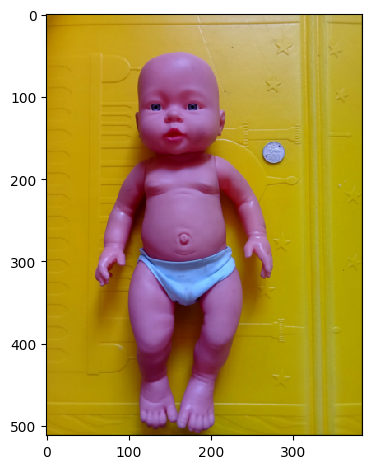

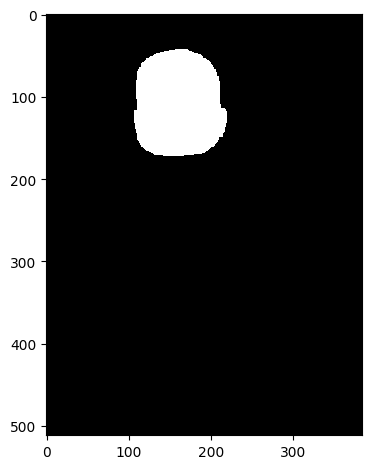

In [29]:
image_x = random.randint(0, len(train_ids))
imshow(X_train[image_x])
plt.show()
imshow(np.squeeze(y_train[image_x]))
plt.show()

## Build the model

In [30]:
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

## Contraction path

In [31]:
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

## Expansive path

In [32]:
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

In [33]:
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[keras.metrics.MeanIoU(num_classes=2)])

## Model Checkpoint

In [34]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_head.keras', verbose=1, save_best_only=True)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_mean_io_u', mode='max'),
    tf.keras.callbacks.TensorBoard(log_dir='logs')]

## Training

In [35]:
result = model.fit(X_train, y_train, validation_split=0.1, batch_size=16, epochs=1000, callbacks=callbacks)

Epoch 1/1000
2/2 [==============================] - ETA: 0s - loss: 0.5468 - mean_io_u_2: 0.4685

2/2 [==============================] - 8s 879ms/step - loss: 0.5468 - mean_io_u_2: 0.4685 - val_loss: 0.4324 - val_mean_io_u_2: 0.4687
Epoch 2/1000
2/2 [==============================] - ETA: 0s - loss: 0.3352 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 160ms/step - loss: 0.3352 - mean_io_u_2: 0.4685 - val_loss: 0.2679 - val_mean_io_u_2: 0.4687
Epoch 3/1000
2/2 [==============================] - ETA: 0s - loss: 0.2372 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 128ms/step - loss: 0.2372 - mean_io_u_2: 0.4685 - val_loss: 0.2205 - val_mean_io_u_2: 0.4687
Epoch 4/1000
2/2 [==============================] - ETA: 0s - loss: 0.2387 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 135ms/step - loss: 0.2387 - mean_io_u_2: 0.4685 - val_loss: 0.2203 - val_mean_io_u_2: 0.4687
Epoch 5/1000
2/2 [==============================] - ETA: 0s - loss: 0.2100 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 132ms/step - loss: 0.2100 - mean_io_u_2: 0.4685 - val_loss: 0.2185 - val_mean_io_u_2: 0.4687
Epoch 6/1000
2/2 [==============================] - ETA: 0s - loss: 0.2014 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 172ms/step - loss: 0.2014 - mean_io_u_2: 0.4685 - val_loss: 0.2045 - val_mean_io_u_2: 0.4687
Epoch 7/1000
2/2 [==============================] - ETA: 0s - loss: 0.1905 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 133ms/step - loss: 0.1905 - mean_io_u_2: 0.4685 - val_loss: 0.1852 - val_mean_io_u_2: 0.4687
Epoch 8/1000
2/2 [==============================] - ETA: 0s - loss: 0.1791 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 132ms/step - loss: 0.1791 - mean_io_u_2: 0.4685 - val_loss: 0.1714 - val_mean_io_u_2: 0.4687
Epoch 9/1000
2/2 [==============================] - ETA: 0s - loss: 0.1718 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 132ms/step - loss: 0.1718 - mean_io_u_2: 0.4685 - val_loss: 0.1652 - val_mean_io_u_2: 0.4687
Epoch 10/1000
2/2 [==============================] - ETA: 0s - loss: 0.1654 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 129ms/step - loss: 0.1654 - mean_io_u_2: 0.4685 - val_loss: 0.1641 - val_mean_io_u_2: 0.4687
Epoch 11/1000
2/2 [==============================] - ETA: 0s - loss: 0.1611 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 136ms/step - loss: 0.1611 - mean_io_u_2: 0.4685 - val_loss: 0.1638 - val_mean_io_u_2: 0.4687
Epoch 12/1000
2/2 [==============================] - ETA: 0s - loss: 0.1592 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 132ms/step - loss: 0.1592 - mean_io_u_2: 0.4685 - val_loss: 0.1607 - val_mean_io_u_2: 0.4687
Epoch 13/1000
2/2 [==============================] - ETA: 0s - loss: 0.1575 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 137ms/step - loss: 0.1575 - mean_io_u_2: 0.4685 - val_loss: 0.1548 - val_mean_io_u_2: 0.4687
Epoch 14/1000
2/2 [==============================] - ETA: 0s - loss: 0.1553 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 136ms/step - loss: 0.1553 - mean_io_u_2: 0.4685 - val_loss: 0.1522 - val_mean_io_u_2: 0.4687
Epoch 15/1000
2/2 [==============================] - ETA: 0s - loss: 0.1522 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 170ms/step - loss: 0.1522 - mean_io_u_2: 0.4685 - val_loss: 0.1549 - val_mean_io_u_2: 0.4687
Epoch 16/1000
2/2 [==============================] - ETA: 0s - loss: 0.1489 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 132ms/step - loss: 0.1489 - mean_io_u_2: 0.4685 - val_loss: 0.1451 - val_mean_io_u_2: 0.4687
Epoch 17/1000
2/2 [==============================] - ETA: 0s - loss: 0.1446 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 134ms/step - loss: 0.1446 - mean_io_u_2: 0.4685 - val_loss: 0.1581 - val_mean_io_u_2: 0.4687
Epoch 18/1000
2/2 [==============================] - ETA: 0s - loss: 0.1333 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 183ms/step - loss: 0.1333 - mean_io_u_2: 0.4685 - val_loss: 0.1550 - val_mean_io_u_2: 0.4687
Epoch 19/1000
2/2 [==============================] - ETA: 0s - loss: 0.1251 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 186ms/step - loss: 0.1251 - mean_io_u_2: 0.4685 - val_loss: 0.1134 - val_mean_io_u_2: 0.4687
Epoch 20/1000
2/2 [==============================] - ETA: 0s - loss: 0.1225 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 158ms/step - loss: 0.1225 - mean_io_u_2: 0.4685 - val_loss: 0.1642 - val_mean_io_u_2: 0.4687
Epoch 21/1000
2/2 [==============================] - ETA: 0s - loss: 0.1234 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 157ms/step - loss: 0.1234 - mean_io_u_2: 0.4685 - val_loss: 0.0954 - val_mean_io_u_2: 0.4687
Epoch 22/1000
2/2 [==============================] - ETA: 0s - loss: 0.1968 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 197ms/step - loss: 0.1968 - mean_io_u_2: 0.4685 - val_loss: 0.2056 - val_mean_io_u_2: 0.4687
Epoch 23/1000
2/2 [==============================] - ETA: 0s - loss: 0.1796 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 132ms/step - loss: 0.1796 - mean_io_u_2: 0.4685 - val_loss: 0.2146 - val_mean_io_u_2: 0.4687
Epoch 24/1000
2/2 [==============================] - ETA: 0s - loss: 0.1927 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 132ms/step - loss: 0.1927 - mean_io_u_2: 0.4685 - val_loss: 0.1847 - val_mean_io_u_2: 0.4687
Epoch 25/1000
2/2 [==============================] - ETA: 0s - loss: 0.1686 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 131ms/step - loss: 0.1686 - mean_io_u_2: 0.4685 - val_loss: 0.1591 - val_mean_io_u_2: 0.4687
Epoch 26/1000
2/2 [==============================] - ETA: 0s - loss: 0.1559 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 130ms/step - loss: 0.1559 - mean_io_u_2: 0.4685 - val_loss: 0.1529 - val_mean_io_u_2: 0.4687
Epoch 27/1000
2/2 [==============================] - ETA: 0s - loss: 0.1660 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 132ms/step - loss: 0.1660 - mean_io_u_2: 0.4685 - val_loss: 0.1529 - val_mean_io_u_2: 0.4687
Epoch 28/1000
2/2 [==============================] - ETA: 0s - loss: 0.1674 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 132ms/step - loss: 0.1674 - mean_io_u_2: 0.4685 - val_loss: 0.1526 - val_mean_io_u_2: 0.4687
Epoch 29/1000
2/2 [==============================] - ETA: 0s - loss: 0.1593 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 130ms/step - loss: 0.1593 - mean_io_u_2: 0.4685 - val_loss: 0.1552 - val_mean_io_u_2: 0.4687
Epoch 30/1000
2/2 [==============================] - ETA: 0s - loss: 0.1557 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 131ms/step - loss: 0.1557 - mean_io_u_2: 0.4685 - val_loss: 0.1594 - val_mean_io_u_2: 0.4687
Epoch 31/1000
2/2 [==============================] - ETA: 0s - loss: 0.1565 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 138ms/step - loss: 0.1565 - mean_io_u_2: 0.4685 - val_loss: 0.1619 - val_mean_io_u_2: 0.4687
Epoch 32/1000
2/2 [==============================] - ETA: 0s - loss: 0.1576 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 132ms/step - loss: 0.1576 - mean_io_u_2: 0.4685 - val_loss: 0.1615 - val_mean_io_u_2: 0.4687
Epoch 33/1000
2/2 [==============================] - ETA: 0s - loss: 0.1570 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 132ms/step - loss: 0.1570 - mean_io_u_2: 0.4685 - val_loss: 0.1583 - val_mean_io_u_2: 0.4687
Epoch 34/1000
2/2 [==============================] - ETA: 0s - loss: 0.1550 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 169ms/step - loss: 0.1550 - mean_io_u_2: 0.4685 - val_loss: 0.1537 - val_mean_io_u_2: 0.4687
Epoch 35/1000
2/2 [==============================] - ETA: 0s - loss: 0.1529 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 135ms/step - loss: 0.1529 - mean_io_u_2: 0.4685 - val_loss: 0.1489 - val_mean_io_u_2: 0.4687
Epoch 36/1000
2/2 [==============================] - ETA: 0s - loss: 0.1509 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 130ms/step - loss: 0.1509 - mean_io_u_2: 0.4685 - val_loss: 0.1430 - val_mean_io_u_2: 0.4687
Epoch 37/1000
2/2 [==============================] - ETA: 0s - loss: 0.1455 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 178ms/step - loss: 0.1455 - mean_io_u_2: 0.4685 - val_loss: 0.1280 - val_mean_io_u_2: 0.4687
Epoch 38/1000
2/2 [==============================] - ETA: 0s - loss: 0.1344 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 190ms/step - loss: 0.1344 - mean_io_u_2: 0.4685 - val_loss: 0.1219 - val_mean_io_u_2: 0.4687
Epoch 39/1000
2/2 [==============================] - ETA: 0s - loss: 0.1165 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 185ms/step - loss: 0.1165 - mean_io_u_2: 0.4685 - val_loss: 0.1157 - val_mean_io_u_2: 0.4687
Epoch 40/1000
2/2 [==============================] - ETA: 0s - loss: 0.1050 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 188ms/step - loss: 0.1050 - mean_io_u_2: 0.4685 - val_loss: 0.1034 - val_mean_io_u_2: 0.4687
Epoch 41/1000
2/2 [==============================] - ETA: 0s - loss: 0.1014 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 146ms/step - loss: 0.1014 - mean_io_u_2: 0.4685 - val_loss: 0.1129 - val_mean_io_u_2: 0.4687
Epoch 42/1000
2/2 [==============================] - ETA: 0s - loss: 0.0956 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 130ms/step - loss: 0.0956 - mean_io_u_2: 0.4685 - val_loss: 0.0879 - val_mean_io_u_2: 0.4687
Epoch 43/1000
2/2 [==============================] - ETA: 0s - loss: 0.1016 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 133ms/step - loss: 0.1016 - mean_io_u_2: 0.4685 - val_loss: 0.1159 - val_mean_io_u_2: 0.4687
Epoch 44/1000
2/2 [==============================] - ETA: 0s - loss: 0.0965 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 171ms/step - loss: 0.0965 - mean_io_u_2: 0.4685 - val_loss: 0.0990 - val_mean_io_u_2: 0.4687
Epoch 45/1000
2/2 [==============================] - ETA: 0s - loss: 0.0867 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 135ms/step - loss: 0.0867 - mean_io_u_2: 0.4685 - val_loss: 0.0775 - val_mean_io_u_2: 0.4687
Epoch 46/1000
2/2 [==============================] - ETA: 0s - loss: 0.0789 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 132ms/step - loss: 0.0789 - mean_io_u_2: 0.4685 - val_loss: 0.0728 - val_mean_io_u_2: 0.4687
Epoch 47/1000
2/2 [==============================] - ETA: 0s - loss: 0.0739 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 130ms/step - loss: 0.0739 - mean_io_u_2: 0.4685 - val_loss: 0.0716 - val_mean_io_u_2: 0.4687
Epoch 48/1000
2/2 [==============================] - ETA: 0s - loss: 0.0688 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 171ms/step - loss: 0.0688 - mean_io_u_2: 0.4685 - val_loss: 0.0695 - val_mean_io_u_2: 0.4687
Epoch 49/1000
2/2 [==============================] - ETA: 0s - loss: 0.0645 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 127ms/step - loss: 0.0645 - mean_io_u_2: 0.4685 - val_loss: 0.0643 - val_mean_io_u_2: 0.4687
Epoch 50/1000
2/2 [==============================] - ETA: 0s - loss: 0.0661 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 130ms/step - loss: 0.0661 - mean_io_u_2: 0.4685 - val_loss: 0.0698 - val_mean_io_u_2: 0.4687
Epoch 51/1000
2/2 [==============================] - ETA: 0s - loss: 0.0615 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 129ms/step - loss: 0.0615 - mean_io_u_2: 0.4685 - val_loss: 0.0634 - val_mean_io_u_2: 0.4687
Epoch 52/1000
2/2 [==============================] - ETA: 0s - loss: 0.0575 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 128ms/step - loss: 0.0575 - mean_io_u_2: 0.4685 - val_loss: 0.0562 - val_mean_io_u_2: 0.4687
Epoch 53/1000
2/2 [==============================] - ETA: 0s - loss: 0.0587 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 172ms/step - loss: 0.0587 - mean_io_u_2: 0.4685 - val_loss: 0.0668 - val_mean_io_u_2: 0.4687
Epoch 54/1000
2/2 [==============================] - ETA: 0s - loss: 0.0543 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 125ms/step - loss: 0.0543 - mean_io_u_2: 0.4685 - val_loss: 0.0531 - val_mean_io_u_2: 0.4687
Epoch 55/1000
2/2 [==============================] - ETA: 0s - loss: 0.0439 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 131ms/step - loss: 0.0439 - mean_io_u_2: 0.4685 - val_loss: 0.0957 - val_mean_io_u_2: 0.4687
Epoch 56/1000
2/2 [==============================] - ETA: 0s - loss: 0.0743 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 167ms/step - loss: 0.0743 - mean_io_u_2: 0.4685 - val_loss: 0.0452 - val_mean_io_u_2: 0.4687
Epoch 57/1000
2/2 [==============================] - ETA: 0s - loss: 0.0367 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 149ms/step - loss: 0.0367 - mean_io_u_2: 0.4685 - val_loss: 0.0395 - val_mean_io_u_2: 0.4687
Epoch 58/1000
2/2 [==============================] - ETA: 0s - loss: 0.0345 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 192ms/step - loss: 0.0345 - mean_io_u_2: 0.4685 - val_loss: 0.0659 - val_mean_io_u_2: 0.4687
Epoch 59/1000
2/2 [==============================] - ETA: 0s - loss: 0.0494 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 153ms/step - loss: 0.0494 - mean_io_u_2: 0.4685 - val_loss: 0.0297 - val_mean_io_u_2: 0.4687
Epoch 60/1000
2/2 [==============================] - ETA: 0s - loss: 0.0241 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 156ms/step - loss: 0.0241 - mean_io_u_2: 0.4685 - val_loss: 0.0187 - val_mean_io_u_2: 0.4687
Epoch 61/1000
2/2 [==============================] - ETA: 0s - loss: 0.0225 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 161ms/step - loss: 0.0225 - mean_io_u_2: 0.4685 - val_loss: 0.0144 - val_mean_io_u_2: 0.4687
Epoch 62/1000
2/2 [==============================] - ETA: 0s - loss: 0.0142 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 130ms/step - loss: 0.0142 - mean_io_u_2: 0.4685 - val_loss: 0.0186 - val_mean_io_u_2: 0.4687
Epoch 63/1000
2/2 [==============================] - ETA: 0s - loss: 0.0145 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 133ms/step - loss: 0.0145 - mean_io_u_2: 0.4685 - val_loss: 0.0140 - val_mean_io_u_2: 0.4687
Epoch 64/1000
2/2 [==============================] - ETA: 0s - loss: 0.0124 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 133ms/step - loss: 0.0124 - mean_io_u_2: 0.4685 - val_loss: 0.0131 - val_mean_io_u_2: 0.4687
Epoch 65/1000
2/2 [==============================] - ETA: 0s - loss: 0.0111 - mean_io_u_2: 0.4687

2/2 [==============================] - 1s 172ms/step - loss: 0.0111 - mean_io_u_2: 0.4687 - val_loss: 0.0124 - val_mean_io_u_2: 0.4687
Epoch 66/1000
2/2 [==============================] - ETA: 0s - loss: 0.0098 - mean_io_u_2: 0.4787

2/2 [==============================] - 1s 131ms/step - loss: 0.0098 - mean_io_u_2: 0.4787 - val_loss: 0.0105 - val_mean_io_u_2: 0.4687
Epoch 67/1000
2/2 [==============================] - ETA: 0s - loss: 0.0075 - mean_io_u_2: 0.5308

2/2 [==============================] - 1s 132ms/step - loss: 0.0075 - mean_io_u_2: 0.5308 - val_loss: 0.0083 - val_mean_io_u_2: 0.4687
Epoch 68/1000
2/2 [==============================] - ETA: 0s - loss: 0.0072 - mean_io_u_2: 0.6313

2/2 [==============================] - 1s 134ms/step - loss: 0.0072 - mean_io_u_2: 0.6313 - val_loss: 0.0078 - val_mean_io_u_2: 0.4759
Epoch 69/1000
2/2 [==============================] - ETA: 0s - loss: 0.0068 - mean_io_u_2: 0.7305

2/2 [==============================] - 1s 130ms/step - loss: 0.0068 - mean_io_u_2: 0.7305 - val_loss: 0.0101 - val_mean_io_u_2: 0.4986
Epoch 70/1000
2/2 [==============================] - ETA: 0s - loss: 0.0061 - mean_io_u_2: 0.8001

2/2 [==============================] - 1s 133ms/step - loss: 0.0061 - mean_io_u_2: 0.8001 - val_loss: 0.0103 - val_mean_io_u_2: 0.5280
Epoch 71/1000
2/2 [==============================] - ETA: 0s - loss: 0.0053 - mean_io_u_2: 0.8279

2/2 [==============================] - 1s 128ms/step - loss: 0.0053 - mean_io_u_2: 0.8279 - val_loss: 0.0078 - val_mean_io_u_2: 0.5587
Epoch 72/1000
2/2 [==============================] - ETA: 0s - loss: 0.0050 - mean_io_u_2: 0.8382

2/2 [==============================] - 1s 134ms/step - loss: 0.0050 - mean_io_u_2: 0.8382 - val_loss: 0.0067 - val_mean_io_u_2: 0.5960
Epoch 73/1000
2/2 [==============================] - ETA: 0s - loss: 0.0049 - mean_io_u_2: 0.8541

2/2 [==============================] - 1s 131ms/step - loss: 0.0049 - mean_io_u_2: 0.8541 - val_loss: 0.0066 - val_mean_io_u_2: 0.6301
Epoch 74/1000
2/2 [==============================] - ETA: 0s - loss: 0.0050 - mean_io_u_2: 0.8629

2/2 [==============================] - 1s 137ms/step - loss: 0.0050 - mean_io_u_2: 0.8629 - val_loss: 0.0085 - val_mean_io_u_2: 0.6630
Epoch 75/1000
2/2 [==============================] - ETA: 0s - loss: 0.0051 - mean_io_u_2: 0.8665

2/2 [==============================] - 1s 170ms/step - loss: 0.0051 - mean_io_u_2: 0.8665 - val_loss: 0.0117 - val_mean_io_u_2: 0.7841
Epoch 76/1000
2/2 [==============================] - ETA: 0s - loss: 0.0055 - mean_io_u_2: 0.8904

2/2 [==============================] - 1s 130ms/step - loss: 0.0055 - mean_io_u_2: 0.8904 - val_loss: 0.0064 - val_mean_io_u_2: 0.8287
Epoch 77/1000
2/2 [==============================] - ETA: 0s - loss: 0.0046 - mean_io_u_2: 0.8981

2/2 [==============================] - 1s 188ms/step - loss: 0.0046 - mean_io_u_2: 0.8981 - val_loss: 0.0052 - val_mean_io_u_2: 0.8217
Epoch 78/1000
2/2 [==============================] - ETA: 0s - loss: 0.0048 - mean_io_u_2: 0.8916

2/2 [==============================] - 1s 195ms/step - loss: 0.0048 - mean_io_u_2: 0.8916 - val_loss: 0.0071 - val_mean_io_u_2: 0.8253
Epoch 79/1000
2/2 [==============================] - ETA: 0s - loss: 0.0038 - mean_io_u_2: 0.8958

2/2 [==============================] - 1s 192ms/step - loss: 0.0038 - mean_io_u_2: 0.8958 - val_loss: 0.0082 - val_mean_io_u_2: 0.8271
Epoch 80/1000
2/2 [==============================] - ETA: 0s - loss: 0.0042 - mean_io_u_2: 0.8949

2/2 [==============================] - 1s 188ms/step - loss: 0.0042 - mean_io_u_2: 0.8949 - val_loss: 0.0063 - val_mean_io_u_2: 0.8143
Epoch 81/1000
2/2 [==============================] - ETA: 0s - loss: 0.0037 - mean_io_u_2: 0.8882

2/2 [==============================] - 1s 196ms/step - loss: 0.0037 - mean_io_u_2: 0.8882 - val_loss: 0.0056 - val_mean_io_u_2: 0.8169
Epoch 82/1000
2/2 [==============================] - ETA: 0s - loss: 0.0036 - mean_io_u_2: 0.8902

2/2 [==============================] - 1s 130ms/step - loss: 0.0036 - mean_io_u_2: 0.8902 - val_loss: 0.0056 - val_mean_io_u_2: 0.8333
Epoch 83/1000
2/2 [==============================] - ETA: 0s - loss: 0.0035 - mean_io_u_2: 0.8962

2/2 [==============================] - 1s 130ms/step - loss: 0.0035 - mean_io_u_2: 0.8962 - val_loss: 0.0061 - val_mean_io_u_2: 0.8445
Epoch 84/1000
2/2 [==============================] - ETA: 0s - loss: 0.0036 - mean_io_u_2: 0.8986

2/2 [==============================] - 1s 129ms/step - loss: 0.0036 - mean_io_u_2: 0.8986 - val_loss: 0.0062 - val_mean_io_u_2: 0.8519
Epoch 85/1000
2/2 [==============================] - ETA: 0s - loss: 0.0035 - mean_io_u_2: 0.9010

2/2 [==============================] - 1s 127ms/step - loss: 0.0035 - mean_io_u_2: 0.9010 - val_loss: 0.0057 - val_mean_io_u_2: 0.8509
Epoch 86/1000
2/2 [==============================] - ETA: 0s - loss: 0.0034 - mean_io_u_2: 0.9006

2/2 [==============================] - 1s 131ms/step - loss: 0.0034 - mean_io_u_2: 0.9006 - val_loss: 0.0053 - val_mean_io_u_2: 0.8513
Epoch 87/1000
2/2 [==============================] - ETA: 0s - loss: 0.0032 - mean_io_u_2: 0.9007

2/2 [==============================] - 1s 129ms/step - loss: 0.0032 - mean_io_u_2: 0.9007 - val_loss: 0.0048 - val_mean_io_u_2: 0.8576
Epoch 88/1000
2/2 [==============================] - ETA: 0s - loss: 0.0034 - mean_io_u_2: 0.9022

2/2 [==============================] - 1s 130ms/step - loss: 0.0034 - mean_io_u_2: 0.9022 - val_loss: 0.0052 - val_mean_io_u_2: 0.8643
Epoch 89/1000
2/2 [==============================] - ETA: 0s - loss: 0.0034 - mean_io_u_2: 0.9063

2/2 [==============================] - 1s 133ms/step - loss: 0.0034 - mean_io_u_2: 0.9063 - val_loss: 0.0057 - val_mean_io_u_2: 0.8637
Epoch 90/1000
2/2 [==============================] - ETA: 0s - loss: 0.0033 - mean_io_u_2: 0.9051

2/2 [==============================] - 1s 137ms/step - loss: 0.0033 - mean_io_u_2: 0.9051 - val_loss: 0.0050 - val_mean_io_u_2: 0.8644
Epoch 91/1000
2/2 [==============================] - ETA: 0s - loss: 0.0032 - mean_io_u_2: 0.9049

2/2 [==============================] - 1s 132ms/step - loss: 0.0032 - mean_io_u_2: 0.9049 - val_loss: 0.0041 - val_mean_io_u_2: 0.8741
Epoch 92/1000
2/2 [==============================] - ETA: 0s - loss: 0.0033 - mean_io_u_2: 0.9098

2/2 [==============================] - 1s 133ms/step - loss: 0.0033 - mean_io_u_2: 0.9098 - val_loss: 0.0040 - val_mean_io_u_2: 0.8787
Epoch 93/1000
2/2 [==============================] - ETA: 0s - loss: 0.0030 - mean_io_u_2: 0.9126

2/2 [==============================] - 1s 171ms/step - loss: 0.0030 - mean_io_u_2: 0.9126 - val_loss: 0.0049 - val_mean_io_u_2: 0.8815
Epoch 94/1000
2/2 [==============================] - ETA: 0s - loss: 0.0031 - mean_io_u_2: 0.9130

2/2 [==============================] - 1s 130ms/step - loss: 0.0031 - mean_io_u_2: 0.9130 - val_loss: 0.0057 - val_mean_io_u_2: 0.8826
Epoch 95/1000
2/2 [==============================] - ETA: 0s - loss: 0.0035 - mean_io_u_2: 0.9137

2/2 [==============================] - 1s 133ms/step - loss: 0.0035 - mean_io_u_2: 0.9137 - val_loss: 0.0039 - val_mean_io_u_2: 0.8805
Epoch 96/1000
2/2 [==============================] - ETA: 0s - loss: 0.0032 - mean_io_u_2: 0.9117

2/2 [==============================] - 1s 133ms/step - loss: 0.0032 - mean_io_u_2: 0.9117 - val_loss: 0.0036 - val_mean_io_u_2: 0.8824
Epoch 97/1000
2/2 [==============================] - ETA: 0s - loss: 0.0033 - mean_io_u_2: 0.9133

2/2 [==============================] - 1s 193ms/step - loss: 0.0033 - mean_io_u_2: 0.9133 - val_loss: 0.0046 - val_mean_io_u_2: 0.8781
Epoch 98/1000
2/2 [==============================] - ETA: 0s - loss: 0.0030 - mean_io_u_2: 0.9101

2/2 [==============================] - 1s 193ms/step - loss: 0.0030 - mean_io_u_2: 0.9101 - val_loss: 0.0051 - val_mean_io_u_2: 0.8769
Epoch 99/1000
2/2 [==============================] - ETA: 0s - loss: 0.0032 - mean_io_u_2: 0.9076

2/2 [==============================] - 1s 198ms/step - loss: 0.0032 - mean_io_u_2: 0.9076 - val_loss: 0.0049 - val_mean_io_u_2: 0.8874
Epoch 100/1000
2/2 [==============================] - ETA: 0s - loss: 0.0032 - mean_io_u_2: 0.9170

2/2 [==============================] - 1s 201ms/step - loss: 0.0032 - mean_io_u_2: 0.9170 - val_loss: 0.0041 - val_mean_io_u_2: 0.8891
Epoch 101/1000
2/2 [==============================] - ETA: 0s - loss: 0.0032 - mean_io_u_2: 0.9163

2/2 [==============================] - 1s 187ms/step - loss: 0.0032 - mean_io_u_2: 0.9163 - val_loss: 0.0045 - val_mean_io_u_2: 0.8811
Epoch 102/1000
2/2 [==============================] - ETA: 0s - loss: 0.0029 - mean_io_u_2: 0.9091

2/2 [==============================] - 1s 135ms/step - loss: 0.0029 - mean_io_u_2: 0.9091 - val_loss: 0.0054 - val_mean_io_u_2: 0.8837
Epoch 103/1000
2/2 [==============================] - ETA: 0s - loss: 0.0029 - mean_io_u_2: 0.9122

2/2 [==============================] - 1s 172ms/step - loss: 0.0029 - mean_io_u_2: 0.9122 - val_loss: 0.0058 - val_mean_io_u_2: 0.8886
Epoch 104/1000
2/2 [==============================] - ETA: 0s - loss: 0.0031 - mean_io_u_2: 0.9153

2/2 [==============================] - 1s 172ms/step - loss: 0.0031 - mean_io_u_2: 0.9153 - val_loss: 0.0049 - val_mean_io_u_2: 0.8841
Epoch 105/1000
2/2 [==============================] - ETA: 0s - loss: 0.0027 - mean_io_u_2: 0.9112

2/2 [==============================] - 1s 171ms/step - loss: 0.0027 - mean_io_u_2: 0.9112 - val_loss: 0.0045 - val_mean_io_u_2: 0.8822
Epoch 106/1000
2/2 [==============================] - ETA: 0s - loss: 0.0028 - mean_io_u_2: 0.9097

2/2 [==============================] - 1s 173ms/step - loss: 0.0028 - mean_io_u_2: 0.9097 - val_loss: 0.0052 - val_mean_io_u_2: 0.8864
Epoch 107/1000
2/2 [==============================] - ETA: 0s - loss: 0.0029 - mean_io_u_2: 0.9132

2/2 [==============================] - 1s 130ms/step - loss: 0.0029 - mean_io_u_2: 0.9132 - val_loss: 0.0056 - val_mean_io_u_2: 0.8864
Epoch 108/1000
2/2 [==============================] - ETA: 0s - loss: 0.0028 - mean_io_u_2: 0.9125

2/2 [==============================] - 1s 133ms/step - loss: 0.0028 - mean_io_u_2: 0.9125 - val_loss: 0.0044 - val_mean_io_u_2: 0.8827
Epoch 109/1000
2/2 [==============================] - ETA: 0s - loss: 0.0029 - mean_io_u_2: 0.9089

2/2 [==============================] - 1s 171ms/step - loss: 0.0029 - mean_io_u_2: 0.9089 - val_loss: 0.0042 - val_mean_io_u_2: 0.8844
Epoch 110/1000
2/2 [==============================] - ETA: 0s - loss: 0.0027 - mean_io_u_2: 0.9107

2/2 [==============================] - 1s 131ms/step - loss: 0.0027 - mean_io_u_2: 0.9107 - val_loss: 0.0044 - val_mean_io_u_2: 0.8894
Epoch 111/1000
2/2 [==============================] - ETA: 0s - loss: 0.0026 - mean_io_u_2: 0.9145

2/2 [==============================] - 1s 179ms/step - loss: 0.0026 - mean_io_u_2: 0.9145 - val_loss: 0.0051 - val_mean_io_u_2: 0.8926
Epoch 112/1000
2/2 [==============================] - ETA: 0s - loss: 0.0029 - mean_io_u_2: 0.9176

2/2 [==============================] - 1s 134ms/step - loss: 0.0029 - mean_io_u_2: 0.9176 - val_loss: 0.0042 - val_mean_io_u_2: 0.8894
Epoch 113/1000
2/2 [==============================] - ETA: 0s - loss: 0.0026 - mean_io_u_2: 0.9140

2/2 [==============================] - 1s 175ms/step - loss: 0.0026 - mean_io_u_2: 0.9140 - val_loss: 0.0038 - val_mean_io_u_2: 0.8876
Epoch 114/1000
2/2 [==============================] - ETA: 0s - loss: 0.0026 - mean_io_u_2: 0.9130

2/2 [==============================] - 1s 133ms/step - loss: 0.0026 - mean_io_u_2: 0.9130 - val_loss: 0.0039 - val_mean_io_u_2: 0.8910
Epoch 115/1000
2/2 [==============================] - ETA: 0s - loss: 0.0027 - mean_io_u_2: 0.9156

2/2 [==============================] - 1s 175ms/step - loss: 0.0027 - mean_io_u_2: 0.9156 - val_loss: 0.0048 - val_mean_io_u_2: 0.8935
Epoch 116/1000
2/2 [==============================] - ETA: 0s - loss: 0.0027 - mean_io_u_2: 0.9175

2/2 [==============================] - 1s 184ms/step - loss: 0.0027 - mean_io_u_2: 0.9175 - val_loss: 0.0045 - val_mean_io_u_2: 0.8919
Epoch 117/1000
2/2 [==============================] - ETA: 0s - loss: 0.0025 - mean_io_u_2: 0.9149

2/2 [==============================] - 1s 189ms/step - loss: 0.0025 - mean_io_u_2: 0.9149 - val_loss: 0.0037 - val_mean_io_u_2: 0.8928
Epoch 118/1000
2/2 [==============================] - ETA: 0s - loss: 0.0027 - mean_io_u_2: 0.9155

2/2 [==============================] - 1s 192ms/step - loss: 0.0027 - mean_io_u_2: 0.9155 - val_loss: 0.0034 - val_mean_io_u_2: 0.8977
Epoch 119/1000
2/2 [==============================] - ETA: 0s - loss: 0.0027 - mean_io_u_2: 0.9193

2/2 [==============================] - 1s 192ms/step - loss: 0.0027 - mean_io_u_2: 0.9193 - val_loss: 0.0042 - val_mean_io_u_2: 0.9003
Epoch 120/1000
2/2 [==============================] - ETA: 0s - loss: 0.0026 - mean_io_u_2: 0.9217

2/2 [==============================] - 1s 202ms/step - loss: 0.0026 - mean_io_u_2: 0.9217 - val_loss: 0.0057 - val_mean_io_u_2: 0.9022
Epoch 121/1000
2/2 [==============================] - ETA: 0s - loss: 0.0029 - mean_io_u_2: 0.9231

2/2 [==============================] - 1s 173ms/step - loss: 0.0029 - mean_io_u_2: 0.9231 - val_loss: 0.0047 - val_mean_io_u_2: 0.8990
Epoch 122/1000
2/2 [==============================] - ETA: 0s - loss: 0.0026 - mean_io_u_2: 0.9194

2/2 [==============================] - 1s 139ms/step - loss: 0.0026 - mean_io_u_2: 0.9194 - val_loss: 0.0033 - val_mean_io_u_2: 0.8952
Epoch 123/1000
2/2 [==============================] - ETA: 0s - loss: 0.0026 - mean_io_u_2: 0.9158

2/2 [==============================] - 1s 132ms/step - loss: 0.0026 - mean_io_u_2: 0.9158 - val_loss: 0.0036 - val_mean_io_u_2: 0.9002
Epoch 124/1000
2/2 [==============================] - ETA: 0s - loss: 0.0028 - mean_io_u_2: 0.9218

2/2 [==============================] - 1s 172ms/step - loss: 0.0028 - mean_io_u_2: 0.9218 - val_loss: 0.0048 - val_mean_io_u_2: 0.8991
Epoch 125/1000
2/2 [==============================] - ETA: 0s - loss: 0.0027 - mean_io_u_2: 0.9204

2/2 [==============================] - 1s 131ms/step - loss: 0.0027 - mean_io_u_2: 0.9204 - val_loss: 0.0048 - val_mean_io_u_2: 0.8937
Epoch 126/1000
2/2 [==============================] - ETA: 0s - loss: 0.0026 - mean_io_u_2: 0.9141

2/2 [==============================] - 1s 136ms/step - loss: 0.0026 - mean_io_u_2: 0.9141 - val_loss: 0.0041 - val_mean_io_u_2: 0.8962
Epoch 127/1000
2/2 [==============================] - ETA: 0s - loss: 0.0025 - mean_io_u_2: 0.9168

2/2 [==============================] - 1s 172ms/step - loss: 0.0025 - mean_io_u_2: 0.9168 - val_loss: 0.0038 - val_mean_io_u_2: 0.9014
Epoch 128/1000
2/2 [==============================] - ETA: 0s - loss: 0.0026 - mean_io_u_2: 0.9216

2/2 [==============================] - 1s 133ms/step - loss: 0.0026 - mean_io_u_2: 0.9216 - val_loss: 0.0041 - val_mean_io_u_2: 0.8992
Epoch 129/1000
2/2 [==============================] - ETA: 0s - loss: 0.0024 - mean_io_u_2: 0.9183

2/2 [==============================] - 1s 133ms/step - loss: 0.0024 - mean_io_u_2: 0.9183 - val_loss: 0.0045 - val_mean_io_u_2: 0.8975
Epoch 130/1000
2/2 [==============================] - ETA: 0s - loss: 0.0027 - mean_io_u_2: 0.9166

2/2 [==============================] - 1s 171ms/step - loss: 0.0027 - mean_io_u_2: 0.9166 - val_loss: 0.0038 - val_mean_io_u_2: 0.9003
Epoch 131/1000
2/2 [==============================] - ETA: 0s - loss: 0.0024 - mean_io_u_2: 0.9194

2/2 [==============================] - 1s 132ms/step - loss: 0.0024 - mean_io_u_2: 0.9194 - val_loss: 0.0031 - val_mean_io_u_2: 0.9028
Epoch 132/1000
2/2 [==============================] - ETA: 0s - loss: 0.0028 - mean_io_u_2: 0.9219

2/2 [==============================] - 1s 131ms/step - loss: 0.0028 - mean_io_u_2: 0.9219 - val_loss: 0.0041 - val_mean_io_u_2: 0.9006
Epoch 133/1000
2/2 [==============================] - ETA: 0s - loss: 0.0024 - mean_io_u_2: 0.9190

2/2 [==============================] - 1s 136ms/step - loss: 0.0024 - mean_io_u_2: 0.9190 - val_loss: 0.0059 - val_mean_io_u_2: 0.9007
Epoch 134/1000
2/2 [==============================] - ETA: 0s - loss: 0.0027 - mean_io_u_2: 0.9187

2/2 [==============================] - 1s 134ms/step - loss: 0.0027 - mean_io_u_2: 0.9187 - val_loss: 0.0053 - val_mean_io_u_2: 0.9038
Epoch 135/1000
2/2 [==============================] - ETA: 0s - loss: 0.0026 - mean_io_u_2: 0.9215

2/2 [==============================] - 1s 169ms/step - loss: 0.0026 - mean_io_u_2: 0.9215 - val_loss: 0.0032 - val_mean_io_u_2: 0.9064
Epoch 136/1000
2/2 [==============================] - ETA: 0s - loss: 0.0028 - mean_io_u_2: 0.9237

2/2 [==============================] - 1s 186ms/step - loss: 0.0028 - mean_io_u_2: 0.9237 - val_loss: 0.0031 - val_mean_io_u_2: 0.9032
Epoch 137/1000
2/2 [==============================] - ETA: 0s - loss: 0.0030 - mean_io_u_2: 0.9201

2/2 [==============================] - 1s 192ms/step - loss: 0.0030 - mean_io_u_2: 0.9201 - val_loss: 0.0055 - val_mean_io_u_2: 0.9046
Epoch 138/1000
2/2 [==============================] - ETA: 0s - loss: 0.0027 - mean_io_u_2: 0.9220

2/2 [==============================] - 1s 187ms/step - loss: 0.0027 - mean_io_u_2: 0.9220 - val_loss: 0.0075 - val_mean_io_u_2: 0.9066
Epoch 139/1000
2/2 [==============================] - ETA: 0s - loss: 0.0031 - mean_io_u_2: 0.9227

2/2 [==============================] - 1s 166ms/step - loss: 0.0031 - mean_io_u_2: 0.9227 - val_loss: 0.0045 - val_mean_io_u_2: 0.9045
Epoch 140/1000
2/2 [==============================] - ETA: 0s - loss: 0.0023 - mean_io_u_2: 0.9208

2/2 [==============================] - 1s 134ms/step - loss: 0.0023 - mean_io_u_2: 0.9208 - val_loss: 0.0031 - val_mean_io_u_2: 0.9050
Epoch 141/1000
2/2 [==============================] - ETA: 0s - loss: 0.0027 - mean_io_u_2: 0.9213

2/2 [==============================] - 1s 129ms/step - loss: 0.0027 - mean_io_u_2: 0.9213 - val_loss: 0.0035 - val_mean_io_u_2: 0.9047
Epoch 142/1000
2/2 [==============================] - ETA: 0s - loss: 0.0025 - mean_io_u_2: 0.9208

2/2 [==============================] - 1s 178ms/step - loss: 0.0025 - mean_io_u_2: 0.9208 - val_loss: 0.0047 - val_mean_io_u_2: 0.9025
Epoch 143/1000
2/2 [==============================] - ETA: 0s - loss: 0.0025 - mean_io_u_2: 0.9187

2/2 [==============================] - 1s 134ms/step - loss: 0.0025 - mean_io_u_2: 0.9187 - val_loss: 0.0055 - val_mean_io_u_2: 0.9032
Epoch 144/1000
2/2 [==============================] - ETA: 0s - loss: 0.0026 - mean_io_u_2: 0.9190

2/2 [==============================] - 1s 172ms/step - loss: 0.0026 - mean_io_u_2: 0.9190 - val_loss: 0.0044 - val_mean_io_u_2: 0.9041
Epoch 145/1000
2/2 [==============================] - ETA: 0s - loss: 0.0025 - mean_io_u_2: 0.9202

2/2 [==============================] - 1s 133ms/step - loss: 0.0025 - mean_io_u_2: 0.9202 - val_loss: 0.0032 - val_mean_io_u_2: 0.9033
Epoch 146/1000
2/2 [==============================] - ETA: 0s - loss: 0.0026 - mean_io_u_2: 0.9186

2/2 [==============================] - 1s 172ms/step - loss: 0.0026 - mean_io_u_2: 0.9186 - val_loss: 0.0034 - val_mean_io_u_2: 0.9056
Epoch 147/1000
2/2 [==============================] - ETA: 0s - loss: 0.0024 - mean_io_u_2: 0.9220

2/2 [==============================] - 1s 134ms/step - loss: 0.0024 - mean_io_u_2: 0.9220 - val_loss: 0.0045 - val_mean_io_u_2: 0.9048
Epoch 148/1000
2/2 [==============================] - ETA: 0s - loss: 0.0024 - mean_io_u_2: 0.9209

2/2 [==============================] - 1s 133ms/step - loss: 0.0024 - mean_io_u_2: 0.9209 - val_loss: 0.0043 - val_mean_io_u_2: 0.8999
Epoch 149/1000
2/2 [==============================] - ETA: 0s - loss: 0.0025 - mean_io_u_2: 0.9147

2/2 [==============================] - 1s 133ms/step - loss: 0.0025 - mean_io_u_2: 0.9147 - val_loss: 0.0034 - val_mean_io_u_2: 0.9008
Epoch 150/1000
2/2 [==============================] - ETA: 0s - loss: 0.0024 - mean_io_u_2: 0.9164

2/2 [==============================] - 1s 139ms/step - loss: 0.0024 - mean_io_u_2: 0.9164 - val_loss: 0.0032 - val_mean_io_u_2: 0.9085
Epoch 151/1000
2/2 [==============================] - ETA: 0s - loss: 0.0025 - mean_io_u_2: 0.9245

2/2 [==============================] - 1s 171ms/step - loss: 0.0025 - mean_io_u_2: 0.9245 - val_loss: 0.0038 - val_mean_io_u_2: 0.9099
Epoch 152/1000
2/2 [==============================] - ETA: 0s - loss: 0.0025 - mean_io_u_2: 0.9254

2/2 [==============================] - 1s 131ms/step - loss: 0.0025 - mean_io_u_2: 0.9254 - val_loss: 0.0042 - val_mean_io_u_2: 0.9050
Epoch 153/1000
2/2 [==============================] - ETA: 0s - loss: 0.0024 - mean_io_u_2: 0.9199

2/2 [==============================] - 1s 133ms/step - loss: 0.0024 - mean_io_u_2: 0.9199 - val_loss: 0.0040 - val_mean_io_u_2: 0.9029
Epoch 154/1000
2/2 [==============================] - ETA: 0s - loss: 0.0024 - mean_io_u_2: 0.9179

2/2 [==============================] - 1s 134ms/step - loss: 0.0024 - mean_io_u_2: 0.9179 - val_loss: 0.0037 - val_mean_io_u_2: 0.9081
Epoch 155/1000
2/2 [==============================] - ETA: 0s - loss: 0.0022 - mean_io_u_2: 0.9230

2/2 [==============================] - 1s 160ms/step - loss: 0.0022 - mean_io_u_2: 0.9230 - val_loss: 0.0037 - val_mean_io_u_2: 0.9131
Epoch 156/1000
2/2 [==============================] - ETA: 0s - loss: 0.0025 - mean_io_u_2: 0.9278

2/2 [==============================] - 1s 151ms/step - loss: 0.0025 - mean_io_u_2: 0.9278 - val_loss: 0.0037 - val_mean_io_u_2: 0.9117
Epoch 157/1000
2/2 [==============================] - ETA: 0s - loss: 0.0022 - mean_io_u_2: 0.9259

2/2 [==============================] - 1s 194ms/step - loss: 0.0022 - mean_io_u_2: 0.9259 - val_loss: 0.0039 - val_mean_io_u_2: 0.9092
Epoch 158/1000
2/2 [==============================] - ETA: 0s - loss: 0.0025 - mean_io_u_2: 0.9229

2/2 [==============================] - 1s 155ms/step - loss: 0.0025 - mean_io_u_2: 0.9229 - val_loss: 0.0040 - val_mean_io_u_2: 0.9116
Epoch 159/1000
2/2 [==============================] - ETA: 0s - loss: 0.0023 - mean_io_u_2: 0.9249

2/2 [==============================] - 1s 162ms/step - loss: 0.0023 - mean_io_u_2: 0.9249 - val_loss: 0.0037 - val_mean_io_u_2: 0.9158
Epoch 160/1000
2/2 [==============================] - ETA: 0s - loss: 0.0022 - mean_io_u_2: 0.9289

2/2 [==============================] - 1s 131ms/step - loss: 0.0022 - mean_io_u_2: 0.9289 - val_loss: 0.0040 - val_mean_io_u_2: 0.9181
Epoch 161/1000
2/2 [==============================] - ETA: 0s - loss: 0.0024 - mean_io_u_2: 0.9311

2/2 [==============================] - 1s 136ms/step - loss: 0.0024 - mean_io_u_2: 0.9311 - val_loss: 0.0037 - val_mean_io_u_2: 0.9146
Epoch 162/1000
2/2 [==============================] - ETA: 0s - loss: 0.0022 - mean_io_u_2: 0.9266

2/2 [==============================] - 1s 135ms/step - loss: 0.0022 - mean_io_u_2: 0.9266 - val_loss: 0.0033 - val_mean_io_u_2: 0.9106
Epoch 163/1000
2/2 [==============================] - ETA: 0s - loss: 0.0024 - mean_io_u_2: 0.9235

2/2 [==============================] - 1s 135ms/step - loss: 0.0024 - mean_io_u_2: 0.9235 - val_loss: 0.0037 - val_mean_io_u_2: 0.9151
Epoch 164/1000
2/2 [==============================] - ETA: 0s - loss: 0.0022 - mean_io_u_2: 0.9283

2/2 [==============================] - 1s 129ms/step - loss: 0.0022 - mean_io_u_2: 0.9283 - val_loss: 0.0044 - val_mean_io_u_2: 0.9180
Epoch 165/1000
2/2 [==============================] - ETA: 0s - loss: 0.0023 - mean_io_u_2: 0.9310

2/2 [==============================] - 1s 127ms/step - loss: 0.0023 - mean_io_u_2: 0.9310 - val_loss: 0.0031 - val_mean_io_u_2: 0.9143
Epoch 166/1000
2/2 [==============================] - ETA: 0s - loss: 0.0023 - mean_io_u_2: 0.9267

2/2 [==============================] - 1s 135ms/step - loss: 0.0023 - mean_io_u_2: 0.9267 - val_loss: 0.0032 - val_mean_io_u_2: 0.9138
Epoch 167/1000
2/2 [==============================] - ETA: 0s - loss: 0.0022 - mean_io_u_2: 0.9267

2/2 [==============================] - 1s 137ms/step - loss: 0.0022 - mean_io_u_2: 0.9267 - val_loss: 0.0045 - val_mean_io_u_2: 0.9179
Epoch 168/1000
2/2 [==============================] - ETA: 0s - loss: 0.0022 - mean_io_u_2: 0.9302

2/2 [==============================] - 1s 136ms/step - loss: 0.0022 - mean_io_u_2: 0.9302 - val_loss: 0.0040 - val_mean_io_u_2: 0.9178
Epoch 169/1000
2/2 [==============================] - ETA: 0s - loss: 0.0021 - mean_io_u_2: 0.9299

2/2 [==============================] - 1s 133ms/step - loss: 0.0021 - mean_io_u_2: 0.9299 - val_loss: 0.0030 - val_mean_io_u_2: 0.9142
Epoch 170/1000
2/2 [==============================] - ETA: 0s - loss: 0.0024 - mean_io_u_2: 0.9265

2/2 [==============================] - 1s 133ms/step - loss: 0.0024 - mean_io_u_2: 0.9265 - val_loss: 0.0031 - val_mean_io_u_2: 0.9163
Epoch 171/1000
2/2 [==============================] - ETA: 0s - loss: 0.0022 - mean_io_u_2: 0.9287

2/2 [==============================] - 1s 138ms/step - loss: 0.0022 - mean_io_u_2: 0.9287 - val_loss: 0.0046 - val_mean_io_u_2: 0.9193
Epoch 172/1000
2/2 [==============================] - ETA: 0s - loss: 0.0023 - mean_io_u_2: 0.9319

2/2 [==============================] - 1s 140ms/step - loss: 0.0023 - mean_io_u_2: 0.9319 - val_loss: 0.0049 - val_mean_io_u_2: 0.9170
Epoch 173/1000
2/2 [==============================] - ETA: 0s - loss: 0.0023 - mean_io_u_2: 0.9294

2/2 [==============================] - 1s 132ms/step - loss: 0.0023 - mean_io_u_2: 0.9294 - val_loss: 0.0036 - val_mean_io_u_2: 0.9133
Epoch 174/1000
2/2 [==============================] - ETA: 0s - loss: 0.0022 - mean_io_u_2: 0.9259

2/2 [==============================] - 1s 185ms/step - loss: 0.0022 - mean_io_u_2: 0.9259 - val_loss: 0.0027 - val_mean_io_u_2: 0.9127
Epoch 175/1000
2/2 [==============================] - ETA: 0s - loss: 0.0023 - mean_io_u_2: 0.9253

2/2 [==============================] - 1s 196ms/step - loss: 0.0023 - mean_io_u_2: 0.9253 - val_loss: 0.0026 - val_mean_io_u_2: 0.9163
Epoch 176/1000
2/2 [==============================] - ETA: 0s - loss: 0.0023 - mean_io_u_2: 0.9290

2/2 [==============================] - 1s 166ms/step - loss: 0.0023 - mean_io_u_2: 0.9290 - val_loss: 0.0043 - val_mean_io_u_2: 0.9204
Epoch 177/1000
2/2 [==============================] - ETA: 0s - loss: 0.0027 - mean_io_u_2: 0.9335

2/2 [==============================] - 1s 163ms/step - loss: 0.0027 - mean_io_u_2: 0.9335 - val_loss: 0.0039 - val_mean_io_u_2: 0.9156
Epoch 178/1000
2/2 [==============================] - ETA: 0s - loss: 0.0023 - mean_io_u_2: 0.9286

2/2 [==============================] - 1s 162ms/step - loss: 0.0023 - mean_io_u_2: 0.9286 - val_loss: 0.0029 - val_mean_io_u_2: 0.9101
Epoch 179/1000
2/2 [==============================] - ETA: 0s - loss: 0.0026 - mean_io_u_2: 0.9222

2/2 [==============================] - 1s 134ms/step - loss: 0.0026 - mean_io_u_2: 0.9222 - val_loss: 0.0027 - val_mean_io_u_2: 0.9148
Epoch 180/1000
2/2 [==============================] - ETA: 0s - loss: 0.0023 - mean_io_u_2: 0.9274

2/2 [==============================] - 1s 173ms/step - loss: 0.0023 - mean_io_u_2: 0.9274 - val_loss: 0.0042 - val_mean_io_u_2: 0.9212
Epoch 181/1000
2/2 [==============================] - ETA: 0s - loss: 0.0027 - mean_io_u_2: 0.9348

2/2 [==============================] - 1s 135ms/step - loss: 0.0027 - mean_io_u_2: 0.9348 - val_loss: 0.0040 - val_mean_io_u_2: 0.9161
Epoch 182/1000
2/2 [==============================] - ETA: 0s - loss: 0.0023 - mean_io_u_2: 0.9288

2/2 [==============================] - 1s 177ms/step - loss: 0.0023 - mean_io_u_2: 0.9288 - val_loss: 0.0034 - val_mean_io_u_2: 0.9086
Epoch 183/1000
2/2 [==============================] - ETA: 0s - loss: 0.0025 - mean_io_u_2: 0.9199

2/2 [==============================] - 1s 133ms/step - loss: 0.0025 - mean_io_u_2: 0.9199 - val_loss: 0.0031 - val_mean_io_u_2: 0.9105
Epoch 184/1000
2/2 [==============================] - ETA: 0s - loss: 0.0022 - mean_io_u_2: 0.9238

2/2 [==============================] - 1s 134ms/step - loss: 0.0022 - mean_io_u_2: 0.9238 - val_loss: 0.0037 - val_mean_io_u_2: 0.9186
Epoch 185/1000
2/2 [==============================] - ETA: 0s - loss: 0.0024 - mean_io_u_2: 0.9323

2/2 [==============================] - 1s 135ms/step - loss: 0.0024 - mean_io_u_2: 0.9323 - val_loss: 0.0044 - val_mean_io_u_2: 0.9199
Epoch 186/1000
2/2 [==============================] - ETA: 0s - loss: 0.0024 - mean_io_u_2: 0.9323

2/2 [==============================] - 1s 128ms/step - loss: 0.0024 - mean_io_u_2: 0.9323 - val_loss: 0.0039 - val_mean_io_u_2: 0.9147
Epoch 187/1000
2/2 [==============================] - ETA: 0s - loss: 0.0022 - mean_io_u_2: 0.9273

2/2 [==============================] - 1s 133ms/step - loss: 0.0022 - mean_io_u_2: 0.9273 - val_loss: 0.0033 - val_mean_io_u_2: 0.9100
Epoch 188/1000
2/2 [==============================] - ETA: 0s - loss: 0.0024 - mean_io_u_2: 0.9219

2/2 [==============================] - 1s 175ms/step - loss: 0.0024 - mean_io_u_2: 0.9219 - val_loss: 0.0030 - val_mean_io_u_2: 0.9121
Epoch 189/1000
2/2 [==============================] - ETA: 0s - loss: 0.0023 - mean_io_u_2: 0.9250

2/2 [==============================] - 1s 130ms/step - loss: 0.0023 - mean_io_u_2: 0.9250 - val_loss: 0.0040 - val_mean_io_u_2: 0.9186
Epoch 190/1000
2/2 [==============================] - ETA: 0s - loss: 0.0022 - mean_io_u_2: 0.9314

2/2 [==============================] - 1s 137ms/step - loss: 0.0022 - mean_io_u_2: 0.9314 - val_loss: 0.0048 - val_mean_io_u_2: 0.9176
Epoch 191/1000
2/2 [==============================] - ETA: 0s - loss: 0.0022 - mean_io_u_2: 0.9304

2/2 [==============================] - 1s 136ms/step - loss: 0.0022 - mean_io_u_2: 0.9304 - val_loss: 0.0040 - val_mean_io_u_2: 0.9111
Epoch 192/1000
2/2 [==============================] - ETA: 0s - loss: 0.0022 - mean_io_u_2: 0.9230

2/2 [==============================] - 1s 136ms/step - loss: 0.0022 - mean_io_u_2: 0.9230 - val_loss: 0.0042 - val_mean_io_u_2: 0.9122
Epoch 193/1000
2/2 [==============================] - ETA: 0s - loss: 0.0021 - mean_io_u_2: 0.9251

2/2 [==============================] - 1s 135ms/step - loss: 0.0021 - mean_io_u_2: 0.9251 - val_loss: 0.0050 - val_mean_io_u_2: 0.9181
Epoch 194/1000
2/2 [==============================] - ETA: 0s - loss: 0.0022 - mean_io_u_2: 0.9301

2/2 [==============================] - 1s 198ms/step - loss: 0.0022 - mean_io_u_2: 0.9301 - val_loss: 0.0038 - val_mean_io_u_2: 0.9204
Epoch 195/1000
2/2 [==============================] - ETA: 0s - loss: 0.0021 - mean_io_u_2: 0.9319

2/2 [==============================] - 1s 187ms/step - loss: 0.0021 - mean_io_u_2: 0.9319 - val_loss: 0.0029 - val_mean_io_u_2: 0.9197
Epoch 196/1000
2/2 [==============================] - ETA: 0s - loss: 0.0022 - mean_io_u_2: 0.9307

2/2 [==============================] - 1s 196ms/step - loss: 0.0022 - mean_io_u_2: 0.9307 - val_loss: 0.0033 - val_mean_io_u_2: 0.9190
Epoch 197/1000
2/2 [==============================] - ETA: 0s - loss: 0.0021 - mean_io_u_2: 0.9305

2/2 [==============================] - 1s 160ms/step - loss: 0.0021 - mean_io_u_2: 0.9305 - val_loss: 0.0047 - val_mean_io_u_2: 0.9191
Epoch 198/1000
2/2 [==============================] - ETA: 0s - loss: 0.0021 - mean_io_u_2: 0.9297

2/2 [==============================] - 1s 133ms/step - loss: 0.0021 - mean_io_u_2: 0.9297 - val_loss: 0.0069 - val_mean_io_u_2: 0.9207
Epoch 199/1000
2/2 [==============================] - ETA: 0s - loss: 0.0022 - mean_io_u_2: 0.9323

2/2 [==============================] - 1s 132ms/step - loss: 0.0022 - mean_io_u_2: 0.9323 - val_loss: 0.0043 - val_mean_io_u_2: 0.9199
Epoch 200/1000
2/2 [==============================] - ETA: 0s - loss: 0.0020 - mean_io_u_2: 0.9308

2/2 [==============================] - 1s 177ms/step - loss: 0.0020 - mean_io_u_2: 0.9308 - val_loss: 0.0025 - val_mean_io_u_2: 0.9181
Epoch 201/1000
2/2 [==============================] - ETA: 0s - loss: 0.0023 - mean_io_u_2: 0.9291

2/2 [==============================] - 1s 137ms/step - loss: 0.0023 - mean_io_u_2: 0.9291 - val_loss: 0.0023 - val_mean_io_u_2: 0.9198
Epoch 202/1000
2/2 [==============================] - ETA: 0s - loss: 0.0021 - mean_io_u_2: 0.9316

2/2 [==============================] - 1s 176ms/step - loss: 0.0021 - mean_io_u_2: 0.9316 - val_loss: 0.0030 - val_mean_io_u_2: 0.9224
Epoch 203/1000
2/2 [==============================] - ETA: 0s - loss: 0.0020 - mean_io_u_2: 0.9338

2/2 [==============================] - 1s 144ms/step - loss: 0.0020 - mean_io_u_2: 0.9338 - val_loss: 0.0039 - val_mean_io_u_2: 0.9216
Epoch 204/1000
2/2 [==============================] - ETA: 0s - loss: 0.0021 - mean_io_u_2: 0.9326

2/2 [==============================] - 1s 143ms/step - loss: 0.0021 - mean_io_u_2: 0.9326 - val_loss: 0.0035 - val_mean_io_u_2: 0.9185
Epoch 205/1000
2/2 [==============================] - ETA: 0s - loss: 0.0020 - mean_io_u_2: 0.9292

2/2 [==============================] - 1s 132ms/step - loss: 0.0020 - mean_io_u_2: 0.9292 - val_loss: 0.0029 - val_mean_io_u_2: 0.9183
Epoch 206/1000
2/2 [==============================] - ETA: 0s - loss: 0.0021 - mean_io_u_2: 0.9295

2/2 [==============================] - 1s 172ms/step - loss: 0.0021 - mean_io_u_2: 0.9295 - val_loss: 0.0028 - val_mean_io_u_2: 0.9212
Epoch 207/1000
2/2 [==============================] - ETA: 0s - loss: 0.0020 - mean_io_u_2: 0.9326

2/2 [==============================] - 1s 133ms/step - loss: 0.0020 - mean_io_u_2: 0.9326 - val_loss: 0.0033 - val_mean_io_u_2: 0.9228
Epoch 208/1000
2/2 [==============================] - ETA: 0s - loss: 0.0021 - mean_io_u_2: 0.9339

2/2 [==============================] - 1s 138ms/step - loss: 0.0021 - mean_io_u_2: 0.9339 - val_loss: 0.0034 - val_mean_io_u_2: 0.9215
Epoch 209/1000
2/2 [==============================] - ETA: 0s - loss: 0.0019 - mean_io_u_2: 0.9317

2/2 [==============================] - 1s 177ms/step - loss: 0.0019 - mean_io_u_2: 0.9317 - val_loss: 0.0030 - val_mean_io_u_2: 0.9194
Epoch 210/1000
2/2 [==============================] - ETA: 0s - loss: 0.0020 - mean_io_u_2: 0.9298

2/2 [==============================] - 1s 136ms/step - loss: 0.0020 - mean_io_u_2: 0.9298 - val_loss: 0.0029 - val_mean_io_u_2: 0.9221
Epoch 211/1000
2/2 [==============================] - ETA: 0s - loss: 0.0020 - mean_io_u_2: 0.9330

2/2 [==============================] - 1s 135ms/step - loss: 0.0020 - mean_io_u_2: 0.9330 - val_loss: 0.0029 - val_mean_io_u_2: 0.9246
Epoch 212/1000
2/2 [==============================] - ETA: 0s - loss: 0.0020 - mean_io_u_2: 0.9356

2/2 [==============================] - 1s 148ms/step - loss: 0.0020 - mean_io_u_2: 0.9356 - val_loss: 0.0028 - val_mean_io_u_2: 0.9244
Epoch 213/1000
2/2 [==============================] - ETA: 0s - loss: 0.0020 - mean_io_u_2: 0.9358

2/2 [==============================] - 1s 195ms/step - loss: 0.0020 - mean_io_u_2: 0.9358 - val_loss: 0.0028 - val_mean_io_u_2: 0.9227
Epoch 214/1000
2/2 [==============================] - ETA: 0s - loss: 0.0020 - mean_io_u_2: 0.9337

2/2 [==============================] - 1s 192ms/step - loss: 0.0020 - mean_io_u_2: 0.9337 - val_loss: 0.0027 - val_mean_io_u_2: 0.9230
Epoch 215/1000
2/2 [==============================] - ETA: 0s - loss: 0.0020 - mean_io_u_2: 0.9340

2/2 [==============================] - 1s 198ms/step - loss: 0.0020 - mean_io_u_2: 0.9340 - val_loss: 0.0026 - val_mean_io_u_2: 0.9242
Epoch 216/1000
2/2 [==============================] - ETA: 0s - loss: 0.0019 - mean_io_u_2: 0.9358

2/2 [==============================] - 1s 161ms/step - loss: 0.0019 - mean_io_u_2: 0.9358 - val_loss: 0.0028 - val_mean_io_u_2: 0.9245
Epoch 217/1000
2/2 [==============================] - ETA: 0s - loss: 0.0019 - mean_io_u_2: 0.9354

2/2 [==============================] - 1s 181ms/step - loss: 0.0019 - mean_io_u_2: 0.9354 - val_loss: 0.0031 - val_mean_io_u_2: 0.9230
Epoch 218/1000
2/2 [==============================] - ETA: 0s - loss: 0.0019 - mean_io_u_2: 0.9339

2/2 [==============================] - 1s 138ms/step - loss: 0.0019 - mean_io_u_2: 0.9339 - val_loss: 0.0029 - val_mean_io_u_2: 0.9210
Epoch 219/1000
2/2 [==============================] - ETA: 0s - loss: 0.0019 - mean_io_u_2: 0.9322

2/2 [==============================] - 1s 138ms/step - loss: 0.0019 - mean_io_u_2: 0.9322 - val_loss: 0.0026 - val_mean_io_u_2: 0.9230
Epoch 220/1000
2/2 [==============================] - ETA: 0s - loss: 0.0019 - mean_io_u_2: 0.9340

2/2 [==============================] - 1s 178ms/step - loss: 0.0019 - mean_io_u_2: 0.9340 - val_loss: 0.0028 - val_mean_io_u_2: 0.9267
Epoch 221/1000
2/2 [==============================] - ETA: 0s - loss: 0.0019 - mean_io_u_2: 0.9373

2/2 [==============================] - 1s 138ms/step - loss: 0.0019 - mean_io_u_2: 0.9373 - val_loss: 0.0030 - val_mean_io_u_2: 0.9266
Epoch 222/1000
2/2 [==============================] - ETA: 0s - loss: 0.0019 - mean_io_u_2: 0.9370

2/2 [==============================] - 1s 178ms/step - loss: 0.0019 - mean_io_u_2: 0.9370 - val_loss: 0.0030 - val_mean_io_u_2: 0.9252
Epoch 223/1000
2/2 [==============================] - ETA: 0s - loss: 0.0018 - mean_io_u_2: 0.9360

2/2 [==============================] - 1s 136ms/step - loss: 0.0018 - mean_io_u_2: 0.9360 - val_loss: 0.0029 - val_mean_io_u_2: 0.9255
Epoch 224/1000
2/2 [==============================] - ETA: 0s - loss: 0.0019 - mean_io_u_2: 0.9361

2/2 [==============================] - 1s 132ms/step - loss: 0.0019 - mean_io_u_2: 0.9361 - val_loss: 0.0025 - val_mean_io_u_2: 0.9256
Epoch 225/1000
2/2 [==============================] - ETA: 0s - loss: 0.0020 - mean_io_u_2: 0.9361

2/2 [==============================] - 1s 149ms/step - loss: 0.0020 - mean_io_u_2: 0.9361 - val_loss: 0.0026 - val_mean_io_u_2: 0.9271
Epoch 226/1000
2/2 [==============================] - ETA: 0s - loss: 0.0019 - mean_io_u_2: 0.9366

2/2 [==============================] - 1s 136ms/step - loss: 0.0019 - mean_io_u_2: 0.9366 - val_loss: 0.0031 - val_mean_io_u_2: 0.9285
Epoch 227/1000
2/2 [==============================] - ETA: 0s - loss: 0.0018 - mean_io_u_2: 0.9386

2/2 [==============================] - 1s 137ms/step - loss: 0.0018 - mean_io_u_2: 0.9386 - val_loss: 0.0037 - val_mean_io_u_2: 0.9286
Epoch 228/1000
2/2 [==============================] - ETA: 0s - loss: 0.0020 - mean_io_u_2: 0.9390

2/2 [==============================] - 1s 175ms/step - loss: 0.0020 - mean_io_u_2: 0.9390 - val_loss: 0.0033 - val_mean_io_u_2: 0.9266
Epoch 229/1000
2/2 [==============================] - ETA: 0s - loss: 0.0019 - mean_io_u_2: 0.9367

2/2 [==============================] - 1s 135ms/step - loss: 0.0019 - mean_io_u_2: 0.9367 - val_loss: 0.0029 - val_mean_io_u_2: 0.9251
Epoch 230/1000
2/2 [==============================] - ETA: 0s - loss: 0.0020 - mean_io_u_2: 0.9352

2/2 [==============================] - 1s 134ms/step - loss: 0.0020 - mean_io_u_2: 0.9352 - val_loss: 0.0029 - val_mean_io_u_2: 0.9270
Epoch 231/1000
2/2 [==============================] - ETA: 0s - loss: 0.0018 - mean_io_u_2: 0.9377

2/2 [==============================] - 1s 141ms/step - loss: 0.0018 - mean_io_u_2: 0.9377 - val_loss: 0.0029 - val_mean_io_u_2: 0.9287
Epoch 232/1000
2/2 [==============================] - ETA: 0s - loss: 0.0018 - mean_io_u_2: 0.9382

2/2 [==============================] - 1s 186ms/step - loss: 0.0018 - mean_io_u_2: 0.9382 - val_loss: 0.0029 - val_mean_io_u_2: 0.9290
Epoch 233/1000
2/2 [==============================] - ETA: 0s - loss: 0.0019 - mean_io_u_2: 0.9384

2/2 [==============================] - 1s 195ms/step - loss: 0.0019 - mean_io_u_2: 0.9384 - val_loss: 0.0033 - val_mean_io_u_2: 0.9289
Epoch 234/1000
2/2 [==============================] - ETA: 0s - loss: 0.0018 - mean_io_u_2: 0.9383

2/2 [==============================] - 1s 193ms/step - loss: 0.0018 - mean_io_u_2: 0.9383 - val_loss: 0.0034 - val_mean_io_u_2: 0.9292
Epoch 235/1000
2/2 [==============================] - ETA: 0s - loss: 0.0019 - mean_io_u_2: 0.9381

2/2 [==============================] - 1s 147ms/step - loss: 0.0019 - mean_io_u_2: 0.9381 - val_loss: 0.0035 - val_mean_io_u_2: 0.9295
Epoch 236/1000
2/2 [==============================] - ETA: 0s - loss: 0.0019 - mean_io_u_2: 0.9387

2/2 [==============================] - 1s 150ms/step - loss: 0.0019 - mean_io_u_2: 0.9387 - val_loss: 0.0037 - val_mean_io_u_2: 0.9308
Epoch 237/1000
2/2 [==============================] - ETA: 0s - loss: 0.0019 - mean_io_u_2: 0.9399

2/2 [==============================] - 1s 138ms/step - loss: 0.0019 - mean_io_u_2: 0.9399 - val_loss: 0.0038 - val_mean_io_u_2: 0.9306
Epoch 238/1000
2/2 [==============================] - ETA: 0s - loss: 0.0018 - mean_io_u_2: 0.9395

2/2 [==============================] - 1s 136ms/step - loss: 0.0018 - mean_io_u_2: 0.9395 - val_loss: 0.0041 - val_mean_io_u_2: 0.9303
Epoch 239/1000
2/2 [==============================] - ETA: 0s - loss: 0.0019 - mean_io_u_2: 0.9392

2/2 [==============================] - 1s 138ms/step - loss: 0.0019 - mean_io_u_2: 0.9392 - val_loss: 0.0035 - val_mean_io_u_2: 0.9313
Epoch 240/1000
2/2 [==============================] - ETA: 0s - loss: 0.0019 - mean_io_u_2: 0.9403

2/2 [==============================] - 1s 135ms/step - loss: 0.0019 - mean_io_u_2: 0.9403 - val_loss: 0.0024 - val_mean_io_u_2: 0.9323
Epoch 241/1000
2/2 [==============================] - ETA: 0s - loss: 0.0018 - mean_io_u_2: 0.9414

2/2 [==============================] - 1s 135ms/step - loss: 0.0018 - mean_io_u_2: 0.9414 - val_loss: 0.0022 - val_mean_io_u_2: 0.9320
Epoch 242/1000
2/2 [==============================] - ETA: 0s - loss: 0.0021 - mean_io_u_2: 0.9405

2/2 [==============================] - 1s 137ms/step - loss: 0.0021 - mean_io_u_2: 0.9405 - val_loss: 0.0030 - val_mean_io_u_2: 0.9322
Epoch 243/1000
2/2 [==============================] - ETA: 0s - loss: 0.0018 - mean_io_u_2: 0.9405

2/2 [==============================] - 1s 134ms/step - loss: 0.0018 - mean_io_u_2: 0.9405 - val_loss: 0.0036 - val_mean_io_u_2: 0.9313
Epoch 244/1000
2/2 [==============================] - ETA: 0s - loss: 0.0019 - mean_io_u_2: 0.9398

2/2 [==============================] - 1s 137ms/step - loss: 0.0019 - mean_io_u_2: 0.9398 - val_loss: 0.0035 - val_mean_io_u_2: 0.9313
Epoch 245/1000
2/2 [==============================] - ETA: 0s - loss: 0.0018 - mean_io_u_2: 0.9397

2/2 [==============================] - 1s 177ms/step - loss: 0.0018 - mean_io_u_2: 0.9397 - val_loss: 0.0039 - val_mean_io_u_2: 0.9316
Epoch 246/1000
2/2 [==============================] - ETA: 0s - loss: 0.0018 - mean_io_u_2: 0.9402

2/2 [==============================] - 1s 172ms/step - loss: 0.0018 - mean_io_u_2: 0.9402 - val_loss: 0.0053 - val_mean_io_u_2: 0.9315
Epoch 247/1000
2/2 [==============================] - ETA: 0s - loss: 0.0018 - mean_io_u_2: 0.9396

2/2 [==============================] - 1s 136ms/step - loss: 0.0018 - mean_io_u_2: 0.9396 - val_loss: 0.0082 - val_mean_io_u_2: 0.9323
Epoch 248/1000
2/2 [==============================] - ETA: 0s - loss: 0.0019 - mean_io_u_2: 0.9409

2/2 [==============================] - 1s 135ms/step - loss: 0.0019 - mean_io_u_2: 0.9409 - val_loss: 0.0067 - val_mean_io_u_2: 0.9308
Epoch 249/1000
2/2 [==============================] - ETA: 0s - loss: 0.0018 - mean_io_u_2: 0.9393

2/2 [==============================] - 1s 144ms/step - loss: 0.0018 - mean_io_u_2: 0.9393 - val_loss: 0.0041 - val_mean_io_u_2: 0.9293
Epoch 250/1000
2/2 [==============================] - ETA: 0s - loss: 0.0019 - mean_io_u_2: 0.9381

2/2 [==============================] - 1s 175ms/step - loss: 0.0019 - mean_io_u_2: 0.9381 - val_loss: 0.0044 - val_mean_io_u_2: 0.9323
Epoch 251/1000
2/2 [==============================] - ETA: 0s - loss: 0.0019 - mean_io_u_2: 0.9416

2/2 [==============================] - 1s 155ms/step - loss: 0.0019 - mean_io_u_2: 0.9416 - val_loss: 0.0052 - val_mean_io_u_2: 0.9329
Epoch 252/1000
2/2 [==============================] - ETA: 0s - loss: 0.0018 - mean_io_u_2: 0.9412

2/2 [==============================] - 1s 160ms/step - loss: 0.0018 - mean_io_u_2: 0.9412 - val_loss: 0.0037 - val_mean_io_u_2: 0.9295
Epoch 253/1000
2/2 [==============================] - ETA: 0s - loss: 0.0018 - mean_io_u_2: 0.9381

2/2 [==============================] - 1s 168ms/step - loss: 0.0018 - mean_io_u_2: 0.9381 - val_loss: 0.0031 - val_mean_io_u_2: 0.9289
Epoch 254/1000
2/2 [==============================] - ETA: 0s - loss: 0.0020 - mean_io_u_2: 0.9375

2/2 [==============================] - 1s 196ms/step - loss: 0.0020 - mean_io_u_2: 0.9375 - val_loss: 0.0035 - val_mean_io_u_2: 0.9325
Epoch 255/1000
2/2 [==============================] - ETA: 0s - loss: 0.0018 - mean_io_u_2: 0.9410

2/2 [==============================] - 1s 189ms/step - loss: 0.0018 - mean_io_u_2: 0.9410 - val_loss: 0.0052 - val_mean_io_u_2: 0.9352
Epoch 256/1000
2/2 [==============================] - ETA: 0s - loss: 0.0021 - mean_io_u_2: 0.9438

2/2 [==============================] - 1s 136ms/step - loss: 0.0021 - mean_io_u_2: 0.9438 - val_loss: 0.0034 - val_mean_io_u_2: 0.9306
Epoch 257/1000
2/2 [==============================] - ETA: 0s - loss: 0.0018 - mean_io_u_2: 0.9387

2/2 [==============================] - 1s 134ms/step - loss: 0.0018 - mean_io_u_2: 0.9387 - val_loss: 0.0024 - val_mean_io_u_2: 0.9268
Epoch 258/1000
2/2 [==============================] - ETA: 0s - loss: 0.0020 - mean_io_u_2: 0.9352

2/2 [==============================] - 1s 174ms/step - loss: 0.0020 - mean_io_u_2: 0.9352 - val_loss: 0.0032 - val_mean_io_u_2: 0.9317
Epoch 259/1000
2/2 [==============================] - ETA: 0s - loss: 0.0019 - mean_io_u_2: 0.9408

2/2 [==============================] - 1s 181ms/step - loss: 0.0019 - mean_io_u_2: 0.9408 - val_loss: 0.0036 - val_mean_io_u_2: 0.9334
Epoch 260/1000
2/2 [==============================] - ETA: 0s - loss: 0.0019 - mean_io_u_2: 0.9417

2/2 [==============================] - 1s 135ms/step - loss: 0.0019 - mean_io_u_2: 0.9417 - val_loss: 0.0027 - val_mean_io_u_2: 0.9299
Epoch 261/1000
2/2 [==============================] - ETA: 0s - loss: 0.0018 - mean_io_u_2: 0.9386

2/2 [==============================] - 1s 138ms/step - loss: 0.0018 - mean_io_u_2: 0.9386 - val_loss: 0.0025 - val_mean_io_u_2: 0.9286
Epoch 262/1000
2/2 [==============================] - ETA: 0s - loss: 0.0018 - mean_io_u_2: 0.9370

2/2 [==============================] - 1s 136ms/step - loss: 0.0018 - mean_io_u_2: 0.9370 - val_loss: 0.0031 - val_mean_io_u_2: 0.9310
Epoch 263/1000
2/2 [==============================] - ETA: 0s - loss: 0.0018 - mean_io_u_2: 0.9397

2/2 [==============================] - 1s 133ms/step - loss: 0.0018 - mean_io_u_2: 0.9397 - val_loss: 0.0040 - val_mean_io_u_2: 0.9321
Epoch 264/1000
2/2 [==============================] - ETA: 0s - loss: 0.0020 - mean_io_u_2: 0.9405

2/2 [==============================] - 1s 175ms/step - loss: 0.0020 - mean_io_u_2: 0.9405 - val_loss: 0.0030 - val_mean_io_u_2: 0.9298
Epoch 265/1000
2/2 [==============================] - ETA: 0s - loss: 0.0018 - mean_io_u_2: 0.9381

2/2 [==============================] - 1s 135ms/step - loss: 0.0018 - mean_io_u_2: 0.9381 - val_loss: 0.0027 - val_mean_io_u_2: 0.9285
Epoch 266/1000
2/2 [==============================] - ETA: 0s - loss: 0.0019 - mean_io_u_2: 0.9367

2/2 [==============================] - 1s 138ms/step - loss: 0.0019 - mean_io_u_2: 0.9367 - val_loss: 0.0037 - val_mean_io_u_2: 0.9306
Epoch 267/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_2: 0.9393

2/2 [==============================] - 1s 133ms/step - loss: 0.0017 - mean_io_u_2: 0.9393 - val_loss: 0.0060 - val_mean_io_u_2: 0.9324
Epoch 268/1000
2/2 [==============================] - ETA: 0s - loss: 0.0018 - mean_io_u_2: 0.9410

2/2 [==============================] - 1s 137ms/step - loss: 0.0018 - mean_io_u_2: 0.9410 - val_loss: 0.0054 - val_mean_io_u_2: 0.9315
Epoch 269/1000
2/2 [==============================] - ETA: 0s - loss: 0.0018 - mean_io_u_2: 0.9401

2/2 [==============================] - 1s 138ms/step - loss: 0.0018 - mean_io_u_2: 0.9401 - val_loss: 0.0038 - val_mean_io_u_2: 0.9296
Epoch 270/1000
2/2 [==============================] - ETA: 0s - loss: 0.0019 - mean_io_u_2: 0.9377

2/2 [==============================] - 1s 182ms/step - loss: 0.0019 - mean_io_u_2: 0.9377 - val_loss: 0.0038 - val_mean_io_u_2: 0.9313
Epoch 271/1000
2/2 [==============================] - ETA: 0s - loss: 0.0018 - mean_io_u_2: 0.9391

2/2 [==============================] - 1s 186ms/step - loss: 0.0018 - mean_io_u_2: 0.9391 - val_loss: 0.0046 - val_mean_io_u_2: 0.9349
Epoch 272/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_2: 0.9427

2/2 [==============================] - 1s 164ms/step - loss: 0.0017 - mean_io_u_2: 0.9427 - val_loss: 0.0040 - val_mean_io_u_2: 0.9339
Epoch 273/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_2: 0.9417

2/2 [==============================] - 1s 203ms/step - loss: 0.0017 - mean_io_u_2: 0.9417 - val_loss: 0.0040 - val_mean_io_u_2: 0.9323
Epoch 274/1000
2/2 [==============================] - ETA: 0s - loss: 0.0018 - mean_io_u_2: 0.9402

2/2 [==============================] - 1s 196ms/step - loss: 0.0018 - mean_io_u_2: 0.9402 - val_loss: 0.0052 - val_mean_io_u_2: 0.9335
Epoch 275/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_2: 0.9409

2/2 [==============================] - 1s 134ms/step - loss: 0.0017 - mean_io_u_2: 0.9409 - val_loss: 0.0062 - val_mean_io_u_2: 0.9348
Epoch 276/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_2: 0.9421

2/2 [==============================] - 1s 134ms/step - loss: 0.0017 - mean_io_u_2: 0.9421 - val_loss: 0.0073 - val_mean_io_u_2: 0.9351
Epoch 277/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_2: 0.9423

2/2 [==============================] - 1s 138ms/step - loss: 0.0017 - mean_io_u_2: 0.9423 - val_loss: 0.0077 - val_mean_io_u_2: 0.9345
Epoch 278/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_2: 0.9419

2/2 [==============================] - 1s 134ms/step - loss: 0.0017 - mean_io_u_2: 0.9419 - val_loss: 0.0059 - val_mean_io_u_2: 0.9335
Epoch 279/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_2: 0.9408

2/2 [==============================] - 1s 136ms/step - loss: 0.0017 - mean_io_u_2: 0.9408 - val_loss: 0.0037 - val_mean_io_u_2: 0.9334
Epoch 280/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_2: 0.9411

2/2 [==============================] - 1s 172ms/step - loss: 0.0017 - mean_io_u_2: 0.9411 - val_loss: 0.0029 - val_mean_io_u_2: 0.9353
Epoch 281/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_2: 0.9430

2/2 [==============================] - 1s 178ms/step - loss: 0.0017 - mean_io_u_2: 0.9430 - val_loss: 0.0031 - val_mean_io_u_2: 0.9355
Epoch 282/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_2: 0.9427

2/2 [==============================] - 1s 133ms/step - loss: 0.0017 - mean_io_u_2: 0.9427 - val_loss: 0.0040 - val_mean_io_u_2: 0.9347
Epoch 283/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_2: 0.9422

2/2 [==============================] - 1s 175ms/step - loss: 0.0017 - mean_io_u_2: 0.9422 - val_loss: 0.0045 - val_mean_io_u_2: 0.9350
Epoch 284/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_2: 0.9427

2/2 [==============================] - 1s 135ms/step - loss: 0.0016 - mean_io_u_2: 0.9427 - val_loss: 0.0049 - val_mean_io_u_2: 0.9365
Epoch 285/1000
2/2 [==============================] - ETA: 0s - loss: 0.0018 - mean_io_u_2: 0.9444

2/2 [==============================] - 1s 179ms/step - loss: 0.0018 - mean_io_u_2: 0.9444 - val_loss: 0.0038 - val_mean_io_u_2: 0.9363
Epoch 286/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_2: 0.9439

2/2 [==============================] - 1s 179ms/step - loss: 0.0017 - mean_io_u_2: 0.9439 - val_loss: 0.0034 - val_mean_io_u_2: 0.9366
Epoch 287/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_2: 0.9439

2/2 [==============================] - 1s 141ms/step - loss: 0.0017 - mean_io_u_2: 0.9439 - val_loss: 0.0053 - val_mean_io_u_2: 0.9383
Epoch 288/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_2: 0.9460

2/2 [==============================] - 1s 137ms/step - loss: 0.0017 - mean_io_u_2: 0.9460 - val_loss: 0.0053 - val_mean_io_u_2: 0.9383
Epoch 289/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_2: 0.9459

2/2 [==============================] - 1s 199ms/step - loss: 0.0017 - mean_io_u_2: 0.9459 - val_loss: 0.0035 - val_mean_io_u_2: 0.9369
Epoch 290/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_2: 0.9448

2/2 [==============================] - 1s 155ms/step - loss: 0.0017 - mean_io_u_2: 0.9448 - val_loss: 0.0033 - val_mean_io_u_2: 0.9375
Epoch 291/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_2: 0.9454

2/2 [==============================] - 1s 198ms/step - loss: 0.0017 - mean_io_u_2: 0.9454 - val_loss: 0.0037 - val_mean_io_u_2: 0.9381
Epoch 292/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_2: 0.9457

2/2 [==============================] - 1s 193ms/step - loss: 0.0017 - mean_io_u_2: 0.9457 - val_loss: 0.0031 - val_mean_io_u_2: 0.9375
Epoch 293/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_2: 0.9447

2/2 [==============================] - 1s 181ms/step - loss: 0.0017 - mean_io_u_2: 0.9447 - val_loss: 0.0027 - val_mean_io_u_2: 0.9365
Epoch 294/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_2: 0.9434

2/2 [==============================] - 1s 136ms/step - loss: 0.0017 - mean_io_u_2: 0.9434 - val_loss: 0.0048 - val_mean_io_u_2: 0.9387
Epoch 295/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_2: 0.9465

2/2 [==============================] - 1s 176ms/step - loss: 0.0017 - mean_io_u_2: 0.9465 - val_loss: 0.0057 - val_mean_io_u_2: 0.9390
Epoch 296/1000
2/2 [==============================] - ETA: 0s - loss: 0.0018 - mean_io_u_2: 0.9469

2/2 [==============================] - 1s 135ms/step - loss: 0.0018 - mean_io_u_2: 0.9469 - val_loss: 0.0035 - val_mean_io_u_2: 0.9372
Epoch 297/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_2: 0.9437

2/2 [==============================] - 1s 135ms/step - loss: 0.0017 - mean_io_u_2: 0.9437 - val_loss: 0.0023 - val_mean_io_u_2: 0.9380
Epoch 298/1000
2/2 [==============================] - ETA: 0s - loss: 0.0019 - mean_io_u_2: 0.9447

2/2 [==============================] - 1s 135ms/step - loss: 0.0019 - mean_io_u_2: 0.9447 - val_loss: 0.0029 - val_mean_io_u_2: 0.9389
Epoch 299/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_2: 0.9460

2/2 [==============================] - 1s 137ms/step - loss: 0.0017 - mean_io_u_2: 0.9460 - val_loss: 0.0051 - val_mean_io_u_2: 0.9383
Epoch 300/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_2: 0.9457

2/2 [==============================] - 1s 142ms/step - loss: 0.0017 - mean_io_u_2: 0.9457 - val_loss: 0.0058 - val_mean_io_u_2: 0.9374
Epoch 301/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_2: 0.9449

2/2 [==============================] - 1s 134ms/step - loss: 0.0016 - mean_io_u_2: 0.9449 - val_loss: 0.0051 - val_mean_io_u_2: 0.9369
Epoch 302/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_2: 0.9439

2/2 [==============================] - 1s 140ms/step - loss: 0.0017 - mean_io_u_2: 0.9439 - val_loss: 0.0051 - val_mean_io_u_2: 0.9362
Epoch 303/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_2: 0.9439

2/2 [==============================] - 1s 140ms/step - loss: 0.0017 - mean_io_u_2: 0.9439 - val_loss: 0.0060 - val_mean_io_u_2: 0.9368
Epoch 304/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_2: 0.9446

2/2 [==============================] - 1s 181ms/step - loss: 0.0016 - mean_io_u_2: 0.9446 - val_loss: 0.0063 - val_mean_io_u_2: 0.9378
Epoch 305/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_2: 0.9457

2/2 [==============================] - 1s 135ms/step - loss: 0.0017 - mean_io_u_2: 0.9457 - val_loss: 0.0045 - val_mean_io_u_2: 0.9362
Epoch 306/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_2: 0.9438

2/2 [==============================] - 1s 148ms/step - loss: 0.0016 - mean_io_u_2: 0.9438 - val_loss: 0.0035 - val_mean_io_u_2: 0.9347
Epoch 307/1000
2/2 [==============================] - ETA: 0s - loss: 0.0018 - mean_io_u_2: 0.9419

2/2 [==============================] - 1s 142ms/step - loss: 0.0018 - mean_io_u_2: 0.9419 - val_loss: 0.0051 - val_mean_io_u_2: 0.9373
Epoch 308/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_2: 0.9450

2/2 [==============================] - 1s 152ms/step - loss: 0.0016 - mean_io_u_2: 0.9450 - val_loss: 0.0081 - val_mean_io_u_2: 0.9396
Epoch 309/1000
2/2 [==============================] - ETA: 0s - loss: 0.0018 - mean_io_u_2: 0.9472

2/2 [==============================] - 1s 167ms/step - loss: 0.0018 - mean_io_u_2: 0.9472 - val_loss: 0.0070 - val_mean_io_u_2: 0.9376
Epoch 310/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_2: 0.9449

2/2 [==============================] - 1s 197ms/step - loss: 0.0016 - mean_io_u_2: 0.9449 - val_loss: 0.0061 - val_mean_io_u_2: 0.9370
Epoch 311/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_2: 0.9439

2/2 [==============================] - 1s 215ms/step - loss: 0.0017 - mean_io_u_2: 0.9439 - val_loss: 0.0074 - val_mean_io_u_2: 0.9396
Epoch 312/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_2: 0.9467

2/2 [==============================] - 1s 165ms/step - loss: 0.0016 - mean_io_u_2: 0.9467 - val_loss: 0.0075 - val_mean_io_u_2: 0.9403
Epoch 313/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_2: 0.9469

2/2 [==============================] - 1s 137ms/step - loss: 0.0016 - mean_io_u_2: 0.9469 - val_loss: 0.0062 - val_mean_io_u_2: 0.9394
Epoch 314/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_2: 0.9465

2/2 [==============================] - 1s 134ms/step - loss: 0.0017 - mean_io_u_2: 0.9465 - val_loss: 0.0046 - val_mean_io_u_2: 0.9385
Epoch 315/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_2: 0.9447

2/2 [==============================] - 1s 136ms/step - loss: 0.0017 - mean_io_u_2: 0.9447 - val_loss: 0.0048 - val_mean_io_u_2: 0.9414
Epoch 316/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_2: 0.9482

2/2 [==============================] - 1s 132ms/step - loss: 0.0017 - mean_io_u_2: 0.9482 - val_loss: 0.0042 - val_mean_io_u_2: 0.9409
Epoch 317/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_2: 0.9472

2/2 [==============================] - 1s 180ms/step - loss: 0.0016 - mean_io_u_2: 0.9472 - val_loss: 0.0025 - val_mean_io_u_2: 0.9358
Epoch 318/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_2: 0.9428

2/2 [==============================] - 1s 131ms/step - loss: 0.0017 - mean_io_u_2: 0.9428 - val_loss: 0.0021 - val_mean_io_u_2: 0.9357
Epoch 319/1000
2/2 [==============================] - ETA: 0s - loss: 0.0018 - mean_io_u_2: 0.9437

2/2 [==============================] - 1s 135ms/step - loss: 0.0018 - mean_io_u_2: 0.9437 - val_loss: 0.0025 - val_mean_io_u_2: 0.9395
Epoch 320/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_2: 0.9475

2/2 [==============================] - 1s 140ms/step - loss: 0.0017 - mean_io_u_2: 0.9475 - val_loss: 0.0024 - val_mean_io_u_2: 0.9382
Epoch 321/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_2: 0.9459

2/2 [==============================] - 1s 177ms/step - loss: 0.0017 - mean_io_u_2: 0.9459 - val_loss: 0.0020 - val_mean_io_u_2: 0.9350
Epoch 322/1000
2/2 [==============================] - ETA: 0s - loss: 0.0018 - mean_io_u_2: 0.9419

2/2 [==============================] - 1s 136ms/step - loss: 0.0018 - mean_io_u_2: 0.9419 - val_loss: 0.0019 - val_mean_io_u_2: 0.9360
Epoch 323/1000
2/2 [==============================] - ETA: 0s - loss: 0.0018 - mean_io_u_2: 0.9434

2/2 [==============================] - 1s 136ms/step - loss: 0.0018 - mean_io_u_2: 0.9434 - val_loss: 0.0028 - val_mean_io_u_2: 0.9383
Epoch 324/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_2: 0.9459

2/2 [==============================] - 1s 179ms/step - loss: 0.0016 - mean_io_u_2: 0.9459 - val_loss: 0.0043 - val_mean_io_u_2: 0.9375
Epoch 325/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_2: 0.9447

2/2 [==============================] - 1s 147ms/step - loss: 0.0017 - mean_io_u_2: 0.9447 - val_loss: 0.0044 - val_mean_io_u_2: 0.9372
Epoch 326/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_2: 0.9441

2/2 [==============================] - 1s 136ms/step - loss: 0.0016 - mean_io_u_2: 0.9441 - val_loss: 0.0037 - val_mean_io_u_2: 0.9403
Epoch 327/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_2: 0.9471

2/2 [==============================] - 1s 137ms/step - loss: 0.0016 - mean_io_u_2: 0.9471 - val_loss: 0.0041 - val_mean_io_u_2: 0.9420
Epoch 328/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_2: 0.9484

2/2 [==============================] - 1s 167ms/step - loss: 0.0016 - mean_io_u_2: 0.9484 - val_loss: 0.0044 - val_mean_io_u_2: 0.9397
Epoch 329/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_2: 0.9463

2/2 [==============================] - 1s 153ms/step - loss: 0.0016 - mean_io_u_2: 0.9463 - val_loss: 0.0040 - val_mean_io_u_2: 0.9372
Epoch 330/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_2: 0.9440

2/2 [==============================] - 1s 195ms/step - loss: 0.0016 - mean_io_u_2: 0.9440 - val_loss: 0.0042 - val_mean_io_u_2: 0.9402
Epoch 331/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_2: 0.9471

2/2 [==============================] - 1s 154ms/step - loss: 0.0016 - mean_io_u_2: 0.9471 - val_loss: 0.0061 - val_mean_io_u_2: 0.9436
Epoch 332/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_2: 0.9502

2/2 [==============================] - 1s 169ms/step - loss: 0.0017 - mean_io_u_2: 0.9502 - val_loss: 0.0053 - val_mean_io_u_2: 0.9402
Epoch 333/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_2: 0.9463

2/2 [==============================] - 1s 140ms/step - loss: 0.0016 - mean_io_u_2: 0.9463 - val_loss: 0.0038 - val_mean_io_u_2: 0.9370
Epoch 334/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_2: 0.9435

2/2 [==============================] - 1s 182ms/step - loss: 0.0016 - mean_io_u_2: 0.9435 - val_loss: 0.0037 - val_mean_io_u_2: 0.9393
Epoch 335/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_2: 0.9462

2/2 [==============================] - 1s 137ms/step - loss: 0.0016 - mean_io_u_2: 0.9462 - val_loss: 0.0042 - val_mean_io_u_2: 0.9419
Epoch 336/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_2: 0.9484

2/2 [==============================] - 1s 132ms/step - loss: 0.0016 - mean_io_u_2: 0.9484 - val_loss: 0.0039 - val_mean_io_u_2: 0.9413
Epoch 337/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_2: 0.9475

2/2 [==============================] - 1s 136ms/step - loss: 0.0015 - mean_io_u_2: 0.9475 - val_loss: 0.0038 - val_mean_io_u_2: 0.9414
Epoch 338/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_2: 0.9474

2/2 [==============================] - 1s 134ms/step - loss: 0.0015 - mean_io_u_2: 0.9474 - val_loss: 0.0043 - val_mean_io_u_2: 0.9424
Epoch 339/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_2: 0.9486

2/2 [==============================] - 1s 137ms/step - loss: 0.0016 - mean_io_u_2: 0.9486 - val_loss: 0.0072 - val_mean_io_u_2: 0.9437
Epoch 340/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_2: 0.9499

2/2 [==============================] - 1s 179ms/step - loss: 0.0016 - mean_io_u_2: 0.9499 - val_loss: 0.0093 - val_mean_io_u_2: 0.9420
Epoch 341/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_2: 0.9482

2/2 [==============================] - 1s 138ms/step - loss: 0.0015 - mean_io_u_2: 0.9482 - val_loss: 0.0101 - val_mean_io_u_2: 0.9400
Epoch 342/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_2: 0.9460

2/2 [==============================] - 1s 176ms/step - loss: 0.0016 - mean_io_u_2: 0.9460 - val_loss: 0.0134 - val_mean_io_u_2: 0.9432
Epoch 343/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_2: 0.9495

2/2 [==============================] - 1s 179ms/step - loss: 0.0015 - mean_io_u_2: 0.9495 - val_loss: 0.0158 - val_mean_io_u_2: 0.9459
Epoch 344/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_2: 0.9519

2/2 [==============================] - 1s 133ms/step - loss: 0.0016 - mean_io_u_2: 0.9519 - val_loss: 0.0118 - val_mean_io_u_2: 0.9434
Epoch 345/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_2: 0.9486

2/2 [==============================] - 1s 133ms/step - loss: 0.0014 - mean_io_u_2: 0.9486 - val_loss: 0.0087 - val_mean_io_u_2: 0.9421
Epoch 346/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_2: 0.9480

2/2 [==============================] - 1s 133ms/step - loss: 0.0016 - mean_io_u_2: 0.9480 - val_loss: 0.0065 - val_mean_io_u_2: 0.9436
Epoch 347/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_2: 0.9497

2/2 [==============================] - 1s 185ms/step - loss: 0.0015 - mean_io_u_2: 0.9497 - val_loss: 0.0050 - val_mean_io_u_2: 0.9445
Epoch 348/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_2: 0.9500

2/2 [==============================] - 1s 186ms/step - loss: 0.0015 - mean_io_u_2: 0.9500 - val_loss: 0.0043 - val_mean_io_u_2: 0.9446
Epoch 349/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_2: 0.9499

2/2 [==============================] - 1s 170ms/step - loss: 0.0016 - mean_io_u_2: 0.9499 - val_loss: 0.0040 - val_mean_io_u_2: 0.9450
Epoch 350/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_2: 0.9502

2/2 [==============================] - 1s 203ms/step - loss: 0.0016 - mean_io_u_2: 0.9502 - val_loss: 0.0030 - val_mean_io_u_2: 0.9436
Epoch 351/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_2: 0.9494

2/2 [==============================] - 1s 208ms/step - loss: 0.0015 - mean_io_u_2: 0.9494 - val_loss: 0.0027 - val_mean_io_u_2: 0.9427
Epoch 352/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_2: 0.9491

2/2 [==============================] - 1s 132ms/step - loss: 0.0015 - mean_io_u_2: 0.9491 - val_loss: 0.0031 - val_mean_io_u_2: 0.9441
Epoch 353/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_2: 0.9503

2/2 [==============================] - 1s 135ms/step - loss: 0.0015 - mean_io_u_2: 0.9503 - val_loss: 0.0028 - val_mean_io_u_2: 0.9441
Epoch 354/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_2: 0.9503

2/2 [==============================] - 1s 139ms/step - loss: 0.0015 - mean_io_u_2: 0.9503 - val_loss: 0.0029 - val_mean_io_u_2: 0.9440
Epoch 355/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_2: 0.9498

2/2 [==============================] - 1s 134ms/step - loss: 0.0015 - mean_io_u_2: 0.9498 - val_loss: 0.0035 - val_mean_io_u_2: 0.9447
Epoch 356/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_2: 0.9506

2/2 [==============================] - 1s 138ms/step - loss: 0.0015 - mean_io_u_2: 0.9506 - val_loss: 0.0035 - val_mean_io_u_2: 0.9450
Epoch 357/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_2: 0.9508

2/2 [==============================] - 1s 176ms/step - loss: 0.0015 - mean_io_u_2: 0.9508 - val_loss: 0.0032 - val_mean_io_u_2: 0.9446
Epoch 358/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_2: 0.9496

2/2 [==============================] - 1s 138ms/step - loss: 0.0015 - mean_io_u_2: 0.9496 - val_loss: 0.0030 - val_mean_io_u_2: 0.9452
Epoch 359/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_2: 0.9504

2/2 [==============================] - 1s 138ms/step - loss: 0.0015 - mean_io_u_2: 0.9504 - val_loss: 0.0032 - val_mean_io_u_2: 0.9461
Epoch 360/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_2: 0.9511

2/2 [==============================] - 1s 144ms/step - loss: 0.0015 - mean_io_u_2: 0.9511 - val_loss: 0.0037 - val_mean_io_u_2: 0.9471
Epoch 361/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_2: 0.9519

2/2 [==============================] - 1s 144ms/step - loss: 0.0015 - mean_io_u_2: 0.9519 - val_loss: 0.0037 - val_mean_io_u_2: 0.9471
Epoch 362/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_2: 0.9517

2/2 [==============================] - 1s 137ms/step - loss: 0.0015 - mean_io_u_2: 0.9517 - val_loss: 0.0031 - val_mean_io_u_2: 0.9449
Epoch 363/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_2: 0.9491

2/2 [==============================] - 1s 136ms/step - loss: 0.0016 - mean_io_u_2: 0.9491 - val_loss: 0.0036 - val_mean_io_u_2: 0.9462
Epoch 364/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_2: 0.9511

2/2 [==============================] - 1s 132ms/step - loss: 0.0014 - mean_io_u_2: 0.9511 - val_loss: 0.0039 - val_mean_io_u_2: 0.9475
Epoch 365/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_2: 0.9521

2/2 [==============================] - 1s 134ms/step - loss: 0.0015 - mean_io_u_2: 0.9521 - val_loss: 0.0027 - val_mean_io_u_2: 0.9445
Epoch 366/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_2: 0.9486

2/2 [==============================] - 1s 179ms/step - loss: 0.0015 - mean_io_u_2: 0.9486 - val_loss: 0.0022 - val_mean_io_u_2: 0.9434
Epoch 367/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_2: 0.9482

2/2 [==============================] - 1s 207ms/step - loss: 0.0016 - mean_io_u_2: 0.9482 - val_loss: 0.0023 - val_mean_io_u_2: 0.9463
Epoch 368/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_2: 0.9511

2/2 [==============================] - 1s 162ms/step - loss: 0.0015 - mean_io_u_2: 0.9511 - val_loss: 0.0024 - val_mean_io_u_2: 0.9480
Epoch 369/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_2: 0.9531

2/2 [==============================] - 1s 158ms/step - loss: 0.0015 - mean_io_u_2: 0.9531 - val_loss: 0.0019 - val_mean_io_u_2: 0.9448
Epoch 370/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_2: 0.9493

2/2 [==============================] - 1s 172ms/step - loss: 0.0015 - mean_io_u_2: 0.9493 - val_loss: 0.0019 - val_mean_io_u_2: 0.9442
Epoch 371/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_2: 0.9493

2/2 [==============================] - 1s 132ms/step - loss: 0.0015 - mean_io_u_2: 0.9493 - val_loss: 0.0022 - val_mean_io_u_2: 0.9470
Epoch 372/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_2: 0.9526

2/2 [==============================] - 1s 138ms/step - loss: 0.0016 - mean_io_u_2: 0.9526 - val_loss: 0.0022 - val_mean_io_u_2: 0.9463
Epoch 373/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_2: 0.9518

2/2 [==============================] - 1s 138ms/step - loss: 0.0015 - mean_io_u_2: 0.9518 - val_loss: 0.0021 - val_mean_io_u_2: 0.9438
Epoch 374/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_2: 0.9497

2/2 [==============================] - 1s 137ms/step - loss: 0.0015 - mean_io_u_2: 0.9497 - val_loss: 0.0023 - val_mean_io_u_2: 0.9443
Epoch 375/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_2: 0.9496

2/2 [==============================] - 1s 134ms/step - loss: 0.0015 - mean_io_u_2: 0.9496 - val_loss: 0.0034 - val_mean_io_u_2: 0.9476
Epoch 376/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_2: 0.9529

2/2 [==============================] - 1s 138ms/step - loss: 0.0015 - mean_io_u_2: 0.9529 - val_loss: 0.0043 - val_mean_io_u_2: 0.9472
Epoch 377/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_2: 0.9523

2/2 [==============================] - 1s 135ms/step - loss: 0.0016 - mean_io_u_2: 0.9523 - val_loss: 0.0034 - val_mean_io_u_2: 0.9436
Epoch 378/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_2: 0.9487

2/2 [==============================] - 1s 134ms/step - loss: 0.0016 - mean_io_u_2: 0.9487 - val_loss: 0.0030 - val_mean_io_u_2: 0.9442
Epoch 379/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_2: 0.9494

2/2 [==============================] - 1s 133ms/step - loss: 0.0014 - mean_io_u_2: 0.9494 - val_loss: 0.0031 - val_mean_io_u_2: 0.9486
Epoch 380/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_2: 0.9531

2/2 [==============================] - 1s 190ms/step - loss: 0.0015 - mean_io_u_2: 0.9531 - val_loss: 0.0026 - val_mean_io_u_2: 0.9478
Epoch 381/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_2: 0.9525

2/2 [==============================] - 1s 131ms/step - loss: 0.0014 - mean_io_u_2: 0.9525 - val_loss: 0.0024 - val_mean_io_u_2: 0.9445
Epoch 382/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_2: 0.9491

2/2 [==============================] - 1s 147ms/step - loss: 0.0015 - mean_io_u_2: 0.9491 - val_loss: 0.0030 - val_mean_io_u_2: 0.9465
Epoch 383/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_2: 0.9519

2/2 [==============================] - 1s 133ms/step - loss: 0.0015 - mean_io_u_2: 0.9519 - val_loss: 0.0027 - val_mean_io_u_2: 0.9485
Epoch 384/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_2: 0.9530

2/2 [==============================] - 1s 139ms/step - loss: 0.0015 - mean_io_u_2: 0.9530 - val_loss: 0.0022 - val_mean_io_u_2: 0.9473
Epoch 385/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_2: 0.9520

2/2 [==============================] - 1s 169ms/step - loss: 0.0015 - mean_io_u_2: 0.9520 - val_loss: 0.0036 - val_mean_io_u_2: 0.9475
Epoch 386/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_2: 0.9519

2/2 [==============================] - 1s 190ms/step - loss: 0.0015 - mean_io_u_2: 0.9519 - val_loss: 0.0050 - val_mean_io_u_2: 0.9461
Epoch 387/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_2: 0.9508

2/2 [==============================] - 1s 190ms/step - loss: 0.0016 - mean_io_u_2: 0.9508 - val_loss: 0.0040 - val_mean_io_u_2: 0.9443
Epoch 388/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_2: 0.9492

2/2 [==============================] - 1s 156ms/step - loss: 0.0015 - mean_io_u_2: 0.9492 - val_loss: 0.0043 - val_mean_io_u_2: 0.9466
Epoch 389/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_2: 0.9514

2/2 [==============================] - 1s 158ms/step - loss: 0.0015 - mean_io_u_2: 0.9514 - val_loss: 0.0064 - val_mean_io_u_2: 0.9484
Epoch 390/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_2: 0.9529

2/2 [==============================] - 1s 140ms/step - loss: 0.0014 - mean_io_u_2: 0.9529 - val_loss: 0.0060 - val_mean_io_u_2: 0.9466
Epoch 391/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_2: 0.9512

2/2 [==============================] - 1s 137ms/step - loss: 0.0015 - mean_io_u_2: 0.9512 - val_loss: 0.0038 - val_mean_io_u_2: 0.9440
Epoch 392/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_2: 0.9485

2/2 [==============================] - 1s 139ms/step - loss: 0.0015 - mean_io_u_2: 0.9485 - val_loss: 0.0038 - val_mean_io_u_2: 0.9466
Epoch 393/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_2: 0.9518

2/2 [==============================] - 1s 183ms/step - loss: 0.0014 - mean_io_u_2: 0.9518 - val_loss: 0.0049 - val_mean_io_u_2: 0.9503
Epoch 394/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_2: 0.9548

2/2 [==============================] - 1s 174ms/step - loss: 0.0015 - mean_io_u_2: 0.9548 - val_loss: 0.0035 - val_mean_io_u_2: 0.9470
Epoch 395/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_2: 0.9514

2/2 [==============================] - 1s 130ms/step - loss: 0.0014 - mean_io_u_2: 0.9514 - val_loss: 0.0032 - val_mean_io_u_2: 0.9448
Epoch 396/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_2: 0.9498

2/2 [==============================] - 1s 134ms/step - loss: 0.0015 - mean_io_u_2: 0.9498 - val_loss: 0.0048 - val_mean_io_u_2: 0.9485
Epoch 397/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_2: 0.9533

2/2 [==============================] - 1s 137ms/step - loss: 0.0014 - mean_io_u_2: 0.9533 - val_loss: 0.0057 - val_mean_io_u_2: 0.9490
Epoch 398/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_2: 0.9535

2/2 [==============================] - 1s 140ms/step - loss: 0.0015 - mean_io_u_2: 0.9535 - val_loss: 0.0053 - val_mean_io_u_2: 0.9459
Epoch 399/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_2: 0.9501

2/2 [==============================] - 1s 142ms/step - loss: 0.0016 - mean_io_u_2: 0.9501 - val_loss: 0.0087 - val_mean_io_u_2: 0.9469
Epoch 400/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_2: 0.9516

2/2 [==============================] - 1s 180ms/step - loss: 0.0014 - mean_io_u_2: 0.9516 - val_loss: 0.0129 - val_mean_io_u_2: 0.9491
Epoch 401/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_2: 0.9538

2/2 [==============================] - 1s 153ms/step - loss: 0.0014 - mean_io_u_2: 0.9538 - val_loss: 0.0104 - val_mean_io_u_2: 0.9482
Epoch 402/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_2: 0.9527

2/2 [==============================] - 1s 183ms/step - loss: 0.0014 - mean_io_u_2: 0.9527 - val_loss: 0.0075 - val_mean_io_u_2: 0.9474
Epoch 403/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_2: 0.9517

2/2 [==============================] - 1s 147ms/step - loss: 0.0014 - mean_io_u_2: 0.9517 - val_loss: 0.0072 - val_mean_io_u_2: 0.9496
Epoch 404/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_2: 0.9539

2/2 [==============================] - 1s 173ms/step - loss: 0.0015 - mean_io_u_2: 0.9539 - val_loss: 0.0065 - val_mean_io_u_2: 0.9495
Epoch 405/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_2: 0.9538

2/2 [==============================] - 1s 205ms/step - loss: 0.0014 - mean_io_u_2: 0.9538 - val_loss: 0.0060 - val_mean_io_u_2: 0.9479
Epoch 406/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_2: 0.9518

2/2 [==============================] - 1s 160ms/step - loss: 0.0014 - mean_io_u_2: 0.9518 - val_loss: 0.0066 - val_mean_io_u_2: 0.9469
Epoch 407/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_2: 0.9510

2/2 [==============================] - 1s 205ms/step - loss: 0.0015 - mean_io_u_2: 0.9510 - val_loss: 0.0083 - val_mean_io_u_2: 0.9479
Epoch 408/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_2: 0.9522

2/2 [==============================] - 1s 180ms/step - loss: 0.0014 - mean_io_u_2: 0.9522 - val_loss: 0.0100 - val_mean_io_u_2: 0.9499
Epoch 409/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_2: 0.9543

2/2 [==============================] - 1s 136ms/step - loss: 0.0014 - mean_io_u_2: 0.9543 - val_loss: 0.0080 - val_mean_io_u_2: 0.9493
Epoch 410/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_2: 0.9533

2/2 [==============================] - 1s 139ms/step - loss: 0.0014 - mean_io_u_2: 0.9533 - val_loss: 0.0059 - val_mean_io_u_2: 0.9487
Epoch 411/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_2: 0.9527

2/2 [==============================] - 1s 142ms/step - loss: 0.0014 - mean_io_u_2: 0.9527 - val_loss: 0.0053 - val_mean_io_u_2: 0.9497
Epoch 412/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_2: 0.9540

2/2 [==============================] - 1s 140ms/step - loss: 0.0014 - mean_io_u_2: 0.9540 - val_loss: 0.0033 - val_mean_io_u_2: 0.9489
Epoch 413/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_2: 0.9528

2/2 [==============================] - 1s 174ms/step - loss: 0.0014 - mean_io_u_2: 0.9528 - val_loss: 0.0033 - val_mean_io_u_2: 0.9501
Epoch 414/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_2: 0.9540

2/2 [==============================] - 1s 179ms/step - loss: 0.0014 - mean_io_u_2: 0.9540 - val_loss: 0.0048 - val_mean_io_u_2: 0.9516
Epoch 415/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_2: 0.9553

2/2 [==============================] - 1s 141ms/step - loss: 0.0014 - mean_io_u_2: 0.9553 - val_loss: 0.0044 - val_mean_io_u_2: 0.9498
Epoch 416/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_2: 0.9537

2/2 [==============================] - 1s 138ms/step - loss: 0.0014 - mean_io_u_2: 0.9537 - val_loss: 0.0041 - val_mean_io_u_2: 0.9491
Epoch 417/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_2: 0.9533

2/2 [==============================] - 1s 134ms/step - loss: 0.0013 - mean_io_u_2: 0.9533 - val_loss: 0.0052 - val_mean_io_u_2: 0.9513
Epoch 418/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_2: 0.9552

2/2 [==============================] - 1s 135ms/step - loss: 0.0014 - mean_io_u_2: 0.9552 - val_loss: 0.0062 - val_mean_io_u_2: 0.9525
Epoch 419/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_2: 0.9562

2/2 [==============================] - 1s 139ms/step - loss: 0.0013 - mean_io_u_2: 0.9562 - val_loss: 0.0053 - val_mean_io_u_2: 0.9511
Epoch 420/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_2: 0.9548

2/2 [==============================] - 1s 129ms/step - loss: 0.0014 - mean_io_u_2: 0.9548 - val_loss: 0.0057 - val_mean_io_u_2: 0.9515
Epoch 421/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_2: 0.9551

2/2 [==============================] - 1s 138ms/step - loss: 0.0014 - mean_io_u_2: 0.9551 - val_loss: 0.0067 - val_mean_io_u_2: 0.9527
Epoch 422/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_2: 0.9561

2/2 [==============================] - 1s 180ms/step - loss: 0.0013 - mean_io_u_2: 0.9561 - val_loss: 0.0070 - val_mean_io_u_2: 0.9525
Epoch 423/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_2: 0.9563

2/2 [==============================] - 1s 165ms/step - loss: 0.0013 - mean_io_u_2: 0.9563 - val_loss: 0.0096 - val_mean_io_u_2: 0.9527
Epoch 424/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_2: 0.9561

2/2 [==============================] - 1s 200ms/step - loss: 0.0014 - mean_io_u_2: 0.9561 - val_loss: 0.0078 - val_mean_io_u_2: 0.9509
Epoch 425/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_2: 0.9546

2/2 [==============================] - 1s 194ms/step - loss: 0.0013 - mean_io_u_2: 0.9546 - val_loss: 0.0051 - val_mean_io_u_2: 0.9501
Epoch 426/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_2: 0.9538

2/2 [==============================] - 1s 208ms/step - loss: 0.0014 - mean_io_u_2: 0.9538 - val_loss: 0.0051 - val_mean_io_u_2: 0.9520
Epoch 427/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_2: 0.9561

2/2 [==============================] - 1s 180ms/step - loss: 0.0014 - mean_io_u_2: 0.9561 - val_loss: 0.0048 - val_mean_io_u_2: 0.9520
Epoch 428/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_2: 0.9553

2/2 [==============================] - 1s 135ms/step - loss: 0.0014 - mean_io_u_2: 0.9553 - val_loss: 0.0052 - val_mean_io_u_2: 0.9511
Epoch 429/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_2: 0.9549

2/2 [==============================] - 1s 136ms/step - loss: 0.0013 - mean_io_u_2: 0.9549 - val_loss: 0.0049 - val_mean_io_u_2: 0.9493
Epoch 430/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_2: 0.9532

2/2 [==============================] - 1s 138ms/step - loss: 0.0014 - mean_io_u_2: 0.9532 - val_loss: 0.0050 - val_mean_io_u_2: 0.9510
Epoch 431/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_2: 0.9552

2/2 [==============================] - 1s 137ms/step - loss: 0.0013 - mean_io_u_2: 0.9552 - val_loss: 0.0058 - val_mean_io_u_2: 0.9530
Epoch 432/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_2: 0.9573

2/2 [==============================] - 1s 145ms/step - loss: 0.0014 - mean_io_u_2: 0.9573 - val_loss: 0.0052 - val_mean_io_u_2: 0.9518
Epoch 433/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_2: 0.9556

2/2 [==============================] - 1s 138ms/step - loss: 0.0013 - mean_io_u_2: 0.9556 - val_loss: 0.0047 - val_mean_io_u_2: 0.9499
Epoch 434/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_2: 0.9536

2/2 [==============================] - 1s 135ms/step - loss: 0.0015 - mean_io_u_2: 0.9536 - val_loss: 0.0079 - val_mean_io_u_2: 0.9531
Epoch 435/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_2: 0.9574

2/2 [==============================] - 1s 137ms/step - loss: 0.0014 - mean_io_u_2: 0.9574 - val_loss: 0.0105 - val_mean_io_u_2: 0.9534
Epoch 436/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_2: 0.9571

2/2 [==============================] - 1s 185ms/step - loss: 0.0014 - mean_io_u_2: 0.9571 - val_loss: 0.0077 - val_mean_io_u_2: 0.9503
Epoch 437/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_2: 0.9539

2/2 [==============================] - 1s 180ms/step - loss: 0.0014 - mean_io_u_2: 0.9539 - val_loss: 0.0092 - val_mean_io_u_2: 0.9508
Epoch 438/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_2: 0.9544

2/2 [==============================] - 1s 145ms/step - loss: 0.0015 - mean_io_u_2: 0.9544 - val_loss: 0.0176 - val_mean_io_u_2: 0.9521
Epoch 439/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_2: 0.9571

2/2 [==============================] - 1s 135ms/step - loss: 0.0014 - mean_io_u_2: 0.9571 - val_loss: 0.0164 - val_mean_io_u_2: 0.9496
Epoch 440/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_2: 0.9540

2/2 [==============================] - 1s 137ms/step - loss: 0.0013 - mean_io_u_2: 0.9540 - val_loss: 0.0122 - val_mean_io_u_2: 0.9487
Epoch 441/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_2: 0.9522

2/2 [==============================] - 1s 138ms/step - loss: 0.0015 - mean_io_u_2: 0.9522 - val_loss: 0.0141 - val_mean_io_u_2: 0.9521
Epoch 442/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_2: 0.9561

2/2 [==============================] - 1s 426ms/step - loss: 0.0013 - mean_io_u_2: 0.9561 - val_loss: 0.0154 - val_mean_io_u_2: 0.9529
Epoch 443/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_2: 0.9569

2/2 [==============================] - 1s 256ms/step - loss: 0.0014 - mean_io_u_2: 0.9569 - val_loss: 0.0106 - val_mean_io_u_2: 0.9506
Epoch 444/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_2: 0.9534

2/2 [==============================] - 1s 202ms/step - loss: 0.0013 - mean_io_u_2: 0.9534 - val_loss: 0.0073 - val_mean_io_u_2: 0.9492
Epoch 445/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_2: 0.9521

2/2 [==============================] - 1s 167ms/step - loss: 0.0015 - mean_io_u_2: 0.9521 - val_loss: 0.0076 - val_mean_io_u_2: 0.9520
Epoch 446/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_2: 0.9549

2/2 [==============================] - 1s 178ms/step - loss: 0.0014 - mean_io_u_2: 0.9549 - val_loss: 0.0072 - val_mean_io_u_2: 0.9525
Epoch 447/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_2: 0.9556

2/2 [==============================] - 1s 141ms/step - loss: 0.0014 - mean_io_u_2: 0.9556 - val_loss: 0.0048 - val_mean_io_u_2: 0.9495
Epoch 448/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_2: 0.9524

2/2 [==============================] - 1s 153ms/step - loss: 0.0014 - mean_io_u_2: 0.9524 - val_loss: 0.0033 - val_mean_io_u_2: 0.9500
Epoch 449/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_2: 0.9531

2/2 [==============================] - 1s 138ms/step - loss: 0.0013 - mean_io_u_2: 0.9531 - val_loss: 0.0026 - val_mean_io_u_2: 0.9528
Epoch 450/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_2: 0.9562

2/2 [==============================] - 1s 134ms/step - loss: 0.0013 - mean_io_u_2: 0.9562 - val_loss: 0.0018 - val_mean_io_u_2: 0.9530
Epoch 451/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_2: 0.9562

2/2 [==============================] - 1s 140ms/step - loss: 0.0013 - mean_io_u_2: 0.9562 - val_loss: 0.0015 - val_mean_io_u_2: 0.9519
Epoch 452/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_2: 0.9553

2/2 [==============================] - 1s 178ms/step - loss: 0.0013 - mean_io_u_2: 0.9553 - val_loss: 0.0016 - val_mean_io_u_2: 0.9530
Epoch 453/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_2: 0.9566

2/2 [==============================] - 1s 137ms/step - loss: 0.0013 - mean_io_u_2: 0.9566 - val_loss: 0.0030 - val_mean_io_u_2: 0.9540
Epoch 454/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_2: 0.9577

2/2 [==============================] - 1s 137ms/step - loss: 0.0013 - mean_io_u_2: 0.9577 - val_loss: 0.0059 - val_mean_io_u_2: 0.9533
Epoch 455/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_2: 0.9569

2/2 [==============================] - 1s 133ms/step - loss: 0.0013 - mean_io_u_2: 0.9569 - val_loss: 0.0074 - val_mean_io_u_2: 0.9526
Epoch 456/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_2: 0.9561

2/2 [==============================] - 1s 178ms/step - loss: 0.0013 - mean_io_u_2: 0.9561 - val_loss: 0.0104 - val_mean_io_u_2: 0.9531
Epoch 457/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_2: 0.9571

2/2 [==============================] - 1s 140ms/step - loss: 0.0013 - mean_io_u_2: 0.9571 - val_loss: 0.0139 - val_mean_io_u_2: 0.9526
Epoch 458/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_2: 0.9566

2/2 [==============================] - 1s 138ms/step - loss: 0.0013 - mean_io_u_2: 0.9566 - val_loss: 0.0140 - val_mean_io_u_2: 0.9527
Epoch 459/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_2: 0.9567

2/2 [==============================] - 1s 140ms/step - loss: 0.0013 - mean_io_u_2: 0.9567 - val_loss: 0.0121 - val_mean_io_u_2: 0.9539
Epoch 460/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_2: 0.9572

2/2 [==============================] - 1s 138ms/step - loss: 0.0013 - mean_io_u_2: 0.9572 - val_loss: 0.0102 - val_mean_io_u_2: 0.9537
Epoch 461/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_2: 0.9570

2/2 [==============================] - 1s 192ms/step - loss: 0.0013 - mean_io_u_2: 0.9570 - val_loss: 0.0133 - val_mean_io_u_2: 0.9539
Epoch 462/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_2: 0.9581

2/2 [==============================] - 1s 191ms/step - loss: 0.0014 - mean_io_u_2: 0.9581 - val_loss: 0.0137 - val_mean_io_u_2: 0.9523
Epoch 463/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_2: 0.9559

2/2 [==============================] - 1s 203ms/step - loss: 0.0013 - mean_io_u_2: 0.9559 - val_loss: 0.0103 - val_mean_io_u_2: 0.9509
Epoch 464/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_2: 0.9547

2/2 [==============================] - 1s 170ms/step - loss: 0.0014 - mean_io_u_2: 0.9547 - val_loss: 0.0092 - val_mean_io_u_2: 0.9523
Epoch 465/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_2: 0.9563

2/2 [==============================] - 1s 192ms/step - loss: 0.0013 - mean_io_u_2: 0.9563 - val_loss: 0.0085 - val_mean_io_u_2: 0.9538
Epoch 466/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_2: 0.9576

2/2 [==============================] - 1s 139ms/step - loss: 0.0013 - mean_io_u_2: 0.9576 - val_loss: 0.0055 - val_mean_io_u_2: 0.9521
Epoch 467/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_2: 0.9557

2/2 [==============================] - 1s 135ms/step - loss: 0.0013 - mean_io_u_2: 0.9557 - val_loss: 0.0036 - val_mean_io_u_2: 0.9516
Epoch 468/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_2: 0.9552

2/2 [==============================] - 1s 180ms/step - loss: 0.0014 - mean_io_u_2: 0.9552 - val_loss: 0.0038 - val_mean_io_u_2: 0.9548
Epoch 469/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_2: 0.9582

2/2 [==============================] - 1s 181ms/step - loss: 0.0013 - mean_io_u_2: 0.9582 - val_loss: 0.0032 - val_mean_io_u_2: 0.9556
Epoch 470/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_2: 0.9589

2/2 [==============================] - 1s 135ms/step - loss: 0.0014 - mean_io_u_2: 0.9589 - val_loss: 0.0025 - val_mean_io_u_2: 0.9522
Epoch 471/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_2: 0.9555

2/2 [==============================] - 1s 175ms/step - loss: 0.0013 - mean_io_u_2: 0.9555 - val_loss: 0.0042 - val_mean_io_u_2: 0.9527
Epoch 472/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_2: 0.9560

2/2 [==============================] - 1s 138ms/step - loss: 0.0013 - mean_io_u_2: 0.9560 - val_loss: 0.0071 - val_mean_io_u_2: 0.9560
Epoch 473/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_2: 0.9593

2/2 [==============================] - 1s 135ms/step - loss: 0.0013 - mean_io_u_2: 0.9593 - val_loss: 0.0060 - val_mean_io_u_2: 0.9544
Epoch 474/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_2: 0.9573

2/2 [==============================] - 1s 178ms/step - loss: 0.0013 - mean_io_u_2: 0.9573 - val_loss: 0.0065 - val_mean_io_u_2: 0.9530
Epoch 475/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_2: 0.9563

2/2 [==============================] - 1s 133ms/step - loss: 0.0013 - mean_io_u_2: 0.9563 - val_loss: 0.0117 - val_mean_io_u_2: 0.9544
Epoch 476/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_2: 0.9580

2/2 [==============================] - 1s 136ms/step - loss: 0.0013 - mean_io_u_2: 0.9580 - val_loss: 0.0105 - val_mean_io_u_2: 0.9546
Epoch 477/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_2: 0.9580

2/2 [==============================] - 1s 144ms/step - loss: 0.0013 - mean_io_u_2: 0.9580 - val_loss: 0.0109 - val_mean_io_u_2: 0.9547
Epoch 478/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_2: 0.9582

2/2 [==============================] - 1s 142ms/step - loss: 0.0013 - mean_io_u_2: 0.9582 - val_loss: 0.0137 - val_mean_io_u_2: 0.9540
Epoch 479/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_2: 0.9575

2/2 [==============================] - 1s 188ms/step - loss: 0.0013 - mean_io_u_2: 0.9575 - val_loss: 0.0125 - val_mean_io_u_2: 0.9526
Epoch 480/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_2: 0.9553

2/2 [==============================] - 1s 157ms/step - loss: 0.0014 - mean_io_u_2: 0.9553 - val_loss: 0.0113 - val_mean_io_u_2: 0.9526
Epoch 481/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_2: 0.9558

2/2 [==============================] - 1s 206ms/step - loss: 0.0013 - mean_io_u_2: 0.9558 - val_loss: 0.0154 - val_mean_io_u_2: 0.9540
Epoch 482/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_2: 0.9582

2/2 [==============================] - 1s 209ms/step - loss: 0.0014 - mean_io_u_2: 0.9582 - val_loss: 0.0191 - val_mean_io_u_2: 0.9546
Epoch 483/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_2: 0.9588

2/2 [==============================] - 1s 173ms/step - loss: 0.0014 - mean_io_u_2: 0.9588 - val_loss: 0.0132 - val_mean_io_u_2: 0.9533
Epoch 484/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_2: 0.9563

2/2 [==============================] - 1s 195ms/step - loss: 0.0013 - mean_io_u_2: 0.9563 - val_loss: 0.0065 - val_mean_io_u_2: 0.9512
Epoch 485/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_2: 0.9539

2/2 [==============================] - 1s 175ms/step - loss: 0.0013 - mean_io_u_2: 0.9539 - val_loss: 0.0055 - val_mean_io_u_2: 0.9538
Epoch 486/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_2: 0.9567

2/2 [==============================] - 1s 139ms/step - loss: 0.0013 - mean_io_u_2: 0.9567 - val_loss: 0.0058 - val_mean_io_u_2: 0.9563
Epoch 487/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_2: 0.9596

2/2 [==============================] - 1s 132ms/step - loss: 0.0014 - mean_io_u_2: 0.9596 - val_loss: 0.0039 - val_mean_io_u_2: 0.9536
Epoch 488/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_2: 0.9564

2/2 [==============================] - 1s 174ms/step - loss: 0.0012 - mean_io_u_2: 0.9564 - val_loss: 0.0047 - val_mean_io_u_2: 0.9526
Epoch 489/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_2: 0.9559

2/2 [==============================] - 1s 140ms/step - loss: 0.0013 - mean_io_u_2: 0.9559 - val_loss: 0.0079 - val_mean_io_u_2: 0.9544
Epoch 490/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_2: 0.9580

2/2 [==============================] - 1s 134ms/step - loss: 0.0013 - mean_io_u_2: 0.9580 - val_loss: 0.0087 - val_mean_io_u_2: 0.9542
Epoch 491/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_2: 0.9577

2/2 [==============================] - 1s 140ms/step - loss: 0.0013 - mean_io_u_2: 0.9577 - val_loss: 0.0088 - val_mean_io_u_2: 0.9539
Epoch 492/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_2: 0.9571

2/2 [==============================] - 1s 141ms/step - loss: 0.0013 - mean_io_u_2: 0.9571 - val_loss: 0.0110 - val_mean_io_u_2: 0.9545
Epoch 493/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_2: 0.9577

2/2 [==============================] - 1s 134ms/step - loss: 0.0013 - mean_io_u_2: 0.9577 - val_loss: 0.0110 - val_mean_io_u_2: 0.9533
Epoch 494/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_2: 0.9563

2/2 [==============================] - 1s 142ms/step - loss: 0.0012 - mean_io_u_2: 0.9563 - val_loss: 0.0123 - val_mean_io_u_2: 0.9536
Epoch 495/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_2: 0.9569

2/2 [==============================] - 1s 141ms/step - loss: 0.0013 - mean_io_u_2: 0.9569 - val_loss: 0.0165 - val_mean_io_u_2: 0.9553
Epoch 496/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_2: 0.9593

2/2 [==============================] - 1s 137ms/step - loss: 0.0013 - mean_io_u_2: 0.9593 - val_loss: 0.0100 - val_mean_io_u_2: 0.9563
Epoch 497/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_2: 0.9592

2/2 [==============================] - 1s 141ms/step - loss: 0.0012 - mean_io_u_2: 0.9592 - val_loss: 0.0054 - val_mean_io_u_2: 0.9559
Epoch 498/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_2: 0.9583

2/2 [==============================] - 1s 138ms/step - loss: 0.0012 - mean_io_u_2: 0.9583 - val_loss: 0.0033 - val_mean_io_u_2: 0.9569
Epoch 499/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_2: 0.9597

2/2 [==============================] - 1s 203ms/step - loss: 0.0013 - mean_io_u_2: 0.9597 - val_loss: 0.0019 - val_mean_io_u_2: 0.9561
Epoch 500/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_2: 0.9587

2/2 [==============================] - 1s 199ms/step - loss: 0.0013 - mean_io_u_2: 0.9587 - val_loss: 0.0017 - val_mean_io_u_2: 0.9557
Epoch 501/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_2: 0.9580

2/2 [==============================] - 1s 209ms/step - loss: 0.0013 - mean_io_u_2: 0.9580 - val_loss: 0.0021 - val_mean_io_u_2: 0.9562
Epoch 502/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_2: 0.9589

2/2 [==============================] - 1s 164ms/step - loss: 0.0012 - mean_io_u_2: 0.9589 - val_loss: 0.0018 - val_mean_io_u_2: 0.9558
Epoch 503/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_2: 0.9587

2/2 [==============================] - 1s 207ms/step - loss: 0.0012 - mean_io_u_2: 0.9587 - val_loss: 0.0015 - val_mean_io_u_2: 0.9549
Epoch 504/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_2: 0.9577

2/2 [==============================] - 1s 134ms/step - loss: 0.0013 - mean_io_u_2: 0.9577 - val_loss: 0.0019 - val_mean_io_u_2: 0.9557
Epoch 505/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_2: 0.9590

2/2 [==============================] - 1s 138ms/step - loss: 0.0012 - mean_io_u_2: 0.9590 - val_loss: 0.0034 - val_mean_io_u_2: 0.9565
Epoch 506/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_2: 0.9592

2/2 [==============================] - 1s 187ms/step - loss: 0.0012 - mean_io_u_2: 0.9592 - val_loss: 0.0040 - val_mean_io_u_2: 0.9551
Epoch 507/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_2: 0.9580

2/2 [==============================] - 1s 140ms/step - loss: 0.0012 - mean_io_u_2: 0.9580 - val_loss: 0.0043 - val_mean_io_u_2: 0.9547
Epoch 508/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_2: 0.9579

2/2 [==============================] - 1s 177ms/step - loss: 0.0012 - mean_io_u_2: 0.9579 - val_loss: 0.0052 - val_mean_io_u_2: 0.9553
Epoch 509/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_2: 0.9586

2/2 [==============================] - 1s 138ms/step - loss: 0.0012 - mean_io_u_2: 0.9586 - val_loss: 0.0076 - val_mean_io_u_2: 0.9579
Epoch 510/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_2: 0.9610

2/2 [==============================] - 1s 177ms/step - loss: 0.0013 - mean_io_u_2: 0.9610 - val_loss: 0.0068 - val_mean_io_u_2: 0.9567
Epoch 511/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_2: 0.9592

2/2 [==============================] - 1s 183ms/step - loss: 0.0012 - mean_io_u_2: 0.9592 - val_loss: 0.0055 - val_mean_io_u_2: 0.9557
Epoch 512/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_2: 0.9581

2/2 [==============================] - 1s 132ms/step - loss: 0.0013 - mean_io_u_2: 0.9581 - val_loss: 0.0076 - val_mean_io_u_2: 0.9569
Epoch 513/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_2: 0.9591

2/2 [==============================] - 1s 180ms/step - loss: 0.0012 - mean_io_u_2: 0.9591 - val_loss: 0.0104 - val_mean_io_u_2: 0.9568
Epoch 514/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_2: 0.9591

2/2 [==============================] - 1s 133ms/step - loss: 0.0013 - mean_io_u_2: 0.9591 - val_loss: 0.0133 - val_mean_io_u_2: 0.9558
Epoch 515/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_2: 0.9593

2/2 [==============================] - 1s 139ms/step - loss: 0.0012 - mean_io_u_2: 0.9593 - val_loss: 0.0169 - val_mean_io_u_2: 0.9558
Epoch 516/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_2: 0.9596

2/2 [==============================] - 1s 140ms/step - loss: 0.0012 - mean_io_u_2: 0.9596 - val_loss: 0.0176 - val_mean_io_u_2: 0.9563
Epoch 517/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_2: 0.9602

2/2 [==============================] - 1s 139ms/step - loss: 0.0012 - mean_io_u_2: 0.9602 - val_loss: 0.0117 - val_mean_io_u_2: 0.9562
Epoch 518/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_2: 0.9590

2/2 [==============================] - 1s 203ms/step - loss: 0.0012 - mean_io_u_2: 0.9590 - val_loss: 0.0087 - val_mean_io_u_2: 0.9578
Epoch 519/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_2: 0.9601

2/2 [==============================] - 1s 195ms/step - loss: 0.0012 - mean_io_u_2: 0.9601 - val_loss: 0.0064 - val_mean_io_u_2: 0.9582
Epoch 520/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_2: 0.9607

2/2 [==============================] - 1s 154ms/step - loss: 0.0013 - mean_io_u_2: 0.9607 - val_loss: 0.0038 - val_mean_io_u_2: 0.9563
Epoch 521/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_2: 0.9588

2/2 [==============================] - 1s 192ms/step - loss: 0.0013 - mean_io_u_2: 0.9588 - val_loss: 0.0043 - val_mean_io_u_2: 0.9565
Epoch 522/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_2: 0.9591

2/2 [==============================] - 1s 168ms/step - loss: 0.0012 - mean_io_u_2: 0.9591 - val_loss: 0.0060 - val_mean_io_u_2: 0.9573
Epoch 523/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_2: 0.9599

2/2 [==============================] - 1s 135ms/step - loss: 0.0013 - mean_io_u_2: 0.9599 - val_loss: 0.0057 - val_mean_io_u_2: 0.9568
Epoch 524/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_2: 0.9592

2/2 [==============================] - 1s 139ms/step - loss: 0.0012 - mean_io_u_2: 0.9592 - val_loss: 0.0048 - val_mean_io_u_2: 0.9565
Epoch 525/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_2: 0.9589

2/2 [==============================] - 1s 179ms/step - loss: 0.0012 - mean_io_u_2: 0.9589 - val_loss: 0.0049 - val_mean_io_u_2: 0.9576
Epoch 526/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_2: 0.9599

2/2 [==============================] - 1s 183ms/step - loss: 0.0012 - mean_io_u_2: 0.9599 - val_loss: 0.0056 - val_mean_io_u_2: 0.9585
Epoch 527/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_2: 0.9604

2/2 [==============================] - 1s 140ms/step - loss: 0.0012 - mean_io_u_2: 0.9604 - val_loss: 0.0049 - val_mean_io_u_2: 0.9576
Epoch 528/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_2: 0.9601

2/2 [==============================] - 1s 140ms/step - loss: 0.0012 - mean_io_u_2: 0.9601 - val_loss: 0.0046 - val_mean_io_u_2: 0.9573
Epoch 529/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_2: 0.9597

2/2 [==============================] - 1s 136ms/step - loss: 0.0012 - mean_io_u_2: 0.9597 - val_loss: 0.0055 - val_mean_io_u_2: 0.9579
Epoch 530/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_2: 0.9603

2/2 [==============================] - 1s 179ms/step - loss: 0.0012 - mean_io_u_2: 0.9603 - val_loss: 0.0056 - val_mean_io_u_2: 0.9571
Epoch 531/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_2: 0.9595

2/2 [==============================] - 1s 137ms/step - loss: 0.0012 - mean_io_u_2: 0.9595 - val_loss: 0.0058 - val_mean_io_u_2: 0.9555
Epoch 532/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_2: 0.9580

2/2 [==============================] - 1s 137ms/step - loss: 0.0013 - mean_io_u_2: 0.9580 - val_loss: 0.0096 - val_mean_io_u_2: 0.9565
Epoch 533/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_2: 0.9594

2/2 [==============================] - 1s 178ms/step - loss: 0.0012 - mean_io_u_2: 0.9594 - val_loss: 0.0117 - val_mean_io_u_2: 0.9574
Epoch 534/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_2: 0.9611

2/2 [==============================] - 1s 142ms/step - loss: 0.0013 - mean_io_u_2: 0.9611 - val_loss: 0.0055 - val_mean_io_u_2: 0.9559
Epoch 535/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_2: 0.9583

2/2 [==============================] - 1s 180ms/step - loss: 0.0013 - mean_io_u_2: 0.9583 - val_loss: 0.0056 - val_mean_io_u_2: 0.9571
Epoch 536/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_2: 0.9596

2/2 [==============================] - 1s 139ms/step - loss: 0.0013 - mean_io_u_2: 0.9596 - val_loss: 0.0111 - val_mean_io_u_2: 0.9598
Epoch 537/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_2: 0.9627

2/2 [==============================] - 1s 196ms/step - loss: 0.0015 - mean_io_u_2: 0.9627 - val_loss: 0.0075 - val_mean_io_u_2: 0.9562
Epoch 538/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_2: 0.9588

2/2 [==============================] - 1s 208ms/step - loss: 0.0013 - mean_io_u_2: 0.9588 - val_loss: 0.0048 - val_mean_io_u_2: 0.9539
Epoch 539/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_2: 0.9567

2/2 [==============================] - 1s 323ms/step - loss: 0.0014 - mean_io_u_2: 0.9567 - val_loss: 0.0069 - val_mean_io_u_2: 0.9568
Epoch 540/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_2: 0.9598

2/2 [==============================] - 1s 169ms/step - loss: 0.0013 - mean_io_u_2: 0.9598 - val_loss: 0.0088 - val_mean_io_u_2: 0.9563
Epoch 541/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_2: 0.9593

2/2 [==============================] - 1s 199ms/step - loss: 0.0013 - mean_io_u_2: 0.9593 - val_loss: 0.0071 - val_mean_io_u_2: 0.9534
Epoch 542/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_2: 0.9560

2/2 [==============================] - 1s 139ms/step - loss: 0.0013 - mean_io_u_2: 0.9560 - val_loss: 0.0067 - val_mean_io_u_2: 0.9532
Epoch 543/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_2: 0.9562

2/2 [==============================] - 1s 178ms/step - loss: 0.0012 - mean_io_u_2: 0.9562 - val_loss: 0.0069 - val_mean_io_u_2: 0.9557
Epoch 544/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_2: 0.9588

2/2 [==============================] - 1s 179ms/step - loss: 0.0012 - mean_io_u_2: 0.9588 - val_loss: 0.0066 - val_mean_io_u_2: 0.9578
Epoch 545/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_2: 0.9603

2/2 [==============================] - 1s 143ms/step - loss: 0.0012 - mean_io_u_2: 0.9603 - val_loss: 0.0056 - val_mean_io_u_2: 0.9563
Epoch 546/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_2: 0.9590

2/2 [==============================] - 1s 134ms/step - loss: 0.0012 - mean_io_u_2: 0.9590 - val_loss: 0.0051 - val_mean_io_u_2: 0.9544
Epoch 547/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_2: 0.9571

2/2 [==============================] - 1s 140ms/step - loss: 0.0013 - mean_io_u_2: 0.9571 - val_loss: 0.0061 - val_mean_io_u_2: 0.9553
Epoch 548/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_2: 0.9578

2/2 [==============================] - 1s 135ms/step - loss: 0.0012 - mean_io_u_2: 0.9578 - val_loss: 0.0073 - val_mean_io_u_2: 0.9575
Epoch 549/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_2: 0.9605

2/2 [==============================] - 1s 177ms/step - loss: 0.0012 - mean_io_u_2: 0.9605 - val_loss: 0.0084 - val_mean_io_u_2: 0.9575
Epoch 550/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_2: 0.9603

2/2 [==============================] - 1s 178ms/step - loss: 0.0012 - mean_io_u_2: 0.9603 - val_loss: 0.0072 - val_mean_io_u_2: 0.9560
Epoch 551/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_2: 0.9586

2/2 [==============================] - 1s 138ms/step - loss: 0.0012 - mean_io_u_2: 0.9586 - val_loss: 0.0083 - val_mean_io_u_2: 0.9566
Epoch 552/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_2: 0.9594

2/2 [==============================] - 1s 133ms/step - loss: 0.0012 - mean_io_u_2: 0.9594 - val_loss: 0.0141 - val_mean_io_u_2: 0.9577
Epoch 553/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_2: 0.9615

2/2 [==============================] - 1s 141ms/step - loss: 0.0012 - mean_io_u_2: 0.9615 - val_loss: 0.0152 - val_mean_io_u_2: 0.9575
Epoch 554/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_2: 0.9614

2/2 [==============================] - 1s 137ms/step - loss: 0.0012 - mean_io_u_2: 0.9614 - val_loss: 0.0108 - val_mean_io_u_2: 0.9572
Epoch 555/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9601

2/2 [==============================] - 1s 138ms/step - loss: 0.0011 - mean_io_u_2: 0.9601 - val_loss: 0.0094 - val_mean_io_u_2: 0.9576
Epoch 556/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9606

2/2 [==============================] - 1s 200ms/step - loss: 0.0011 - mean_io_u_2: 0.9606 - val_loss: 0.0093 - val_mean_io_u_2: 0.9580
Epoch 557/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_2: 0.9607

2/2 [==============================] - 1s 167ms/step - loss: 0.0012 - mean_io_u_2: 0.9607 - val_loss: 0.0089 - val_mean_io_u_2: 0.9577
Epoch 558/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_2: 0.9606

2/2 [==============================] - 1s 160ms/step - loss: 0.0012 - mean_io_u_2: 0.9606 - val_loss: 0.0104 - val_mean_io_u_2: 0.9571
Epoch 559/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_2: 0.9603

2/2 [==============================] - 1s 197ms/step - loss: 0.0013 - mean_io_u_2: 0.9603 - val_loss: 0.0239 - val_mean_io_u_2: 0.9562
Epoch 560/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_2: 0.9609

2/2 [==============================] - 1s 154ms/step - loss: 0.0012 - mean_io_u_2: 0.9609 - val_loss: 0.0522 - val_mean_io_u_2: 0.9513
Epoch 561/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_2: 0.9610

2/2 [==============================] - 1s 187ms/step - loss: 0.0012 - mean_io_u_2: 0.9610 - val_loss: 0.0499 - val_mean_io_u_2: 0.9506
Epoch 562/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_2: 0.9604

2/2 [==============================] - 1s 138ms/step - loss: 0.0012 - mean_io_u_2: 0.9604 - val_loss: 0.0340 - val_mean_io_u_2: 0.9535
Epoch 563/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_2: 0.9597

2/2 [==============================] - 1s 158ms/step - loss: 0.0012 - mean_io_u_2: 0.9597 - val_loss: 0.0467 - val_mean_io_u_2: 0.9517
Epoch 564/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_2: 0.9614

2/2 [==============================] - 1s 179ms/step - loss: 0.0012 - mean_io_u_2: 0.9614 - val_loss: 0.0571 - val_mean_io_u_2: 0.9495
Epoch 565/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9614

2/2 [==============================] - 1s 136ms/step - loss: 0.0011 - mean_io_u_2: 0.9614 - val_loss: 0.0516 - val_mean_io_u_2: 0.9496
Epoch 566/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_2: 0.9601

2/2 [==============================] - 1s 178ms/step - loss: 0.0012 - mean_io_u_2: 0.9601 - val_loss: 0.0540 - val_mean_io_u_2: 0.9500
Epoch 567/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9614

2/2 [==============================] - 1s 133ms/step - loss: 0.0011 - mean_io_u_2: 0.9614 - val_loss: 0.0551 - val_mean_io_u_2: 0.9510
Epoch 568/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_2: 0.9621

2/2 [==============================] - 1s 132ms/step - loss: 0.0012 - mean_io_u_2: 0.9621 - val_loss: 0.0068 - val_mean_io_u_2: 0.9587
Epoch 569/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_2: 0.9607

2/2 [==============================] - 1s 137ms/step - loss: 0.0012 - mean_io_u_2: 0.9607 - val_loss: 0.0039 - val_mean_io_u_2: 0.9578
Epoch 570/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9601

2/2 [==============================] - 1s 139ms/step - loss: 0.0011 - mean_io_u_2: 0.9601 - val_loss: 0.0043 - val_mean_io_u_2: 0.9582
Epoch 571/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9607

2/2 [==============================] - 1s 136ms/step - loss: 0.0011 - mean_io_u_2: 0.9607 - val_loss: 0.0044 - val_mean_io_u_2: 0.9582
Epoch 572/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_2: 0.9608

2/2 [==============================] - 1s 137ms/step - loss: 0.0012 - mean_io_u_2: 0.9608 - val_loss: 0.0032 - val_mean_io_u_2: 0.9576
Epoch 573/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9601

2/2 [==============================] - 1s 140ms/step - loss: 0.0011 - mean_io_u_2: 0.9601 - val_loss: 0.0025 - val_mean_io_u_2: 0.9588
Epoch 574/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9610

2/2 [==============================] - 1s 136ms/step - loss: 0.0011 - mean_io_u_2: 0.9610 - val_loss: 0.0021 - val_mean_io_u_2: 0.9599
Epoch 575/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_2: 0.9622

2/2 [==============================] - 1s 167ms/step - loss: 0.0012 - mean_io_u_2: 0.9622 - val_loss: 0.0016 - val_mean_io_u_2: 0.9583
Epoch 576/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9608

2/2 [==============================] - 1s 173ms/step - loss: 0.0011 - mean_io_u_2: 0.9608 - val_loss: 0.0015 - val_mean_io_u_2: 0.9577
Epoch 577/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9599

2/2 [==============================] - 1s 169ms/step - loss: 0.0011 - mean_io_u_2: 0.9599 - val_loss: 0.0015 - val_mean_io_u_2: 0.9598
Epoch 578/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9622

2/2 [==============================] - 1s 189ms/step - loss: 0.0011 - mean_io_u_2: 0.9622 - val_loss: 0.0014 - val_mean_io_u_2: 0.9599
Epoch 579/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9617

2/2 [==============================] - 1s 204ms/step - loss: 0.0011 - mean_io_u_2: 0.9617 - val_loss: 0.0014 - val_mean_io_u_2: 0.9590
Epoch 580/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_2: 0.9612

2/2 [==============================] - 1s 171ms/step - loss: 0.0012 - mean_io_u_2: 0.9612 - val_loss: 0.0024 - val_mean_io_u_2: 0.9598
Epoch 581/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9618

2/2 [==============================] - 1s 140ms/step - loss: 0.0011 - mean_io_u_2: 0.9618 - val_loss: 0.0035 - val_mean_io_u_2: 0.9599
Epoch 582/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9621

2/2 [==============================] - 1s 146ms/step - loss: 0.0011 - mean_io_u_2: 0.9621 - val_loss: 0.0029 - val_mean_io_u_2: 0.9588
Epoch 583/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_2: 0.9610

2/2 [==============================] - 1s 136ms/step - loss: 0.0012 - mean_io_u_2: 0.9610 - val_loss: 0.0021 - val_mean_io_u_2: 0.9582
Epoch 584/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9605

2/2 [==============================] - 1s 181ms/step - loss: 0.0011 - mean_io_u_2: 0.9605 - val_loss: 0.0022 - val_mean_io_u_2: 0.9604
Epoch 585/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9623

2/2 [==============================] - 1s 143ms/step - loss: 0.0011 - mean_io_u_2: 0.9623 - val_loss: 0.0020 - val_mean_io_u_2: 0.9605
Epoch 586/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9623

2/2 [==============================] - 1s 132ms/step - loss: 0.0011 - mean_io_u_2: 0.9623 - val_loss: 0.0017 - val_mean_io_u_2: 0.9589
Epoch 587/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9613

2/2 [==============================] - 1s 142ms/step - loss: 0.0011 - mean_io_u_2: 0.9613 - val_loss: 0.0022 - val_mean_io_u_2: 0.9587
Epoch 588/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9612

2/2 [==============================] - 1s 136ms/step - loss: 0.0011 - mean_io_u_2: 0.9612 - val_loss: 0.0036 - val_mean_io_u_2: 0.9602
Epoch 589/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9622

2/2 [==============================] - 1s 177ms/step - loss: 0.0011 - mean_io_u_2: 0.9622 - val_loss: 0.0053 - val_mean_io_u_2: 0.9608
Epoch 590/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9632

2/2 [==============================] - 1s 134ms/step - loss: 0.0011 - mean_io_u_2: 0.9632 - val_loss: 0.0060 - val_mean_io_u_2: 0.9603
Epoch 591/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_2: 0.9625

2/2 [==============================] - 1s 184ms/step - loss: 0.0012 - mean_io_u_2: 0.9625 - val_loss: 0.0044 - val_mean_io_u_2: 0.9602
Epoch 592/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9616

2/2 [==============================] - 1s 175ms/step - loss: 0.0011 - mean_io_u_2: 0.9616 - val_loss: 0.0028 - val_mean_io_u_2: 0.9614
Epoch 593/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9629

2/2 [==============================] - 1s 140ms/step - loss: 0.0011 - mean_io_u_2: 0.9629 - val_loss: 0.0029 - val_mean_io_u_2: 0.9616
Epoch 594/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_2: 0.9630

2/2 [==============================] - 1s 199ms/step - loss: 0.0012 - mean_io_u_2: 0.9630 - val_loss: 0.0026 - val_mean_io_u_2: 0.9589
Epoch 595/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_2: 0.9605

2/2 [==============================] - 1s 170ms/step - loss: 0.0012 - mean_io_u_2: 0.9605 - val_loss: 0.0025 - val_mean_io_u_2: 0.9576
Epoch 596/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_2: 0.9593

2/2 [==============================] - 1s 156ms/step - loss: 0.0012 - mean_io_u_2: 0.9593 - val_loss: 0.0050 - val_mean_io_u_2: 0.9612
Epoch 597/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9630

2/2 [==============================] - 1s 202ms/step - loss: 0.0011 - mean_io_u_2: 0.9630 - val_loss: 0.0053 - val_mean_io_u_2: 0.9603
Epoch 598/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9620

2/2 [==============================] - 1s 169ms/step - loss: 0.0011 - mean_io_u_2: 0.9620 - val_loss: 0.0037 - val_mean_io_u_2: 0.9563
Epoch 599/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_2: 0.9586

2/2 [==============================] - 1s 140ms/step - loss: 0.0013 - mean_io_u_2: 0.9586 - val_loss: 0.0043 - val_mean_io_u_2: 0.9588
Epoch 600/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9610

2/2 [==============================] - 1s 137ms/step - loss: 0.0011 - mean_io_u_2: 0.9610 - val_loss: 0.0038 - val_mean_io_u_2: 0.9615
Epoch 601/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_2: 0.9628

2/2 [==============================] - 1s 147ms/step - loss: 0.0012 - mean_io_u_2: 0.9628 - val_loss: 0.0016 - val_mean_io_u_2: 0.9599
Epoch 602/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9614

2/2 [==============================] - 1s 178ms/step - loss: 0.0011 - mean_io_u_2: 0.9614 - val_loss: 0.0014 - val_mean_io_u_2: 0.9587
Epoch 603/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9604

2/2 [==============================] - 1s 179ms/step - loss: 0.0011 - mean_io_u_2: 0.9604 - val_loss: 0.0020 - val_mean_io_u_2: 0.9595
Epoch 604/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9614

2/2 [==============================] - 1s 136ms/step - loss: 0.0011 - mean_io_u_2: 0.9614 - val_loss: 0.0037 - val_mean_io_u_2: 0.9599
Epoch 605/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9618

2/2 [==============================] - 1s 139ms/step - loss: 0.0011 - mean_io_u_2: 0.9618 - val_loss: 0.0053 - val_mean_io_u_2: 0.9596
Epoch 606/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9614

2/2 [==============================] - 1s 138ms/step - loss: 0.0011 - mean_io_u_2: 0.9614 - val_loss: 0.0078 - val_mean_io_u_2: 0.9601
Epoch 607/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9619

2/2 [==============================] - 1s 139ms/step - loss: 0.0011 - mean_io_u_2: 0.9619 - val_loss: 0.0086 - val_mean_io_u_2: 0.9595
Epoch 608/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9617

2/2 [==============================] - 1s 138ms/step - loss: 0.0011 - mean_io_u_2: 0.9617 - val_loss: 0.0069 - val_mean_io_u_2: 0.9592
Epoch 609/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_2: 0.9610

2/2 [==============================] - 1s 181ms/step - loss: 0.0012 - mean_io_u_2: 0.9610 - val_loss: 0.0076 - val_mean_io_u_2: 0.9622
Epoch 610/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9636

2/2 [==============================] - 1s 142ms/step - loss: 0.0011 - mean_io_u_2: 0.9636 - val_loss: 0.0065 - val_mean_io_u_2: 0.9632
Epoch 611/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_2: 0.9646

2/2 [==============================] - 1s 144ms/step - loss: 0.0012 - mean_io_u_2: 0.9646 - val_loss: 0.0030 - val_mean_io_u_2: 0.9599
Epoch 612/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_2: 0.9615

2/2 [==============================] - 1s 136ms/step - loss: 0.0012 - mean_io_u_2: 0.9615 - val_loss: 0.0023 - val_mean_io_u_2: 0.9595
Epoch 613/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_2: 0.9614

2/2 [==============================] - 1s 196ms/step - loss: 0.0012 - mean_io_u_2: 0.9614 - val_loss: 0.0028 - val_mean_io_u_2: 0.9616
Epoch 614/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9634

2/2 [==============================] - 1s 163ms/step - loss: 0.0011 - mean_io_u_2: 0.9634 - val_loss: 0.0033 - val_mean_io_u_2: 0.9615
Epoch 615/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9635

2/2 [==============================] - 1s 196ms/step - loss: 0.0011 - mean_io_u_2: 0.9635 - val_loss: 0.0029 - val_mean_io_u_2: 0.9591
Epoch 616/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9614

2/2 [==============================] - 1s 169ms/step - loss: 0.0011 - mean_io_u_2: 0.9614 - val_loss: 0.0032 - val_mean_io_u_2: 0.9590
Epoch 617/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9615

2/2 [==============================] - 1s 204ms/step - loss: 0.0011 - mean_io_u_2: 0.9615 - val_loss: 0.0043 - val_mean_io_u_2: 0.9615
Epoch 618/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9635

2/2 [==============================] - 1s 182ms/step - loss: 0.0011 - mean_io_u_2: 0.9635 - val_loss: 0.0046 - val_mean_io_u_2: 0.9609
Epoch 619/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9624

2/2 [==============================] - 1s 183ms/step - loss: 0.0011 - mean_io_u_2: 0.9624 - val_loss: 0.0043 - val_mean_io_u_2: 0.9583
Epoch 620/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_2: 0.9604

2/2 [==============================] - 1s 134ms/step - loss: 0.0013 - mean_io_u_2: 0.9604 - val_loss: 0.0074 - val_mean_io_u_2: 0.9610
Epoch 621/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9631

2/2 [==============================] - 1s 143ms/step - loss: 0.0011 - mean_io_u_2: 0.9631 - val_loss: 0.0085 - val_mean_io_u_2: 0.9623
Epoch 622/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_2: 0.9641

2/2 [==============================] - 1s 137ms/step - loss: 0.0013 - mean_io_u_2: 0.9641 - val_loss: 0.0043 - val_mean_io_u_2: 0.9596
Epoch 623/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9606

2/2 [==============================] - 1s 141ms/step - loss: 0.0011 - mean_io_u_2: 0.9606 - val_loss: 0.0033 - val_mean_io_u_2: 0.9594
Epoch 624/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9609

2/2 [==============================] - 1s 136ms/step - loss: 0.0011 - mean_io_u_2: 0.9609 - val_loss: 0.0045 - val_mean_io_u_2: 0.9614
Epoch 625/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9627

2/2 [==============================] - 1s 180ms/step - loss: 0.0011 - mean_io_u_2: 0.9627 - val_loss: 0.0042 - val_mean_io_u_2: 0.9611
Epoch 626/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9624

2/2 [==============================] - 1s 137ms/step - loss: 0.0011 - mean_io_u_2: 0.9624 - val_loss: 0.0035 - val_mean_io_u_2: 0.9598
Epoch 627/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9613

2/2 [==============================] - 1s 155ms/step - loss: 0.0011 - mean_io_u_2: 0.9613 - val_loss: 0.0057 - val_mean_io_u_2: 0.9604
Epoch 628/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9621

2/2 [==============================] - 1s 136ms/step - loss: 0.0011 - mean_io_u_2: 0.9621 - val_loss: 0.0080 - val_mean_io_u_2: 0.9611
Epoch 629/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9627

2/2 [==============================] - 1s 141ms/step - loss: 0.0011 - mean_io_u_2: 0.9627 - val_loss: 0.0076 - val_mean_io_u_2: 0.9610
Epoch 630/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_2: 0.9628

2/2 [==============================] - 1s 177ms/step - loss: 0.0010 - mean_io_u_2: 0.9628 - val_loss: 0.0060 - val_mean_io_u_2: 0.9609
Epoch 631/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9625

2/2 [==============================] - 1s 137ms/step - loss: 0.0011 - mean_io_u_2: 0.9625 - val_loss: 0.0053 - val_mean_io_u_2: 0.9614
Epoch 632/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9626

2/2 [==============================] - 1s 156ms/step - loss: 0.0011 - mean_io_u_2: 0.9626 - val_loss: 0.0065 - val_mean_io_u_2: 0.9630
Epoch 633/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9648

2/2 [==============================] - 1s 154ms/step - loss: 0.0011 - mean_io_u_2: 0.9648 - val_loss: 0.0048 - val_mean_io_u_2: 0.9616
Epoch 634/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9626

2/2 [==============================] - 1s 199ms/step - loss: 0.0011 - mean_io_u_2: 0.9626 - val_loss: 0.0042 - val_mean_io_u_2: 0.9604
Epoch 635/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9619

2/2 [==============================] - 1s 197ms/step - loss: 0.0011 - mean_io_u_2: 0.9619 - val_loss: 0.0067 - val_mean_io_u_2: 0.9630
Epoch 636/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9648

2/2 [==============================] - 1s 200ms/step - loss: 0.0011 - mean_io_u_2: 0.9648 - val_loss: 0.0065 - val_mean_io_u_2: 0.9642
Epoch 637/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_2: 0.9653

2/2 [==============================] - 1s 139ms/step - loss: 0.0012 - mean_io_u_2: 0.9653 - val_loss: 0.0028 - val_mean_io_u_2: 0.9620
Epoch 638/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9631

2/2 [==============================] - 1s 135ms/step - loss: 0.0011 - mean_io_u_2: 0.9631 - val_loss: 0.0021 - val_mean_io_u_2: 0.9618
Epoch 639/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_2: 0.9629

2/2 [==============================] - 1s 143ms/step - loss: 0.0012 - mean_io_u_2: 0.9629 - val_loss: 0.0042 - val_mean_io_u_2: 0.9634
Epoch 640/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9653

2/2 [==============================] - 1s 136ms/step - loss: 0.0011 - mean_io_u_2: 0.9653 - val_loss: 0.0044 - val_mean_io_u_2: 0.9609
Epoch 641/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9620

2/2 [==============================] - 1s 182ms/step - loss: 0.0011 - mean_io_u_2: 0.9620 - val_loss: 0.0049 - val_mean_io_u_2: 0.9595
Epoch 642/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9610

2/2 [==============================] - 1s 138ms/step - loss: 0.0011 - mean_io_u_2: 0.9610 - val_loss: 0.0086 - val_mean_io_u_2: 0.9628
Epoch 643/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_2: 0.9650

2/2 [==============================] - 1s 137ms/step - loss: 0.0012 - mean_io_u_2: 0.9650 - val_loss: 0.0065 - val_mean_io_u_2: 0.9623
Epoch 644/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9634

2/2 [==============================] - 1s 142ms/step - loss: 0.0011 - mean_io_u_2: 0.9634 - val_loss: 0.0028 - val_mean_io_u_2: 0.9579
Epoch 645/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_2: 0.9594

2/2 [==============================] - 1s 179ms/step - loss: 0.0013 - mean_io_u_2: 0.9594 - val_loss: 0.0042 - val_mean_io_u_2: 0.9611
Epoch 646/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9626

2/2 [==============================] - 1s 150ms/step - loss: 0.0011 - mean_io_u_2: 0.9626 - val_loss: 0.0060 - val_mean_io_u_2: 0.9642
Epoch 647/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_2: 0.9655

2/2 [==============================] - 1s 141ms/step - loss: 0.0013 - mean_io_u_2: 0.9655 - val_loss: 0.0021 - val_mean_io_u_2: 0.9612
Epoch 648/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9622

2/2 [==============================] - 1s 182ms/step - loss: 0.0011 - mean_io_u_2: 0.9622 - val_loss: 0.0014 - val_mean_io_u_2: 0.9585
Epoch 649/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_2: 0.9596

2/2 [==============================] - 1s 144ms/step - loss: 0.0013 - mean_io_u_2: 0.9596 - val_loss: 0.0022 - val_mean_io_u_2: 0.9602
Epoch 650/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9613

2/2 [==============================] - 1s 138ms/step - loss: 0.0011 - mean_io_u_2: 0.9613 - val_loss: 0.0057 - val_mean_io_u_2: 0.9618
Epoch 651/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9627

2/2 [==============================] - 1s 195ms/step - loss: 0.0011 - mean_io_u_2: 0.9627 - val_loss: 0.0076 - val_mean_io_u_2: 0.9606
Epoch 652/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9616

2/2 [==============================] - 1s 214ms/step - loss: 0.0011 - mean_io_u_2: 0.9616 - val_loss: 0.0096 - val_mean_io_u_2: 0.9596
Epoch 653/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9610

2/2 [==============================] - 1s 158ms/step - loss: 0.0011 - mean_io_u_2: 0.9610 - val_loss: 0.0130 - val_mean_io_u_2: 0.9597
Epoch 654/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_2: 0.9622

2/2 [==============================] - 1s 201ms/step - loss: 0.0010 - mean_io_u_2: 0.9622 - val_loss: 0.0107 - val_mean_io_u_2: 0.9607
Epoch 655/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9624

2/2 [==============================] - 1s 195ms/step - loss: 0.0011 - mean_io_u_2: 0.9624 - val_loss: 0.0054 - val_mean_io_u_2: 0.9587
Epoch 656/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9601

2/2 [==============================] - 1s 150ms/step - loss: 0.0011 - mean_io_u_2: 0.9601 - val_loss: 0.0044 - val_mean_io_u_2: 0.9597
Epoch 657/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9614

2/2 [==============================] - 1s 139ms/step - loss: 0.0011 - mean_io_u_2: 0.9614 - val_loss: 0.0057 - val_mean_io_u_2: 0.9635
Epoch 658/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9647

2/2 [==============================] - 1s 139ms/step - loss: 0.0011 - mean_io_u_2: 0.9647 - val_loss: 0.0034 - val_mean_io_u_2: 0.9622
Epoch 659/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9636

2/2 [==============================] - 1s 136ms/step - loss: 0.0011 - mean_io_u_2: 0.9636 - val_loss: 0.0020 - val_mean_io_u_2: 0.9585
Epoch 660/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_2: 0.9604

2/2 [==============================] - 1s 142ms/step - loss: 0.0012 - mean_io_u_2: 0.9604 - val_loss: 0.0050 - val_mean_io_u_2: 0.9600
Epoch 661/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9625

2/2 [==============================] - 1s 144ms/step - loss: 0.0011 - mean_io_u_2: 0.9625 - val_loss: 0.0122 - val_mean_io_u_2: 0.9606
Epoch 662/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_2: 0.9643

2/2 [==============================] - 1s 136ms/step - loss: 0.0012 - mean_io_u_2: 0.9643 - val_loss: 0.0111 - val_mean_io_u_2: 0.9587
Epoch 663/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9622

2/2 [==============================] - 1s 139ms/step - loss: 0.0011 - mean_io_u_2: 0.9622 - val_loss: 0.0088 - val_mean_io_u_2: 0.9576
Epoch 664/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9608

2/2 [==============================] - 1s 143ms/step - loss: 0.0011 - mean_io_u_2: 0.9608 - val_loss: 0.0093 - val_mean_io_u_2: 0.9588
Epoch 665/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_2: 0.9623

2/2 [==============================] - 1s 143ms/step - loss: 0.0010 - mean_io_u_2: 0.9623 - val_loss: 0.0077 - val_mean_io_u_2: 0.9604
Epoch 666/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9628

2/2 [==============================] - 1s 146ms/step - loss: 0.0011 - mean_io_u_2: 0.9628 - val_loss: 0.0044 - val_mean_io_u_2: 0.9609
Epoch 667/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9631

2/2 [==============================] - 1s 136ms/step - loss: 0.0011 - mean_io_u_2: 0.9631 - val_loss: 0.0028 - val_mean_io_u_2: 0.9617
Epoch 668/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9633

2/2 [==============================] - 1s 140ms/step - loss: 0.0011 - mean_io_u_2: 0.9633 - val_loss: 0.0039 - val_mean_io_u_2: 0.9631
Epoch 669/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9648

2/2 [==============================] - 1s 141ms/step - loss: 0.0011 - mean_io_u_2: 0.9648 - val_loss: 0.0043 - val_mean_io_u_2: 0.9626
Epoch 670/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9641

2/2 [==============================] - 1s 188ms/step - loss: 0.0011 - mean_io_u_2: 0.9641 - val_loss: 0.0068 - val_mean_io_u_2: 0.9613
Epoch 671/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_2: 0.9626

2/2 [==============================] - 1s 187ms/step - loss: 0.0010 - mean_io_u_2: 0.9626 - val_loss: 0.0127 - val_mean_io_u_2: 0.9609
Epoch 672/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9634

2/2 [==============================] - 1s 206ms/step - loss: 0.0011 - mean_io_u_2: 0.9634 - val_loss: 0.0234 - val_mean_io_u_2: 0.9609
Epoch 673/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9645

2/2 [==============================] - 1s 176ms/step - loss: 0.0011 - mean_io_u_2: 0.9645 - val_loss: 0.0171 - val_mean_io_u_2: 0.9613
Epoch 674/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_2: 0.9638

2/2 [==============================] - 1s 153ms/step - loss: 0.0010 - mean_io_u_2: 0.9638 - val_loss: 0.0080 - val_mean_io_u_2: 0.9610
Epoch 675/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_2: 0.9625

2/2 [==============================] - 1s 178ms/step - loss: 0.0012 - mean_io_u_2: 0.9625 - val_loss: 0.0174 - val_mean_io_u_2: 0.9627
Epoch 676/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9644

2/2 [==============================] - 1s 137ms/step - loss: 0.0011 - mean_io_u_2: 0.9644 - val_loss: 0.0357 - val_mean_io_u_2: 0.9622
Epoch 677/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_2: 0.9667

2/2 [==============================] - 1s 139ms/step - loss: 0.0013 - mean_io_u_2: 0.9667 - val_loss: 0.0103 - val_mean_io_u_2: 0.9623
Epoch 678/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_2: 0.9632

2/2 [==============================] - 1s 144ms/step - loss: 0.0010 - mean_io_u_2: 0.9632 - val_loss: 0.0045 - val_mean_io_u_2: 0.9599
Epoch 679/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_2: 0.9610

2/2 [==============================] - 1s 144ms/step - loss: 0.0012 - mean_io_u_2: 0.9610 - val_loss: 0.0073 - val_mean_io_u_2: 0.9627
Epoch 680/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9639

2/2 [==============================] - 1s 145ms/step - loss: 0.0011 - mean_io_u_2: 0.9639 - val_loss: 0.0113 - val_mean_io_u_2: 0.9630
Epoch 681/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9642

2/2 [==============================] - 1s 145ms/step - loss: 0.0011 - mean_io_u_2: 0.9642 - val_loss: 0.0048 - val_mean_io_u_2: 0.9610
Epoch 682/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_2: 0.9622

2/2 [==============================] - 1s 142ms/step - loss: 0.0010 - mean_io_u_2: 0.9622 - val_loss: 0.0033 - val_mean_io_u_2: 0.9610
Epoch 683/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9623

2/2 [==============================] - 1s 178ms/step - loss: 0.0011 - mean_io_u_2: 0.9623 - val_loss: 0.0050 - val_mean_io_u_2: 0.9626
Epoch 684/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9639

2/2 [==============================] - 1s 138ms/step - loss: 0.0011 - mean_io_u_2: 0.9639 - val_loss: 0.0120 - val_mean_io_u_2: 0.9633
Epoch 685/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9648

2/2 [==============================] - 1s 139ms/step - loss: 0.0011 - mean_io_u_2: 0.9648 - val_loss: 0.0123 - val_mean_io_u_2: 0.9626
Epoch 686/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_2: 0.9639

2/2 [==============================] - 1s 133ms/step - loss: 0.0010 - mean_io_u_2: 0.9639 - val_loss: 0.0065 - val_mean_io_u_2: 0.9619
Epoch 687/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_2: 0.9633

2/2 [==============================] - 1s 134ms/step - loss: 0.0010 - mean_io_u_2: 0.9633 - val_loss: 0.0050 - val_mean_io_u_2: 0.9629
Epoch 688/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_2: 0.9642

2/2 [==============================] - 1s 140ms/step - loss: 0.0010 - mean_io_u_2: 0.9642 - val_loss: 0.0041 - val_mean_io_u_2: 0.9638
Epoch 689/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_2: 0.9651

2/2 [==============================] - 1s 159ms/step - loss: 0.0010 - mean_io_u_2: 0.9651 - val_loss: 0.0031 - val_mean_io_u_2: 0.9633
Epoch 690/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9644

2/2 [==============================] - 1s 164ms/step - loss: 0.0011 - mean_io_u_2: 0.9644 - val_loss: 0.0034 - val_mean_io_u_2: 0.9629
Epoch 691/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9638

2/2 [==============================] - 1s 166ms/step - loss: 0.0011 - mean_io_u_2: 0.9638 - val_loss: 0.0138 - val_mean_io_u_2: 0.9637
Epoch 692/1000
2/2 [==============================] - ETA: 0s - loss: 9.9355e-04 - mean_io_u_2: 0.9652

2/2 [==============================] - 1s 146ms/step - loss: 9.9355e-04 - mean_io_u_2: 0.9652 - val_loss: 0.0471 - val_mean_io_u_2: 0.9563
Epoch 693/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9663

2/2 [==============================] - 1s 201ms/step - loss: 0.0011 - mean_io_u_2: 0.9663 - val_loss: 0.0350 - val_mean_io_u_2: 0.9585
Epoch 694/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9636

2/2 [==============================] - 1s 149ms/step - loss: 0.0011 - mean_io_u_2: 0.9636 - val_loss: 0.0285 - val_mean_io_u_2: 0.9600
Epoch 695/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_2: 0.9636

2/2 [==============================] - 1s 144ms/step - loss: 0.0012 - mean_io_u_2: 0.9636 - val_loss: 0.0564 - val_mean_io_u_2: 0.9543
Epoch 696/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9668

2/2 [==============================] - 1s 140ms/step - loss: 0.0011 - mean_io_u_2: 0.9668 - val_loss: 0.0442 - val_mean_io_u_2: 0.9587
Epoch 697/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_2: 0.9669

2/2 [==============================] - 1s 142ms/step - loss: 0.0012 - mean_io_u_2: 0.9669 - val_loss: 0.0064 - val_mean_io_u_2: 0.9614
Epoch 698/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9623

2/2 [==============================] - 1s 140ms/step - loss: 0.0011 - mean_io_u_2: 0.9623 - val_loss: 0.0047 - val_mean_io_u_2: 0.9607
Epoch 699/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9617

2/2 [==============================] - 1s 139ms/step - loss: 0.0011 - mean_io_u_2: 0.9617 - val_loss: 0.0256 - val_mean_io_u_2: 0.9632
Epoch 700/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9659

2/2 [==============================] - 1s 139ms/step - loss: 0.0011 - mean_io_u_2: 0.9659 - val_loss: 0.0357 - val_mean_io_u_2: 0.9602
Epoch 701/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9656

2/2 [==============================] - 1s 145ms/step - loss: 0.0011 - mean_io_u_2: 0.9656 - val_loss: 0.0199 - val_mean_io_u_2: 0.9603
Epoch 702/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_2: 0.9624

2/2 [==============================] - 1s 140ms/step - loss: 0.0010 - mean_io_u_2: 0.9624 - val_loss: 0.0142 - val_mean_io_u_2: 0.9594
Epoch 703/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9611

2/2 [==============================] - 1s 143ms/step - loss: 0.0011 - mean_io_u_2: 0.9611 - val_loss: 0.0230 - val_mean_io_u_2: 0.9620
Epoch 704/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_2: 0.9647

2/2 [==============================] - 1s 180ms/step - loss: 0.0010 - mean_io_u_2: 0.9647 - val_loss: 0.0115 - val_mean_io_u_2: 0.9642
Epoch 705/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9650

2/2 [==============================] - 1s 139ms/step - loss: 0.0011 - mean_io_u_2: 0.9650 - val_loss: 0.0023 - val_mean_io_u_2: 0.9622
Epoch 706/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_2: 0.9631

2/2 [==============================] - 1s 140ms/step - loss: 0.0010 - mean_io_u_2: 0.9631 - val_loss: 0.0014 - val_mean_io_u_2: 0.9618
Epoch 707/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_2: 0.9628

2/2 [==============================] - 1s 140ms/step - loss: 0.0010 - mean_io_u_2: 0.9628 - val_loss: 0.0015 - val_mean_io_u_2: 0.9636
Epoch 708/1000
2/2 [==============================] - ETA: 0s - loss: 9.9681e-04 - mean_io_u_2: 0.9647

2/2 [==============================] - 1s 136ms/step - loss: 9.9681e-04 - mean_io_u_2: 0.9647 - val_loss: 0.0014 - val_mean_io_u_2: 0.9643
Epoch 709/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_2: 0.9649

2/2 [==============================] - 1s 143ms/step - loss: 0.0010 - mean_io_u_2: 0.9649 - val_loss: 0.0013 - val_mean_io_u_2: 0.9627
Epoch 710/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_2: 0.9633    

2/2 [==============================] - 1s 150ms/step - loss: 0.0010 - mean_io_u_2: 0.9633 - val_loss: 0.0015 - val_mean_io_u_2: 0.9627
Epoch 711/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9633

2/2 [==============================] - 1s 213ms/step - loss: 0.0011 - mean_io_u_2: 0.9633 - val_loss: 0.0022 - val_mean_io_u_2: 0.9645
Epoch 712/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_2: 0.9654

2/2 [==============================] - 1s 169ms/step - loss: 0.0010 - mean_io_u_2: 0.9654 - val_loss: 0.0026 - val_mean_io_u_2: 0.9643
Epoch 713/1000
2/2 [==============================] - ETA: 0s - loss: 9.9386e-04 - mean_io_u_2: 0.9651

2/2 [==============================] - 1s 179ms/step - loss: 9.9386e-04 - mean_io_u_2: 0.9651 - val_loss: 0.0025 - val_mean_io_u_2: 0.9632
Epoch 714/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_2: 0.9639    

2/2 [==============================] - 1s 146ms/step - loss: 0.0010 - mean_io_u_2: 0.9639 - val_loss: 0.0031 - val_mean_io_u_2: 0.9635
Epoch 715/1000
2/2 [==============================] - ETA: 0s - loss: 9.9903e-04 - mean_io_u_2: 0.9642

2/2 [==============================] - 1s 138ms/step - loss: 9.9903e-04 - mean_io_u_2: 0.9642 - val_loss: 0.0043 - val_mean_io_u_2: 0.9650
Epoch 716/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_2: 0.9658    

2/2 [==============================] - 1s 137ms/step - loss: 0.0010 - mean_io_u_2: 0.9658 - val_loss: 0.0044 - val_mean_io_u_2: 0.9648
Epoch 717/1000
2/2 [==============================] - ETA: 0s - loss: 9.8054e-04 - mean_io_u_2: 0.9653

2/2 [==============================] - 1s 139ms/step - loss: 9.8054e-04 - mean_io_u_2: 0.9653 - val_loss: 0.0037 - val_mean_io_u_2: 0.9633
Epoch 718/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_2: 0.9641    

2/2 [==============================] - 1s 140ms/step - loss: 0.0010 - mean_io_u_2: 0.9641 - val_loss: 0.0044 - val_mean_io_u_2: 0.9645
Epoch 719/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_2: 0.9656

2/2 [==============================] - 1s 140ms/step - loss: 0.0010 - mean_io_u_2: 0.9656 - val_loss: 0.0031 - val_mean_io_u_2: 0.9642
Epoch 720/1000
2/2 [==============================] - ETA: 0s - loss: 9.9023e-04 - mean_io_u_2: 0.9648

2/2 [==============================] - 1s 142ms/step - loss: 9.9023e-04 - mean_io_u_2: 0.9648 - val_loss: 0.0024 - val_mean_io_u_2: 0.9628
Epoch 721/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9633

2/2 [==============================] - 1s 151ms/step - loss: 0.0011 - mean_io_u_2: 0.9633 - val_loss: 0.0045 - val_mean_io_u_2: 0.9639
Epoch 722/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_2: 0.9648

2/2 [==============================] - 1s 146ms/step - loss: 0.0010 - mean_io_u_2: 0.9648 - val_loss: 0.0052 - val_mean_io_u_2: 0.9642
Epoch 723/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_2: 0.9653

2/2 [==============================] - 1s 143ms/step - loss: 0.0010 - mean_io_u_2: 0.9653 - val_loss: 0.0018 - val_mean_io_u_2: 0.9627
Epoch 724/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_2: 0.9634

2/2 [==============================] - 1s 137ms/step - loss: 0.0010 - mean_io_u_2: 0.9634 - val_loss: 0.0020 - val_mean_io_u_2: 0.9638
Epoch 725/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_2: 0.9650

2/2 [==============================] - 1s 179ms/step - loss: 0.0010 - mean_io_u_2: 0.9650 - val_loss: 0.0021 - val_mean_io_u_2: 0.9647
Epoch 726/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_2: 0.9653

2/2 [==============================] - 1s 190ms/step - loss: 0.0010 - mean_io_u_2: 0.9653 - val_loss: 0.0016 - val_mean_io_u_2: 0.9639
Epoch 727/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_2: 0.9643

2/2 [==============================] - 1s 193ms/step - loss: 0.0010 - mean_io_u_2: 0.9643 - val_loss: 0.0022 - val_mean_io_u_2: 0.9639
Epoch 728/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_2: 0.9643

2/2 [==============================] - 1s 165ms/step - loss: 0.0010 - mean_io_u_2: 0.9643 - val_loss: 0.0067 - val_mean_io_u_2: 0.9659
Epoch 729/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_2: 0.9666

2/2 [==============================] - 1s 172ms/step - loss: 0.0010 - mean_io_u_2: 0.9666 - val_loss: 0.0063 - val_mean_io_u_2: 0.9658
Epoch 730/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9663

2/2 [==============================] - 1s 177ms/step - loss: 0.0011 - mean_io_u_2: 0.9663 - val_loss: 0.0019 - val_mean_io_u_2: 0.9628
Epoch 731/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_2: 0.9633

2/2 [==============================] - 1s 212ms/step - loss: 0.0010 - mean_io_u_2: 0.9633 - val_loss: 0.0013 - val_mean_io_u_2: 0.9624
Epoch 732/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9627

2/2 [==============================] - 1s 180ms/step - loss: 0.0011 - mean_io_u_2: 0.9627 - val_loss: 0.0023 - val_mean_io_u_2: 0.9659
Epoch 733/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_2: 0.9668

2/2 [==============================] - 1s 176ms/step - loss: 0.0011 - mean_io_u_2: 0.9668 - val_loss: 0.0025 - val_mean_io_u_2: 0.9653
Epoch 734/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_2: 0.9662

2/2 [==============================] - 1s 144ms/step - loss: 0.0010 - mean_io_u_2: 0.9662 - val_loss: 0.0016 - val_mean_io_u_2: 0.9619
Epoch 735/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_2: 0.9629

2/2 [==============================] - 1s 141ms/step - loss: 0.0010 - mean_io_u_2: 0.9629 - val_loss: 0.0016 - val_mean_io_u_2: 0.9625
Epoch 736/1000
2/2 [==============================] - ETA: 0s - loss: 9.7498e-04 - mean_io_u_2: 0.9640

2/2 [==============================] - 1s 144ms/step - loss: 9.7498e-04 - mean_io_u_2: 0.9640 - val_loss: 0.0020 - val_mean_io_u_2: 0.9645
Epoch 737/1000
2/2 [==============================] - ETA: 0s - loss: 9.8124e-04 - mean_io_u_2: 0.9659

2/2 [==============================] - 1s 139ms/step - loss: 9.8124e-04 - mean_io_u_2: 0.9659 - val_loss: 0.0021 - val_mean_io_u_2: 0.9642
Epoch 738/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_2: 0.9650

2/2 [==============================] - 1s 143ms/step - loss: 0.0010 - mean_io_u_2: 0.9650 - val_loss: 0.0029 - val_mean_io_u_2: 0.9639
Epoch 739/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_2: 0.9647    

2/2 [==============================] - 1s 142ms/step - loss: 0.0010 - mean_io_u_2: 0.9647 - val_loss: 0.0052 - val_mean_io_u_2: 0.9643
Epoch 740/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_2: 0.9654

2/2 [==============================] - 1s 143ms/step - loss: 0.0010 - mean_io_u_2: 0.9654 - val_loss: 0.0122 - val_mean_io_u_2: 0.9647
Epoch 741/1000
2/2 [==============================] - ETA: 0s - loss: 9.8352e-04 - mean_io_u_2: 0.9666

2/2 [==============================] - 1s 141ms/step - loss: 9.8352e-04 - mean_io_u_2: 0.9666 - val_loss: 0.0143 - val_mean_io_u_2: 0.9647
Epoch 742/1000
2/2 [==============================] - ETA: 0s - loss: 9.8888e-04 - mean_io_u_2: 0.9659

2/2 [==============================] - 1s 137ms/step - loss: 9.8888e-04 - mean_io_u_2: 0.9659 - val_loss: 0.0129 - val_mean_io_u_2: 0.9646
Epoch 743/1000
2/2 [==============================] - ETA: 0s - loss: 9.8073e-04 - mean_io_u_2: 0.9658

2/2 [==============================] - 1s 135ms/step - loss: 9.8073e-04 - mean_io_u_2: 0.9658 - val_loss: 0.0077 - val_mean_io_u_2: 0.9649
Epoch 744/1000
2/2 [==============================] - ETA: 0s - loss: 9.4690e-04 - mean_io_u_2: 0.9658

2/2 [==============================] - 1s 144ms/step - loss: 9.4690e-04 - mean_io_u_2: 0.9658 - val_loss: 0.0052 - val_mean_io_u_2: 0.9656
Epoch 745/1000
2/2 [==============================] - ETA: 0s - loss: 9.3676e-04 - mean_io_u_2: 0.9669

2/2 [==============================] - 1s 137ms/step - loss: 9.3676e-04 - mean_io_u_2: 0.9669 - val_loss: 0.0052 - val_mean_io_u_2: 0.9659
Epoch 746/1000
2/2 [==============================] - ETA: 0s - loss: 9.9444e-04 - mean_io_u_2: 0.9670

2/2 [==============================] - 1s 142ms/step - loss: 9.9444e-04 - mean_io_u_2: 0.9670 - val_loss: 0.0038 - val_mean_io_u_2: 0.9653
Epoch 747/1000
2/2 [==============================] - ETA: 0s - loss: 9.7361e-04 - mean_io_u_2: 0.9662

2/2 [==============================] - 1s 152ms/step - loss: 9.7361e-04 - mean_io_u_2: 0.9662 - val_loss: 0.0023 - val_mean_io_u_2: 0.9642
Epoch 748/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_2: 0.9646

2/2 [==============================] - 1s 169ms/step - loss: 0.0010 - mean_io_u_2: 0.9646 - val_loss: 0.0035 - val_mean_io_u_2: 0.9659
Epoch 749/1000
2/2 [==============================] - ETA: 0s - loss: 9.6582e-04 - mean_io_u_2: 0.9666

2/2 [==============================] - 1s 212ms/step - loss: 9.6582e-04 - mean_io_u_2: 0.9666 - val_loss: 0.0068 - val_mean_io_u_2: 0.9669
Epoch 750/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_2: 0.9676    

2/2 [==============================] - 1s 207ms/step - loss: 0.0010 - mean_io_u_2: 0.9676 - val_loss: 0.0041 - val_mean_io_u_2: 0.9645
Epoch 751/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_2: 0.9654

2/2 [==============================] - 1s 198ms/step - loss: 0.0010 - mean_io_u_2: 0.9654 - val_loss: 0.0035 - val_mean_io_u_2: 0.9632
Epoch 752/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_2: 0.9641

2/2 [==============================] - 1s 142ms/step - loss: 0.0010 - mean_io_u_2: 0.9641 - val_loss: 0.0062 - val_mean_io_u_2: 0.9654
Epoch 753/1000
2/2 [==============================] - ETA: 0s - loss: 9.5743e-04 - mean_io_u_2: 0.9664

2/2 [==============================] - 1s 146ms/step - loss: 9.5743e-04 - mean_io_u_2: 0.9664 - val_loss: 0.0043 - val_mean_io_u_2: 0.9641
Epoch 754/1000
2/2 [==============================] - ETA: 0s - loss: 9.9510e-04 - mean_io_u_2: 0.9649

2/2 [==============================] - 1s 139ms/step - loss: 9.9510e-04 - mean_io_u_2: 0.9649 - val_loss: 0.0033 - val_mean_io_u_2: 0.9622
Epoch 755/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_2: 0.9631

2/2 [==============================] - 1s 141ms/step - loss: 0.0010 - mean_io_u_2: 0.9631 - val_loss: 0.0066 - val_mean_io_u_2: 0.9640
Epoch 756/1000
2/2 [==============================] - ETA: 0s - loss: 9.8995e-04 - mean_io_u_2: 0.9650

2/2 [==============================] - 1s 185ms/step - loss: 9.8995e-04 - mean_io_u_2: 0.9650 - val_loss: 0.0105 - val_mean_io_u_2: 0.9649
Epoch 757/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_2: 0.9660

2/2 [==============================] - 1s 140ms/step - loss: 0.0010 - mean_io_u_2: 0.9660 - val_loss: 0.0078 - val_mean_io_u_2: 0.9645
Epoch 758/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_2: 0.9647

2/2 [==============================] - 1s 133ms/step - loss: 0.0010 - mean_io_u_2: 0.9647 - val_loss: 0.0141 - val_mean_io_u_2: 0.9654
Epoch 759/1000
2/2 [==============================] - ETA: 0s - loss: 9.4749e-04 - mean_io_u_2: 0.9659

2/2 [==============================] - 1s 137ms/step - loss: 9.4749e-04 - mean_io_u_2: 0.9659 - val_loss: 0.0211 - val_mean_io_u_2: 0.9638
Epoch 760/1000
2/2 [==============================] - ETA: 0s - loss: 9.5517e-04 - mean_io_u_2: 0.9652

2/2 [==============================] - 1s 178ms/step - loss: 9.5517e-04 - mean_io_u_2: 0.9652 - val_loss: 0.0256 - val_mean_io_u_2: 0.9621
Epoch 761/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_2: 0.9646

2/2 [==============================] - 1s 136ms/step - loss: 0.0010 - mean_io_u_2: 0.9646 - val_loss: 0.0363 - val_mean_io_u_2: 0.9611
Epoch 762/1000
2/2 [==============================] - ETA: 0s - loss: 9.6048e-04 - mean_io_u_2: 0.9658

2/2 [==============================] - 1s 139ms/step - loss: 9.6048e-04 - mean_io_u_2: 0.9658 - val_loss: 0.0251 - val_mean_io_u_2: 0.9634
Epoch 763/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_2: 0.9662    

2/2 [==============================] - 1s 183ms/step - loss: 0.0010 - mean_io_u_2: 0.9662 - val_loss: 0.0019 - val_mean_io_u_2: 0.9441
Epoch 764/1000
2/2 [==============================] - ETA: 0s - loss: 2.1715 - mean_io_u_2: 0.7597

2/2 [==============================] - 1s 147ms/step - loss: 2.1715 - mean_io_u_2: 0.7597 - val_loss: 0.4387 - val_mean_io_u_2: 0.4690
Epoch 765/1000
2/2 [==============================] - ETA: 0s - loss: 2.0829 - mean_io_u_2: 0.4688

2/2 [==============================] - 1s 139ms/step - loss: 2.0829 - mean_io_u_2: 0.4688 - val_loss: 0.2293 - val_mean_io_u_2: 0.4687
Epoch 766/1000
2/2 [==============================] - ETA: 0s - loss: 0.2207 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 174ms/step - loss: 0.2207 - mean_io_u_2: 0.4685 - val_loss: 0.3628 - val_mean_io_u_2: 0.4687
Epoch 767/1000
2/2 [==============================] - ETA: 0s - loss: 0.3907 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 165ms/step - loss: 0.3907 - mean_io_u_2: 0.4685 - val_loss: 0.3817 - val_mean_io_u_2: 0.4687
Epoch 768/1000
2/2 [==============================] - ETA: 0s - loss: 1.0818 - mean_io_u_2: 0.4686

2/2 [==============================] - 1s 154ms/step - loss: 1.0818 - mean_io_u_2: 0.4686 - val_loss: 0.2531 - val_mean_io_u_2: 0.4687
Epoch 769/1000
2/2 [==============================] - ETA: 0s - loss: 0.2592 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 155ms/step - loss: 0.2592 - mean_io_u_2: 0.4685 - val_loss: 0.2211 - val_mean_io_u_2: 0.4687
Epoch 770/1000
2/2 [==============================] - ETA: 0s - loss: 0.2447 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 204ms/step - loss: 0.2447 - mean_io_u_2: 0.4685 - val_loss: 0.2186 - val_mean_io_u_2: 0.4687
Epoch 771/1000
2/2 [==============================] - ETA: 0s - loss: 0.2221 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 138ms/step - loss: 0.2221 - mean_io_u_2: 0.4685 - val_loss: 0.2202 - val_mean_io_u_2: 0.4687
Epoch 772/1000
2/2 [==============================] - ETA: 0s - loss: 0.2233 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 140ms/step - loss: 0.2233 - mean_io_u_2: 0.4685 - val_loss: 0.2137 - val_mean_io_u_2: 0.4687
Epoch 773/1000
2/2 [==============================] - ETA: 0s - loss: 0.2176 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 143ms/step - loss: 0.2176 - mean_io_u_2: 0.4685 - val_loss: 0.2117 - val_mean_io_u_2: 0.4687
Epoch 774/1000
2/2 [==============================] - ETA: 0s - loss: 0.2157 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 146ms/step - loss: 0.2157 - mean_io_u_2: 0.4685 - val_loss: 0.2106 - val_mean_io_u_2: 0.4687
Epoch 775/1000
2/2 [==============================] - ETA: 0s - loss: 0.2134 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 181ms/step - loss: 0.2134 - mean_io_u_2: 0.4685 - val_loss: 0.2081 - val_mean_io_u_2: 0.4687
Epoch 776/1000
2/2 [==============================] - ETA: 0s - loss: 0.2125 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 140ms/step - loss: 0.2125 - mean_io_u_2: 0.4685 - val_loss: 0.2099 - val_mean_io_u_2: 0.4687
Epoch 777/1000
2/2 [==============================] - ETA: 0s - loss: 0.2110 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 146ms/step - loss: 0.2110 - mean_io_u_2: 0.4685 - val_loss: 0.2058 - val_mean_io_u_2: 0.4687
Epoch 778/1000
2/2 [==============================] - ETA: 0s - loss: 0.2075 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 138ms/step - loss: 0.2075 - mean_io_u_2: 0.4685 - val_loss: 0.2079 - val_mean_io_u_2: 0.4687
Epoch 779/1000
2/2 [==============================] - ETA: 0s - loss: 0.2067 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 139ms/step - loss: 0.2067 - mean_io_u_2: 0.4685 - val_loss: 0.2060 - val_mean_io_u_2: 0.4687
Epoch 780/1000
2/2 [==============================] - ETA: 0s - loss: 0.2017 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 139ms/step - loss: 0.2017 - mean_io_u_2: 0.4685 - val_loss: 0.2033 - val_mean_io_u_2: 0.4687
Epoch 781/1000
2/2 [==============================] - ETA: 0s - loss: 0.1987 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 150ms/step - loss: 0.1987 - mean_io_u_2: 0.4685 - val_loss: 0.2012 - val_mean_io_u_2: 0.4687
Epoch 782/1000
2/2 [==============================] - ETA: 0s - loss: 0.1983 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 142ms/step - loss: 0.1983 - mean_io_u_2: 0.4685 - val_loss: 0.2041 - val_mean_io_u_2: 0.4687
Epoch 783/1000
2/2 [==============================] - ETA: 0s - loss: 0.1861 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 179ms/step - loss: 0.1861 - mean_io_u_2: 0.4685 - val_loss: 0.2073 - val_mean_io_u_2: 0.4687
Epoch 784/1000
2/2 [==============================] - ETA: 0s - loss: 0.1779 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 183ms/step - loss: 0.1779 - mean_io_u_2: 0.4685 - val_loss: 0.2127 - val_mean_io_u_2: 0.4687
Epoch 785/1000
2/2 [==============================] - ETA: 0s - loss: 0.2167 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 169ms/step - loss: 0.2167 - mean_io_u_2: 0.4685 - val_loss: 0.1953 - val_mean_io_u_2: 0.4687
Epoch 786/1000
2/2 [==============================] - ETA: 0s - loss: 0.2060 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 169ms/step - loss: 0.2060 - mean_io_u_2: 0.4685 - val_loss: 0.1797 - val_mean_io_u_2: 0.4687
Epoch 787/1000
2/2 [==============================] - ETA: 0s - loss: 0.1835 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 198ms/step - loss: 0.1835 - mean_io_u_2: 0.4685 - val_loss: 0.1808 - val_mean_io_u_2: 0.4687
Epoch 788/1000
2/2 [==============================] - ETA: 0s - loss: 0.1828 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 198ms/step - loss: 0.1828 - mean_io_u_2: 0.4685 - val_loss: 0.1802 - val_mean_io_u_2: 0.4687
Epoch 789/1000
2/2 [==============================] - ETA: 0s - loss: 0.1827 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 136ms/step - loss: 0.1827 - mean_io_u_2: 0.4685 - val_loss: 0.1769 - val_mean_io_u_2: 0.4687
Epoch 790/1000
2/2 [==============================] - ETA: 0s - loss: 0.1802 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 178ms/step - loss: 0.1802 - mean_io_u_2: 0.4685 - val_loss: 0.1717 - val_mean_io_u_2: 0.4687
Epoch 791/1000
2/2 [==============================] - ETA: 0s - loss: 0.1747 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 143ms/step - loss: 0.1747 - mean_io_u_2: 0.4685 - val_loss: 0.1685 - val_mean_io_u_2: 0.4687
Epoch 792/1000
2/2 [==============================] - ETA: 0s - loss: 0.1714 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 178ms/step - loss: 0.1714 - mean_io_u_2: 0.4685 - val_loss: 0.1639 - val_mean_io_u_2: 0.4687
Epoch 793/1000
2/2 [==============================] - ETA: 0s - loss: 0.1669 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 139ms/step - loss: 0.1669 - mean_io_u_2: 0.4685 - val_loss: 0.1610 - val_mean_io_u_2: 0.4687
Epoch 794/1000
2/2 [==============================] - ETA: 0s - loss: 0.1641 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 139ms/step - loss: 0.1641 - mean_io_u_2: 0.4685 - val_loss: 0.1595 - val_mean_io_u_2: 0.4687
Epoch 795/1000
2/2 [==============================] - ETA: 0s - loss: 0.1620 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 151ms/step - loss: 0.1620 - mean_io_u_2: 0.4685 - val_loss: 0.1597 - val_mean_io_u_2: 0.4687
Epoch 796/1000
2/2 [==============================] - ETA: 0s - loss: 0.1612 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 142ms/step - loss: 0.1612 - mean_io_u_2: 0.4685 - val_loss: 0.1573 - val_mean_io_u_2: 0.4687
Epoch 797/1000
2/2 [==============================] - ETA: 0s - loss: 0.1607 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 139ms/step - loss: 0.1607 - mean_io_u_2: 0.4685 - val_loss: 0.1601 - val_mean_io_u_2: 0.4687
Epoch 798/1000
2/2 [==============================] - ETA: 0s - loss: 0.1597 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 144ms/step - loss: 0.1597 - mean_io_u_2: 0.4685 - val_loss: 0.1562 - val_mean_io_u_2: 0.4687
Epoch 799/1000
2/2 [==============================] - ETA: 0s - loss: 0.1588 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 143ms/step - loss: 0.1588 - mean_io_u_2: 0.4685 - val_loss: 0.1653 - val_mean_io_u_2: 0.4687
Epoch 800/1000
2/2 [==============================] - ETA: 0s - loss: 0.1554 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 139ms/step - loss: 0.1554 - mean_io_u_2: 0.4685 - val_loss: 0.1806 - val_mean_io_u_2: 0.4687
Epoch 801/1000
2/2 [==============================] - ETA: 0s - loss: 0.1660 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 136ms/step - loss: 0.1660 - mean_io_u_2: 0.4685 - val_loss: 0.1478 - val_mean_io_u_2: 0.4687
Epoch 802/1000
2/2 [==============================] - ETA: 0s - loss: 0.1572 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 138ms/step - loss: 0.1572 - mean_io_u_2: 0.4685 - val_loss: 0.1738 - val_mean_io_u_2: 0.4687
Epoch 803/1000
2/2 [==============================] - ETA: 0s - loss: 0.1624 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 215ms/step - loss: 0.1624 - mean_io_u_2: 0.4685 - val_loss: 0.1528 - val_mean_io_u_2: 0.4687
Epoch 804/1000
2/2 [==============================] - ETA: 0s - loss: 0.1615 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 154ms/step - loss: 0.1615 - mean_io_u_2: 0.4685 - val_loss: 0.1542 - val_mean_io_u_2: 0.4687
Epoch 805/1000
2/2 [==============================] - ETA: 0s - loss: 0.1593 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 193ms/step - loss: 0.1593 - mean_io_u_2: 0.4685 - val_loss: 0.1619 - val_mean_io_u_2: 0.4687
Epoch 806/1000
2/2 [==============================] - ETA: 0s - loss: 0.1587 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 209ms/step - loss: 0.1587 - mean_io_u_2: 0.4685 - val_loss: 0.1591 - val_mean_io_u_2: 0.4687
Epoch 807/1000
2/2 [==============================] - ETA: 0s - loss: 0.1512 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 157ms/step - loss: 0.1512 - mean_io_u_2: 0.4685 - val_loss: 0.1438 - val_mean_io_u_2: 0.4687
Epoch 808/1000
2/2 [==============================] - ETA: 0s - loss: 0.1448 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 137ms/step - loss: 0.1448 - mean_io_u_2: 0.4685 - val_loss: 0.1469 - val_mean_io_u_2: 0.4687
Epoch 809/1000
2/2 [==============================] - ETA: 0s - loss: 0.1394 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 139ms/step - loss: 0.1394 - mean_io_u_2: 0.4685 - val_loss: 0.1639 - val_mean_io_u_2: 0.4687
Epoch 810/1000
2/2 [==============================] - ETA: 0s - loss: 0.1449 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 185ms/step - loss: 0.1449 - mean_io_u_2: 0.4685 - val_loss: 0.1847 - val_mean_io_u_2: 0.4687
Epoch 811/1000
2/2 [==============================] - ETA: 0s - loss: 0.1493 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 137ms/step - loss: 0.1493 - mean_io_u_2: 0.4685 - val_loss: 0.1311 - val_mean_io_u_2: 0.4687
Epoch 812/1000
2/2 [==============================] - ETA: 0s - loss: 0.1307 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 178ms/step - loss: 0.1307 - mean_io_u_2: 0.4685 - val_loss: 0.1227 - val_mean_io_u_2: 0.4687
Epoch 813/1000
2/2 [==============================] - ETA: 0s - loss: 0.1276 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 142ms/step - loss: 0.1276 - mean_io_u_2: 0.4685 - val_loss: 0.1584 - val_mean_io_u_2: 0.4687
Epoch 814/1000
2/2 [==============================] - ETA: 0s - loss: 0.1282 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 137ms/step - loss: 0.1282 - mean_io_u_2: 0.4685 - val_loss: 0.1296 - val_mean_io_u_2: 0.4687
Epoch 815/1000
2/2 [==============================] - ETA: 0s - loss: 0.1188 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 148ms/step - loss: 0.1188 - mean_io_u_2: 0.4685 - val_loss: 0.1128 - val_mean_io_u_2: 0.4687
Epoch 816/1000
2/2 [==============================] - ETA: 0s - loss: 0.1329 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 142ms/step - loss: 0.1329 - mean_io_u_2: 0.4685 - val_loss: 0.1463 - val_mean_io_u_2: 0.4687
Epoch 817/1000
2/2 [==============================] - ETA: 0s - loss: 0.1193 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 145ms/step - loss: 0.1193 - mean_io_u_2: 0.4685 - val_loss: 0.1695 - val_mean_io_u_2: 0.4687
Epoch 818/1000
2/2 [==============================] - ETA: 0s - loss: 0.1184 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 137ms/step - loss: 0.1184 - mean_io_u_2: 0.4685 - val_loss: 0.1115 - val_mean_io_u_2: 0.4687
Epoch 819/1000
2/2 [==============================] - ETA: 0s - loss: 0.1159 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 145ms/step - loss: 0.1159 - mean_io_u_2: 0.4685 - val_loss: 0.1634 - val_mean_io_u_2: 0.4687
Epoch 820/1000
2/2 [==============================] - ETA: 0s - loss: 0.1236 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 142ms/step - loss: 0.1236 - mean_io_u_2: 0.4685 - val_loss: 0.1056 - val_mean_io_u_2: 0.4687
Epoch 821/1000
2/2 [==============================] - ETA: 0s - loss: 0.1157 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 151ms/step - loss: 0.1157 - mean_io_u_2: 0.4685 - val_loss: 0.1676 - val_mean_io_u_2: 0.4687
Epoch 822/1000
2/2 [==============================] - ETA: 0s - loss: 0.1098 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 191ms/step - loss: 0.1098 - mean_io_u_2: 0.4685 - val_loss: 0.1110 - val_mean_io_u_2: 0.4687
Epoch 823/1000
2/2 [==============================] - ETA: 0s - loss: 0.0952 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 205ms/step - loss: 0.0952 - mean_io_u_2: 0.4685 - val_loss: 0.1106 - val_mean_io_u_2: 0.4687
Epoch 824/1000
2/2 [==============================] - ETA: 0s - loss: 0.0876 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 190ms/step - loss: 0.0876 - mean_io_u_2: 0.4685 - val_loss: 0.0980 - val_mean_io_u_2: 0.4687
Epoch 825/1000
2/2 [==============================] - ETA: 0s - loss: 0.0912 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 206ms/step - loss: 0.0912 - mean_io_u_2: 0.4685 - val_loss: 0.1650 - val_mean_io_u_2: 0.4687
Epoch 826/1000
2/2 [==============================] - ETA: 0s - loss: 0.0876 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 139ms/step - loss: 0.0876 - mean_io_u_2: 0.4685 - val_loss: 0.1130 - val_mean_io_u_2: 0.4687
Epoch 827/1000
2/2 [==============================] - ETA: 0s - loss: 0.0809 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 139ms/step - loss: 0.0809 - mean_io_u_2: 0.4685 - val_loss: 0.1217 - val_mean_io_u_2: 0.4687
Epoch 828/1000
2/2 [==============================] - ETA: 0s - loss: 0.0741 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 140ms/step - loss: 0.0741 - mean_io_u_2: 0.4685 - val_loss: 0.1146 - val_mean_io_u_2: 0.4687
Epoch 829/1000
2/2 [==============================] - ETA: 0s - loss: 0.0714 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 142ms/step - loss: 0.0714 - mean_io_u_2: 0.4685 - val_loss: 0.1039 - val_mean_io_u_2: 0.4687
Epoch 830/1000
2/2 [==============================] - ETA: 0s - loss: 0.0711 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 139ms/step - loss: 0.0711 - mean_io_u_2: 0.4685 - val_loss: 0.0984 - val_mean_io_u_2: 0.4687
Epoch 831/1000
2/2 [==============================] - ETA: 0s - loss: 0.0671 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 139ms/step - loss: 0.0671 - mean_io_u_2: 0.4685 - val_loss: 0.0963 - val_mean_io_u_2: 0.4687
Epoch 832/1000
2/2 [==============================] - ETA: 0s - loss: 0.0685 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 142ms/step - loss: 0.0685 - mean_io_u_2: 0.4685 - val_loss: 0.0865 - val_mean_io_u_2: 0.4687
Epoch 833/1000
2/2 [==============================] - ETA: 0s - loss: 0.0683 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 182ms/step - loss: 0.0683 - mean_io_u_2: 0.4685 - val_loss: 0.1238 - val_mean_io_u_2: 0.4687
Epoch 834/1000
2/2 [==============================] - ETA: 0s - loss: 0.0650 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 137ms/step - loss: 0.0650 - mean_io_u_2: 0.4685 - val_loss: 0.1356 - val_mean_io_u_2: 0.4687
Epoch 835/1000
2/2 [==============================] - ETA: 0s - loss: 0.0647 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 152ms/step - loss: 0.0647 - mean_io_u_2: 0.4685 - val_loss: 0.0898 - val_mean_io_u_2: 0.4687
Epoch 836/1000
2/2 [==============================] - ETA: 0s - loss: 0.0618 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 136ms/step - loss: 0.0618 - mean_io_u_2: 0.4685 - val_loss: 0.1316 - val_mean_io_u_2: 0.4687
Epoch 837/1000
2/2 [==============================] - ETA: 0s - loss: 0.0594 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 178ms/step - loss: 0.0594 - mean_io_u_2: 0.4685 - val_loss: 0.0720 - val_mean_io_u_2: 0.4687
Epoch 838/1000
2/2 [==============================] - ETA: 0s - loss: 0.0575 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 152ms/step - loss: 0.0575 - mean_io_u_2: 0.4685 - val_loss: 0.1048 - val_mean_io_u_2: 0.4687
Epoch 839/1000
2/2 [==============================] - ETA: 0s - loss: 0.0534 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 148ms/step - loss: 0.0534 - mean_io_u_2: 0.4685 - val_loss: 0.0821 - val_mean_io_u_2: 0.4687
Epoch 840/1000
2/2 [==============================] - ETA: 0s - loss: 0.0506 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 184ms/step - loss: 0.0506 - mean_io_u_2: 0.4685 - val_loss: 0.0722 - val_mean_io_u_2: 0.4687
Epoch 841/1000
2/2 [==============================] - ETA: 0s - loss: 0.0451 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 159ms/step - loss: 0.0451 - mean_io_u_2: 0.4685 - val_loss: 0.0629 - val_mean_io_u_2: 0.4687
Epoch 842/1000
2/2 [==============================] - ETA: 0s - loss: 0.0429 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 201ms/step - loss: 0.0429 - mean_io_u_2: 0.4685 - val_loss: 0.0552 - val_mean_io_u_2: 0.4687
Epoch 843/1000
2/2 [==============================] - ETA: 0s - loss: 0.0382 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 197ms/step - loss: 0.0382 - mean_io_u_2: 0.4685 - val_loss: 0.0499 - val_mean_io_u_2: 0.4687
Epoch 844/1000
2/2 [==============================] - ETA: 0s - loss: 0.0357 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 173ms/step - loss: 0.0357 - mean_io_u_2: 0.4685 - val_loss: 0.0341 - val_mean_io_u_2: 0.4687
Epoch 845/1000
2/2 [==============================] - ETA: 0s - loss: 0.0311 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 184ms/step - loss: 0.0311 - mean_io_u_2: 0.4685 - val_loss: 0.0510 - val_mean_io_u_2: 0.4687
Epoch 846/1000
2/2 [==============================] - ETA: 0s - loss: 0.0436 - mean_io_u_2: 0.4686

2/2 [==============================] - 1s 135ms/step - loss: 0.0436 - mean_io_u_2: 0.4686 - val_loss: 0.0301 - val_mean_io_u_2: 0.4687
Epoch 847/1000
2/2 [==============================] - ETA: 0s - loss: 0.0354 - mean_io_u_2: 0.4686

2/2 [==============================] - 1s 147ms/step - loss: 0.0354 - mean_io_u_2: 0.4686 - val_loss: 0.0845 - val_mean_io_u_2: 0.4687
Epoch 848/1000
2/2 [==============================] - ETA: 0s - loss: 0.0655 - mean_io_u_2: 0.4686

2/2 [==============================] - 1s 137ms/step - loss: 0.0655 - mean_io_u_2: 0.4686 - val_loss: 0.0635 - val_mean_io_u_2: 0.4687
Epoch 849/1000
2/2 [==============================] - ETA: 0s - loss: 0.0743 - mean_io_u_2: 0.4704

2/2 [==============================] - 1s 145ms/step - loss: 0.0743 - mean_io_u_2: 0.4704 - val_loss: 0.0914 - val_mean_io_u_2: 0.4687
Epoch 850/1000
2/2 [==============================] - ETA: 0s - loss: 0.0553 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 137ms/step - loss: 0.0553 - mean_io_u_2: 0.4685 - val_loss: 0.0401 - val_mean_io_u_2: 0.4687
Epoch 851/1000
2/2 [==============================] - ETA: 0s - loss: 0.0232 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 138ms/step - loss: 0.0232 - mean_io_u_2: 0.4685 - val_loss: 0.0281 - val_mean_io_u_2: 0.4687
Epoch 852/1000
2/2 [==============================] - ETA: 0s - loss: 0.0328 - mean_io_u_2: 0.4690

2/2 [==============================] - 1s 141ms/step - loss: 0.0328 - mean_io_u_2: 0.4690 - val_loss: 0.0493 - val_mean_io_u_2: 0.4687
Epoch 853/1000
2/2 [==============================] - ETA: 0s - loss: 0.0265 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 135ms/step - loss: 0.0265 - mean_io_u_2: 0.4685 - val_loss: 0.0539 - val_mean_io_u_2: 0.4687
Epoch 854/1000
2/2 [==============================] - ETA: 0s - loss: 0.0276 - mean_io_u_2: 0.4685

2/2 [==============================] - 1s 136ms/step - loss: 0.0276 - mean_io_u_2: 0.4685 - val_loss: 0.0242 - val_mean_io_u_2: 0.4687
Epoch 855/1000
2/2 [==============================] - ETA: 0s - loss: 0.0186 - mean_io_u_2: 0.4688

2/2 [==============================] - 1s 140ms/step - loss: 0.0186 - mean_io_u_2: 0.4688 - val_loss: 0.0201 - val_mean_io_u_2: 0.4687
Epoch 856/1000
2/2 [==============================] - ETA: 0s - loss: 0.0196 - mean_io_u_2: 0.4688

2/2 [==============================] - 1s 181ms/step - loss: 0.0196 - mean_io_u_2: 0.4688 - val_loss: 0.0291 - val_mean_io_u_2: 0.4687
Epoch 857/1000
2/2 [==============================] - ETA: 0s - loss: 0.0148 - mean_io_u_2: 0.4686

2/2 [==============================] - 1s 140ms/step - loss: 0.0148 - mean_io_u_2: 0.4686 - val_loss: 0.0320 - val_mean_io_u_2: 0.4687
Epoch 858/1000
2/2 [==============================] - ETA: 0s - loss: 0.0136 - mean_io_u_2: 0.4695

2/2 [==============================] - 1s 185ms/step - loss: 0.0136 - mean_io_u_2: 0.4695 - val_loss: 0.0237 - val_mean_io_u_2: 0.4687
Epoch 859/1000
2/2 [==============================] - ETA: 0s - loss: 0.0130 - mean_io_u_2: 0.4834

2/2 [==============================] - 1s 193ms/step - loss: 0.0130 - mean_io_u_2: 0.4834 - val_loss: 0.0212 - val_mean_io_u_2: 0.4687
Epoch 860/1000
2/2 [==============================] - ETA: 0s - loss: 0.0104 - mean_io_u_2: 0.4862

2/2 [==============================] - 1s 209ms/step - loss: 0.0104 - mean_io_u_2: 0.4862 - val_loss: 0.0275 - val_mean_io_u_2: 0.4687
Epoch 861/1000
2/2 [==============================] - ETA: 0s - loss: 0.0098 - mean_io_u_2: 0.4787

2/2 [==============================] - 1s 210ms/step - loss: 0.0098 - mean_io_u_2: 0.4787 - val_loss: 0.0250 - val_mean_io_u_2: 0.4687
Epoch 862/1000
2/2 [==============================] - ETA: 0s - loss: 0.0106 - mean_io_u_2: 0.4890

2/2 [==============================] - 1s 163ms/step - loss: 0.0106 - mean_io_u_2: 0.4890 - val_loss: 0.0142 - val_mean_io_u_2: 0.4748
Epoch 863/1000
2/2 [==============================] - ETA: 0s - loss: 0.0104 - mean_io_u_2: 0.5268

2/2 [==============================] - 1s 158ms/step - loss: 0.0104 - mean_io_u_2: 0.5268 - val_loss: 0.0233 - val_mean_io_u_2: 0.4790
Epoch 864/1000
2/2 [==============================] - ETA: 0s - loss: 0.0097 - mean_io_u_2: 0.5317

2/2 [==============================] - 1s 137ms/step - loss: 0.0097 - mean_io_u_2: 0.5317 - val_loss: 0.0255 - val_mean_io_u_2: 0.4809
Epoch 865/1000
2/2 [==============================] - ETA: 0s - loss: 0.0094 - mean_io_u_2: 0.5370

2/2 [==============================] - 1s 145ms/step - loss: 0.0094 - mean_io_u_2: 0.5370 - val_loss: 0.0165 - val_mean_io_u_2: 0.4833
Epoch 866/1000
2/2 [==============================] - ETA: 0s - loss: 0.0082 - mean_io_u_2: 0.5558

2/2 [==============================] - 1s 140ms/step - loss: 0.0082 - mean_io_u_2: 0.5558 - val_loss: 0.0252 - val_mean_io_u_2: 0.4730
Epoch 867/1000
2/2 [==============================] - ETA: 0s - loss: 0.0078 - mean_io_u_2: 0.5323

2/2 [==============================] - 1s 141ms/step - loss: 0.0078 - mean_io_u_2: 0.5323 - val_loss: 0.0352 - val_mean_io_u_2: 0.4704
Epoch 868/1000
2/2 [==============================] - ETA: 0s - loss: 0.0093 - mean_io_u_2: 0.5263

2/2 [==============================] - 1s 153ms/step - loss: 0.0093 - mean_io_u_2: 0.5263 - val_loss: 0.0187 - val_mean_io_u_2: 0.4845
Epoch 869/1000
2/2 [==============================] - ETA: 0s - loss: 0.0083 - mean_io_u_2: 0.5776

2/2 [==============================] - 1s 141ms/step - loss: 0.0083 - mean_io_u_2: 0.5776 - val_loss: 0.0153 - val_mean_io_u_2: 0.4887
Epoch 870/1000
2/2 [==============================] - ETA: 0s - loss: 0.0087 - mean_io_u_2: 0.5850

2/2 [==============================] - 1s 136ms/step - loss: 0.0087 - mean_io_u_2: 0.5850 - val_loss: 0.0381 - val_mean_io_u_2: 0.4725
Epoch 871/1000
2/2 [==============================] - ETA: 0s - loss: 0.0107 - mean_io_u_2: 0.5287

2/2 [==============================] - 1s 141ms/step - loss: 0.0107 - mean_io_u_2: 0.5287 - val_loss: 0.0231 - val_mean_io_u_2: 0.4792
Epoch 872/1000
2/2 [==============================] - ETA: 0s - loss: 0.0072 - mean_io_u_2: 0.5459

2/2 [==============================] - 1s 180ms/step - loss: 0.0072 - mean_io_u_2: 0.5459 - val_loss: 0.0107 - val_mean_io_u_2: 0.4918
Epoch 873/1000
2/2 [==============================] - ETA: 0s - loss: 0.0102 - mean_io_u_2: 0.5820

2/2 [==============================] - 1s 137ms/step - loss: 0.0102 - mean_io_u_2: 0.5820 - val_loss: 0.0198 - val_mean_io_u_2: 0.4788
Epoch 874/1000
2/2 [==============================] - ETA: 0s - loss: 0.0074 - mean_io_u_2: 0.5394

2/2 [==============================] - 1s 148ms/step - loss: 0.0074 - mean_io_u_2: 0.5394 - val_loss: 0.0337 - val_mean_io_u_2: 0.4710
Epoch 875/1000
2/2 [==============================] - ETA: 0s - loss: 0.0088 - mean_io_u_2: 0.5137

2/2 [==============================] - 1s 139ms/step - loss: 0.0088 - mean_io_u_2: 0.5137 - val_loss: 0.0254 - val_mean_io_u_2: 0.4781
Epoch 876/1000
2/2 [==============================] - ETA: 0s - loss: 0.0075 - mean_io_u_2: 0.5336

2/2 [==============================] - 1s 138ms/step - loss: 0.0075 - mean_io_u_2: 0.5336 - val_loss: 0.0119 - val_mean_io_u_2: 0.4911
Epoch 877/1000
2/2 [==============================] - ETA: 0s - loss: 0.0094 - mean_io_u_2: 0.5702

2/2 [==============================] - 1s 139ms/step - loss: 0.0094 - mean_io_u_2: 0.5702 - val_loss: 0.0123 - val_mean_io_u_2: 0.4839
Epoch 878/1000
2/2 [==============================] - ETA: 0s - loss: 0.0087 - mean_io_u_2: 0.5516

2/2 [==============================] - 1s 201ms/step - loss: 0.0087 - mean_io_u_2: 0.5516 - val_loss: 0.0230 - val_mean_io_u_2: 0.4707
Epoch 879/1000
2/2 [==============================] - ETA: 0s - loss: 0.0074 - mean_io_u_2: 0.5188

2/2 [==============================] - 1s 195ms/step - loss: 0.0074 - mean_io_u_2: 0.5188 - val_loss: 0.0302 - val_mean_io_u_2: 0.4704
Epoch 880/1000
2/2 [==============================] - ETA: 0s - loss: 0.0080 - mean_io_u_2: 0.5137

2/2 [==============================] - 1s 152ms/step - loss: 0.0080 - mean_io_u_2: 0.5137 - val_loss: 0.0246 - val_mean_io_u_2: 0.4799
Epoch 881/1000
2/2 [==============================] - ETA: 0s - loss: 0.0071 - mean_io_u_2: 0.5414

2/2 [==============================] - 1s 180ms/step - loss: 0.0071 - mean_io_u_2: 0.5414 - val_loss: 0.0227 - val_mean_io_u_2: 0.4818
Epoch 882/1000
2/2 [==============================] - ETA: 0s - loss: 0.0081 - mean_io_u_2: 0.5429

2/2 [==============================] - 1s 160ms/step - loss: 0.0081 - mean_io_u_2: 0.5429 - val_loss: 0.0217 - val_mean_io_u_2: 0.4752
Epoch 883/1000
2/2 [==============================] - ETA: 0s - loss: 0.0064 - mean_io_u_2: 0.5369

2/2 [==============================] - 1s 144ms/step - loss: 0.0064 - mean_io_u_2: 0.5369 - val_loss: 0.0206 - val_mean_io_u_2: 0.4721
Epoch 884/1000
2/2 [==============================] - ETA: 0s - loss: 0.0074 - mean_io_u_2: 0.5317

2/2 [==============================] - 1s 144ms/step - loss: 0.0074 - mean_io_u_2: 0.5317 - val_loss: 0.0210 - val_mean_io_u_2: 0.4753
Epoch 885/1000
2/2 [==============================] - ETA: 0s - loss: 0.0066 - mean_io_u_2: 0.5442

2/2 [==============================] - 1s 138ms/step - loss: 0.0066 - mean_io_u_2: 0.5442 - val_loss: 0.0243 - val_mean_io_u_2: 0.4816
Epoch 886/1000
2/2 [==============================] - ETA: 0s - loss: 0.0066 - mean_io_u_2: 0.5510

2/2 [==============================] - 1s 140ms/step - loss: 0.0066 - mean_io_u_2: 0.5510 - val_loss: 0.0199 - val_mean_io_u_2: 0.4915
Epoch 887/1000
2/2 [==============================] - ETA: 0s - loss: 0.0067 - mean_io_u_2: 0.5727

2/2 [==============================] - 1s 142ms/step - loss: 0.0067 - mean_io_u_2: 0.5727 - val_loss: 0.0191 - val_mean_io_u_2: 0.4921
Epoch 888/1000
2/2 [==============================] - ETA: 0s - loss: 0.0065 - mean_io_u_2: 0.5720

2/2 [==============================] - 1s 138ms/step - loss: 0.0065 - mean_io_u_2: 0.5720 - val_loss: 0.0197 - val_mean_io_u_2: 0.4868
Epoch 889/1000
2/2 [==============================] - ETA: 0s - loss: 0.0063 - mean_io_u_2: 0.5659

2/2 [==============================] - 1s 140ms/step - loss: 0.0063 - mean_io_u_2: 0.5659 - val_loss: 0.0173 - val_mean_io_u_2: 0.4857
Epoch 890/1000
2/2 [==============================] - ETA: 0s - loss: 0.0066 - mean_io_u_2: 0.5748

2/2 [==============================] - 1s 138ms/step - loss: 0.0066 - mean_io_u_2: 0.5748 - val_loss: 0.0203 - val_mean_io_u_2: 0.4855
Epoch 891/1000
2/2 [==============================] - ETA: 0s - loss: 0.0062 - mean_io_u_2: 0.5798

2/2 [==============================] - 1s 139ms/step - loss: 0.0062 - mean_io_u_2: 0.5798 - val_loss: 0.0216 - val_mean_io_u_2: 0.4901
Epoch 892/1000
2/2 [==============================] - ETA: 0s - loss: 0.0061 - mean_io_u_2: 0.5938

2/2 [==============================] - 1s 138ms/step - loss: 0.0061 - mean_io_u_2: 0.5938 - val_loss: 0.0219 - val_mean_io_u_2: 0.4939
Epoch 893/1000
2/2 [==============================] - ETA: 0s - loss: 0.0060 - mean_io_u_2: 0.5840

2/2 [==============================] - 1s 138ms/step - loss: 0.0060 - mean_io_u_2: 0.5840 - val_loss: 0.0170 - val_mean_io_u_2: 0.5006
Epoch 894/1000
2/2 [==============================] - ETA: 0s - loss: 0.0061 - mean_io_u_2: 0.6130

2/2 [==============================] - 1s 180ms/step - loss: 0.0061 - mean_io_u_2: 0.6130 - val_loss: 0.0162 - val_mean_io_u_2: 0.4994
Epoch 895/1000
2/2 [==============================] - ETA: 0s - loss: 0.0062 - mean_io_u_2: 0.6092

2/2 [==============================] - 1s 137ms/step - loss: 0.0062 - mean_io_u_2: 0.6092 - val_loss: 0.0215 - val_mean_io_u_2: 0.4946
Epoch 896/1000
2/2 [==============================] - ETA: 0s - loss: 0.0065 - mean_io_u_2: 0.5928

2/2 [==============================] - 1s 174ms/step - loss: 0.0065 - mean_io_u_2: 0.5928 - val_loss: 0.0202 - val_mean_io_u_2: 0.4991
Epoch 897/1000
2/2 [==============================] - ETA: 0s - loss: 0.0060 - mean_io_u_2: 0.6019

2/2 [==============================] - 1s 177ms/step - loss: 0.0060 - mean_io_u_2: 0.6019 - val_loss: 0.0176 - val_mean_io_u_2: 0.5045
Epoch 898/1000
2/2 [==============================] - ETA: 0s - loss: 0.0062 - mean_io_u_2: 0.6208

2/2 [==============================] - 1s 195ms/step - loss: 0.0062 - mean_io_u_2: 0.6208 - val_loss: 0.0250 - val_mean_io_u_2: 0.4986
Epoch 899/1000
2/2 [==============================] - ETA: 0s - loss: 0.0062 - mean_io_u_2: 0.6009

2/2 [==============================] - 1s 170ms/step - loss: 0.0062 - mean_io_u_2: 0.6009 - val_loss: 0.0234 - val_mean_io_u_2: 0.5079
Epoch 900/1000
2/2 [==============================] - ETA: 0s - loss: 0.0062 - mean_io_u_2: 0.6157

2/2 [==============================] - 1s 203ms/step - loss: 0.0062 - mean_io_u_2: 0.6157 - val_loss: 0.0124 - val_mean_io_u_2: 0.5275
Epoch 901/1000
2/2 [==============================] - ETA: 0s - loss: 0.0066 - mean_io_u_2: 0.6476

2/2 [==============================] - 1s 212ms/step - loss: 0.0066 - mean_io_u_2: 0.6476 - val_loss: 0.0200 - val_mean_io_u_2: 0.5103
Epoch 902/1000
2/2 [==============================] - ETA: 0s - loss: 0.0062 - mean_io_u_2: 0.6167

2/2 [==============================] - 1s 142ms/step - loss: 0.0062 - mean_io_u_2: 0.6167 - val_loss: 0.0278 - val_mean_io_u_2: 0.5002
Epoch 903/1000
2/2 [==============================] - ETA: 0s - loss: 0.0071 - mean_io_u_2: 0.5936

2/2 [==============================] - 1s 142ms/step - loss: 0.0071 - mean_io_u_2: 0.5936 - val_loss: 0.0131 - val_mean_io_u_2: 0.5177
Epoch 904/1000
2/2 [==============================] - ETA: 0s - loss: 0.0066 - mean_io_u_2: 0.6349

2/2 [==============================] - 1s 148ms/step - loss: 0.0066 - mean_io_u_2: 0.6349 - val_loss: 0.0099 - val_mean_io_u_2: 0.5229
Epoch 905/1000
2/2 [==============================] - ETA: 0s - loss: 0.0062 - mean_io_u_2: 0.6362

2/2 [==============================] - 1s 141ms/step - loss: 0.0062 - mean_io_u_2: 0.6362 - val_loss: 0.0176 - val_mean_io_u_2: 0.5057
Epoch 906/1000
2/2 [==============================] - ETA: 0s - loss: 0.0060 - mean_io_u_2: 0.5926

2/2 [==============================] - 1s 178ms/step - loss: 0.0060 - mean_io_u_2: 0.5926 - val_loss: 0.0192 - val_mean_io_u_2: 0.5038
Epoch 907/1000
2/2 [==============================] - ETA: 0s - loss: 0.0061 - mean_io_u_2: 0.5905

2/2 [==============================] - 1s 147ms/step - loss: 0.0061 - mean_io_u_2: 0.5905 - val_loss: 0.0117 - val_mean_io_u_2: 0.5183
Epoch 908/1000
2/2 [==============================] - ETA: 0s - loss: 0.0061 - mean_io_u_2: 0.6231

2/2 [==============================] - 1s 144ms/step - loss: 0.0061 - mean_io_u_2: 0.6231 - val_loss: 0.0148 - val_mean_io_u_2: 0.5155
Epoch 909/1000
2/2 [==============================] - ETA: 0s - loss: 0.0057 - mean_io_u_2: 0.6153

2/2 [==============================] - 1s 144ms/step - loss: 0.0057 - mean_io_u_2: 0.6153 - val_loss: 0.0246 - val_mean_io_u_2: 0.5041
Epoch 910/1000
2/2 [==============================] - ETA: 0s - loss: 0.0061 - mean_io_u_2: 0.5995

2/2 [==============================] - 1s 139ms/step - loss: 0.0061 - mean_io_u_2: 0.5995 - val_loss: 0.0192 - val_mean_io_u_2: 0.5109
Epoch 911/1000
2/2 [==============================] - ETA: 0s - loss: 0.0055 - mean_io_u_2: 0.6276

2/2 [==============================] - 1s 153ms/step - loss: 0.0055 - mean_io_u_2: 0.6276 - val_loss: 0.0128 - val_mean_io_u_2: 0.5179
Epoch 912/1000
2/2 [==============================] - ETA: 0s - loss: 0.0057 - mean_io_u_2: 0.6419

2/2 [==============================] - 1s 144ms/step - loss: 0.0057 - mean_io_u_2: 0.6419 - val_loss: 0.0159 - val_mean_io_u_2: 0.5100
Epoch 913/1000
2/2 [==============================] - ETA: 0s - loss: 0.0062 - mean_io_u_2: 0.6367

2/2 [==============================] - 1s 146ms/step - loss: 0.0062 - mean_io_u_2: 0.6367 - val_loss: 0.0249 - val_mean_io_u_2: 0.5021
Epoch 914/1000
2/2 [==============================] - ETA: 0s - loss: 0.0062 - mean_io_u_2: 0.6161

2/2 [==============================] - 1s 144ms/step - loss: 0.0062 - mean_io_u_2: 0.6161 - val_loss: 0.0194 - val_mean_io_u_2: 0.5167
Epoch 915/1000
2/2 [==============================] - ETA: 0s - loss: 0.0057 - mean_io_u_2: 0.6443

2/2 [==============================] - 1s 143ms/step - loss: 0.0057 - mean_io_u_2: 0.6443 - val_loss: 0.0164 - val_mean_io_u_2: 0.5294
Epoch 916/1000
2/2 [==============================] - ETA: 0s - loss: 0.0062 - mean_io_u_2: 0.6540

2/2 [==============================] - 1s 160ms/step - loss: 0.0062 - mean_io_u_2: 0.6540 - val_loss: 0.0194 - val_mean_io_u_2: 0.5219
Epoch 917/1000
2/2 [==============================] - ETA: 0s - loss: 0.0053 - mean_io_u_2: 0.6412

2/2 [==============================] - 1s 186ms/step - loss: 0.0053 - mean_io_u_2: 0.6412 - val_loss: 0.0231 - val_mean_io_u_2: 0.5059
Epoch 918/1000
2/2 [==============================] - ETA: 0s - loss: 0.0059 - mean_io_u_2: 0.6270

2/2 [==============================] - 1s 171ms/step - loss: 0.0059 - mean_io_u_2: 0.6270 - val_loss: 0.0167 - val_mean_io_u_2: 0.5096
Epoch 919/1000
2/2 [==============================] - ETA: 0s - loss: 0.0056 - mean_io_u_2: 0.6514

2/2 [==============================] - 1s 161ms/step - loss: 0.0056 - mean_io_u_2: 0.6514 - val_loss: 0.0148 - val_mean_io_u_2: 0.5181
Epoch 920/1000
2/2 [==============================] - ETA: 0s - loss: 0.0063 - mean_io_u_2: 0.6655

2/2 [==============================] - 1s 204ms/step - loss: 0.0063 - mean_io_u_2: 0.6655 - val_loss: 0.0206 - val_mean_io_u_2: 0.5186
Epoch 921/1000
2/2 [==============================] - ETA: 0s - loss: 0.0054 - mean_io_u_2: 0.6409

2/2 [==============================] - 1s 140ms/step - loss: 0.0054 - mean_io_u_2: 0.6409 - val_loss: 0.0201 - val_mean_io_u_2: 0.5241
Epoch 922/1000
2/2 [==============================] - ETA: 0s - loss: 0.0060 - mean_io_u_2: 0.6383

2/2 [==============================] - 1s 141ms/step - loss: 0.0060 - mean_io_u_2: 0.6383 - val_loss: 0.0098 - val_mean_io_u_2: 0.5307
Epoch 923/1000
2/2 [==============================] - ETA: 0s - loss: 0.0068 - mean_io_u_2: 0.6724

2/2 [==============================] - 1s 137ms/step - loss: 0.0068 - mean_io_u_2: 0.6724 - val_loss: 0.0143 - val_mean_io_u_2: 0.5152
Epoch 924/1000
2/2 [==============================] - ETA: 0s - loss: 0.0056 - mean_io_u_2: 0.6477

2/2 [==============================] - 1s 136ms/step - loss: 0.0056 - mean_io_u_2: 0.6477 - val_loss: 0.0279 - val_mean_io_u_2: 0.4996
Epoch 925/1000
2/2 [==============================] - ETA: 0s - loss: 0.0070 - mean_io_u_2: 0.6163

2/2 [==============================] - 1s 180ms/step - loss: 0.0070 - mean_io_u_2: 0.6163 - val_loss: 0.0130 - val_mean_io_u_2: 0.5211
Epoch 926/1000
2/2 [==============================] - ETA: 0s - loss: 0.0056 - mean_io_u_2: 0.6594

2/2 [==============================] - 1s 151ms/step - loss: 0.0056 - mean_io_u_2: 0.6594 - val_loss: 0.0058 - val_mean_io_u_2: 0.5464
Epoch 927/1000
2/2 [==============================] - ETA: 0s - loss: 0.0093 - mean_io_u_2: 0.7010

2/2 [==============================] - 1s 140ms/step - loss: 0.0093 - mean_io_u_2: 0.7010 - val_loss: 0.0146 - val_mean_io_u_2: 0.5216
Epoch 928/1000
2/2 [==============================] - ETA: 0s - loss: 0.0055 - mean_io_u_2: 0.6385

2/2 [==============================] - 1s 140ms/step - loss: 0.0055 - mean_io_u_2: 0.6385 - val_loss: 0.0270 - val_mean_io_u_2: 0.4991
Epoch 929/1000
2/2 [==============================] - ETA: 0s - loss: 0.0078 - mean_io_u_2: 0.5938

2/2 [==============================] - 1s 148ms/step - loss: 0.0078 - mean_io_u_2: 0.5938 - val_loss: 0.0140 - val_mean_io_u_2: 0.5106
Epoch 930/1000
2/2 [==============================] - ETA: 0s - loss: 0.0051 - mean_io_u_2: 0.6264

2/2 [==============================] - 1s 181ms/step - loss: 0.0051 - mean_io_u_2: 0.6264 - val_loss: 0.0079 - val_mean_io_u_2: 0.5269
Epoch 931/1000
2/2 [==============================] - ETA: 0s - loss: 0.0064 - mean_io_u_2: 0.6582

2/2 [==============================] - 1s 140ms/step - loss: 0.0064 - mean_io_u_2: 0.6582 - val_loss: 0.0124 - val_mean_io_u_2: 0.5188
Epoch 932/1000
2/2 [==============================] - ETA: 0s - loss: 0.0056 - mean_io_u_2: 0.6295

2/2 [==============================] - 1s 145ms/step - loss: 0.0056 - mean_io_u_2: 0.6295 - val_loss: 0.0222 - val_mean_io_u_2: 0.5075
Epoch 933/1000
2/2 [==============================] - ETA: 0s - loss: 0.0063 - mean_io_u_2: 0.5979

2/2 [==============================] - 1s 138ms/step - loss: 0.0063 - mean_io_u_2: 0.5979 - val_loss: 0.0158 - val_mean_io_u_2: 0.5144
Epoch 934/1000
2/2 [==============================] - ETA: 0s - loss: 0.0057 - mean_io_u_2: 0.6181

2/2 [==============================] - 1s 138ms/step - loss: 0.0057 - mean_io_u_2: 0.6181 - val_loss: 0.0089 - val_mean_io_u_2: 0.5248
Epoch 935/1000
2/2 [==============================] - ETA: 0s - loss: 0.0054 - mean_io_u_2: 0.6447

2/2 [==============================] - 1s 154ms/step - loss: 0.0054 - mean_io_u_2: 0.6447 - val_loss: 0.0125 - val_mean_io_u_2: 0.5124
Epoch 936/1000
2/2 [==============================] - ETA: 0s - loss: 0.0054 - mean_io_u_2: 0.6277

2/2 [==============================] - 1s 189ms/step - loss: 0.0054 - mean_io_u_2: 0.6277 - val_loss: 0.0208 - val_mean_io_u_2: 0.5010
Epoch 937/1000
2/2 [==============================] - ETA: 0s - loss: 0.0056 - mean_io_u_2: 0.6069

2/2 [==============================] - 1s 156ms/step - loss: 0.0056 - mean_io_u_2: 0.6069 - val_loss: 0.0200 - val_mean_io_u_2: 0.5075
Epoch 938/1000
2/2 [==============================] - ETA: 0s - loss: 0.0057 - mean_io_u_2: 0.6098

2/2 [==============================] - 1s 197ms/step - loss: 0.0057 - mean_io_u_2: 0.6098 - val_loss: 0.0119 - val_mean_io_u_2: 0.5244
Epoch 939/1000
2/2 [==============================] - ETA: 0s - loss: 0.0051 - mean_io_u_2: 0.6538

2/2 [==============================] - 1s 177ms/step - loss: 0.0051 - mean_io_u_2: 0.6538 - val_loss: 0.0107 - val_mean_io_u_2: 0.5272
Epoch 940/1000
2/2 [==============================] - ETA: 0s - loss: 0.0055 - mean_io_u_2: 0.6607

2/2 [==============================] - 1s 137ms/step - loss: 0.0055 - mean_io_u_2: 0.6607 - val_loss: 0.0161 - val_mean_io_u_2: 0.5194
Epoch 941/1000
2/2 [==============================] - ETA: 0s - loss: 0.0049 - mean_io_u_2: 0.6339

2/2 [==============================] - 1s 142ms/step - loss: 0.0049 - mean_io_u_2: 0.6339 - val_loss: 0.0196 - val_mean_io_u_2: 0.5189
Epoch 942/1000
2/2 [==============================] - ETA: 0s - loss: 0.0055 - mean_io_u_2: 0.6404

2/2 [==============================] - 1s 147ms/step - loss: 0.0055 - mean_io_u_2: 0.6404 - val_loss: 0.0112 - val_mean_io_u_2: 0.5339
Epoch 943/1000
2/2 [==============================] - ETA: 0s - loss: 0.0054 - mean_io_u_2: 0.6793

2/2 [==============================] - 1s 144ms/step - loss: 0.0054 - mean_io_u_2: 0.6793 - val_loss: 0.0080 - val_mean_io_u_2: 0.5398
Epoch 944/1000
2/2 [==============================] - ETA: 0s - loss: 0.0065 - mean_io_u_2: 0.6949

2/2 [==============================] - 1s 184ms/step - loss: 0.0065 - mean_io_u_2: 0.6949 - val_loss: 0.0133 - val_mean_io_u_2: 0.5255
Epoch 945/1000
2/2 [==============================] - ETA: 0s - loss: 0.0052 - mean_io_u_2: 0.6583

2/2 [==============================] - 1s 136ms/step - loss: 0.0052 - mean_io_u_2: 0.6583 - val_loss: 0.0201 - val_mean_io_u_2: 0.5207
Epoch 946/1000
2/2 [==============================] - ETA: 0s - loss: 0.0060 - mean_io_u_2: 0.6239

2/2 [==============================] - 1s 139ms/step - loss: 0.0060 - mean_io_u_2: 0.6239 - val_loss: 0.0129 - val_mean_io_u_2: 0.5387
Epoch 947/1000
2/2 [==============================] - ETA: 0s - loss: 0.0051 - mean_io_u_2: 0.6625

2/2 [==============================] - 1s 143ms/step - loss: 0.0051 - mean_io_u_2: 0.6625 - val_loss: 0.0091 - val_mean_io_u_2: 0.5473
Epoch 948/1000
2/2 [==============================] - ETA: 0s - loss: 0.0056 - mean_io_u_2: 0.6779

2/2 [==============================] - 1s 181ms/step - loss: 0.0056 - mean_io_u_2: 0.6779 - val_loss: 0.0133 - val_mean_io_u_2: 0.5315
Epoch 949/1000
2/2 [==============================] - ETA: 0s - loss: 0.0050 - mean_io_u_2: 0.6521

2/2 [==============================] - 1s 147ms/step - loss: 0.0050 - mean_io_u_2: 0.6521 - val_loss: 0.0160 - val_mean_io_u_2: 0.5229
Epoch 950/1000
2/2 [==============================] - ETA: 0s - loss: 0.0048 - mean_io_u_2: 0.6425

2/2 [==============================] - 1s 151ms/step - loss: 0.0048 - mean_io_u_2: 0.6425 - val_loss: 0.0134 - val_mean_io_u_2: 0.5276
Epoch 951/1000
2/2 [==============================] - ETA: 0s - loss: 0.0048 - mean_io_u_2: 0.6495

2/2 [==============================] - 1s 146ms/step - loss: 0.0048 - mean_io_u_2: 0.6495 - val_loss: 0.0105 - val_mean_io_u_2: 0.5380
Epoch 952/1000
2/2 [==============================] - ETA: 0s - loss: 0.0051 - mean_io_u_2: 0.6672

2/2 [==============================] - 1s 140ms/step - loss: 0.0051 - mean_io_u_2: 0.6672 - val_loss: 0.0115 - val_mean_io_u_2: 0.5428
Epoch 953/1000
2/2 [==============================] - ETA: 0s - loss: 0.0050 - mean_io_u_2: 0.6571

2/2 [==============================] - 1s 181ms/step - loss: 0.0050 - mean_io_u_2: 0.6571 - val_loss: 0.0144 - val_mean_io_u_2: 0.5377
Epoch 954/1000
2/2 [==============================] - ETA: 0s - loss: 0.0050 - mean_io_u_2: 0.6453

2/2 [==============================] - 1s 160ms/step - loss: 0.0050 - mean_io_u_2: 0.6453 - val_loss: 0.0097 - val_mean_io_u_2: 0.5442
Epoch 955/1000
2/2 [==============================] - ETA: 0s - loss: 0.0053 - mean_io_u_2: 0.6714

2/2 [==============================] - 1s 173ms/step - loss: 0.0053 - mean_io_u_2: 0.6714 - val_loss: 0.0104 - val_mean_io_u_2: 0.5440
Epoch 956/1000
2/2 [==============================] - ETA: 0s - loss: 0.0050 - mean_io_u_2: 0.6724

2/2 [==============================] - 1s 213ms/step - loss: 0.0050 - mean_io_u_2: 0.6724 - val_loss: 0.0188 - val_mean_io_u_2: 0.5359
Epoch 957/1000
2/2 [==============================] - ETA: 0s - loss: 0.0049 - mean_io_u_2: 0.6533

2/2 [==============================] - 1s 168ms/step - loss: 0.0049 - mean_io_u_2: 0.6533 - val_loss: 0.0220 - val_mean_io_u_2: 0.5347
Epoch 958/1000
2/2 [==============================] - ETA: 0s - loss: 0.0058 - mean_io_u_2: 0.6512

2/2 [==============================] - 1s 191ms/step - loss: 0.0058 - mean_io_u_2: 0.6512 - val_loss: 0.0138 - val_mean_io_u_2: 0.5431
Epoch 959/1000
2/2 [==============================] - ETA: 0s - loss: 0.0048 - mean_io_u_2: 0.6804

2/2 [==============================] - 1s 135ms/step - loss: 0.0048 - mean_io_u_2: 0.6804 - val_loss: 0.0107 - val_mean_io_u_2: 0.5465
Epoch 960/1000
2/2 [==============================] - ETA: 0s - loss: 0.0048 - mean_io_u_2: 0.6917

2/2 [==============================] - 1s 138ms/step - loss: 0.0048 - mean_io_u_2: 0.6917 - val_loss: 0.0121 - val_mean_io_u_2: 0.5416
Epoch 961/1000
2/2 [==============================] - ETA: 0s - loss: 0.0051 - mean_io_u_2: 0.6742

2/2 [==============================] - 1s 138ms/step - loss: 0.0051 - mean_io_u_2: 0.6742 - val_loss: 0.0131 - val_mean_io_u_2: 0.5438
Epoch 962/1000
2/2 [==============================] - ETA: 0s - loss: 0.0047 - mean_io_u_2: 0.6792

2/2 [==============================] - 1s 142ms/step - loss: 0.0047 - mean_io_u_2: 0.6792 - val_loss: 0.0148 - val_mean_io_u_2: 0.5478
Epoch 963/1000
2/2 [==============================] - ETA: 0s - loss: 0.0046 - mean_io_u_2: 0.6824

2/2 [==============================] - 1s 181ms/step - loss: 0.0046 - mean_io_u_2: 0.6824 - val_loss: 0.0165 - val_mean_io_u_2: 0.5497
Epoch 964/1000
2/2 [==============================] - ETA: 0s - loss: 0.0051 - mean_io_u_2: 0.6730

2/2 [==============================] - 1s 139ms/step - loss: 0.0051 - mean_io_u_2: 0.6730 - val_loss: 0.0129 - val_mean_io_u_2: 0.5591
Epoch 965/1000
2/2 [==============================] - ETA: 0s - loss: 0.0047 - mean_io_u_2: 0.6919

2/2 [==============================] - 1s 181ms/step - loss: 0.0047 - mean_io_u_2: 0.6919 - val_loss: 0.0133 - val_mean_io_u_2: 0.5625
Epoch 966/1000
2/2 [==============================] - ETA: 0s - loss: 0.0047 - mean_io_u_2: 0.7067

2/2 [==============================] - 1s 188ms/step - loss: 0.0047 - mean_io_u_2: 0.7067 - val_loss: 0.0173 - val_mean_io_u_2: 0.5544
Epoch 967/1000
2/2 [==============================] - ETA: 0s - loss: 0.0050 - mean_io_u_2: 0.6950

2/2 [==============================] - 1s 145ms/step - loss: 0.0050 - mean_io_u_2: 0.6950 - val_loss: 0.0152 - val_mean_io_u_2: 0.5563
Epoch 968/1000
2/2 [==============================] - ETA: 0s - loss: 0.0045 - mean_io_u_2: 0.6953

2/2 [==============================] - 1s 139ms/step - loss: 0.0045 - mean_io_u_2: 0.6953 - val_loss: 0.0113 - val_mean_io_u_2: 0.5648
Epoch 969/1000
2/2 [==============================] - ETA: 0s - loss: 0.0046 - mean_io_u_2: 0.7165

2/2 [==============================] - 1s 138ms/step - loss: 0.0046 - mean_io_u_2: 0.7165 - val_loss: 0.0104 - val_mean_io_u_2: 0.5679
Epoch 970/1000
2/2 [==============================] - ETA: 0s - loss: 0.0047 - mean_io_u_2: 0.7194

2/2 [==============================] - 1s 140ms/step - loss: 0.0047 - mean_io_u_2: 0.7194 - val_loss: 0.0121 - val_mean_io_u_2: 0.5671
Epoch 971/1000
2/2 [==============================] - ETA: 0s - loss: 0.0045 - mean_io_u_2: 0.7207

2/2 [==============================] - 1s 137ms/step - loss: 0.0045 - mean_io_u_2: 0.7207 - val_loss: 0.0159 - val_mean_io_u_2: 0.5652
Epoch 972/1000
2/2 [==============================] - ETA: 0s - loss: 0.0046 - mean_io_u_2: 0.7170

2/2 [==============================] - 1s 143ms/step - loss: 0.0046 - mean_io_u_2: 0.7170 - val_loss: 0.0156 - val_mean_io_u_2: 0.5689
Epoch 973/1000
2/2 [==============================] - ETA: 0s - loss: 0.0043 - mean_io_u_2: 0.7155

2/2 [==============================] - 1s 196ms/step - loss: 0.0043 - mean_io_u_2: 0.7155 - val_loss: 0.0119 - val_mean_io_u_2: 0.5780
Epoch 974/1000
2/2 [==============================] - ETA: 0s - loss: 0.0048 - mean_io_u_2: 0.7371

2/2 [==============================] - 1s 162ms/step - loss: 0.0048 - mean_io_u_2: 0.7371 - val_loss: 0.0154 - val_mean_io_u_2: 0.5695
Epoch 975/1000
2/2 [==============================] - ETA: 0s - loss: 0.0046 - mean_io_u_2: 0.7166

2/2 [==============================] - 1s 189ms/step - loss: 0.0046 - mean_io_u_2: 0.7166 - val_loss: 0.0176 - val_mean_io_u_2: 0.5672
Epoch 976/1000
2/2 [==============================] - ETA: 0s - loss: 0.0048 - mean_io_u_2: 0.7158

2/2 [==============================] - 1s 219ms/step - loss: 0.0048 - mean_io_u_2: 0.7158 - val_loss: 0.0129 - val_mean_io_u_2: 0.5793
Epoch 977/1000
2/2 [==============================] - ETA: 0s - loss: 0.0044 - mean_io_u_2: 0.7383

2/2 [==============================] - 1s 179ms/step - loss: 0.0044 - mean_io_u_2: 0.7383 - val_loss: 0.0116 - val_mean_io_u_2: 0.5807
Epoch 978/1000
2/2 [==============================] - ETA: 0s - loss: 0.0045 - mean_io_u_2: 0.7399

2/2 [==============================] - 1s 196ms/step - loss: 0.0045 - mean_io_u_2: 0.7399 - val_loss: 0.0131 - val_mean_io_u_2: 0.5732
Epoch 979/1000
2/2 [==============================] - ETA: 0s - loss: 0.0047 - mean_io_u_2: 0.7222

2/2 [==============================] - 1s 142ms/step - loss: 0.0047 - mean_io_u_2: 0.7222 - val_loss: 0.0129 - val_mean_io_u_2: 0.5743
Epoch 980/1000
2/2 [==============================] - ETA: 0s - loss: 0.0045 - mean_io_u_2: 0.7240

2/2 [==============================] - 1s 147ms/step - loss: 0.0045 - mean_io_u_2: 0.7240 - val_loss: 0.0130 - val_mean_io_u_2: 0.5798
Epoch 981/1000
2/2 [==============================] - ETA: 0s - loss: 0.0046 - mean_io_u_2: 0.7352

2/2 [==============================] - 1s 141ms/step - loss: 0.0046 - mean_io_u_2: 0.7352 - val_loss: 0.0148 - val_mean_io_u_2: 0.5803
Epoch 982/1000
2/2 [==============================] - ETA: 0s - loss: 0.0047 - mean_io_u_2: 0.7376

2/2 [==============================] - 1s 142ms/step - loss: 0.0047 - mean_io_u_2: 0.7376 - val_loss: 0.0149 - val_mean_io_u_2: 0.5780
Epoch 983/1000
2/2 [==============================] - ETA: 0s - loss: 0.0045 - mean_io_u_2: 0.7319

2/2 [==============================] - 1s 140ms/step - loss: 0.0045 - mean_io_u_2: 0.7319 - val_loss: 0.0125 - val_mean_io_u_2: 0.5822
Epoch 984/1000
2/2 [==============================] - ETA: 0s - loss: 0.0048 - mean_io_u_2: 0.7470

2/2 [==============================] - 1s 141ms/step - loss: 0.0048 - mean_io_u_2: 0.7470 - val_loss: 0.0156 - val_mean_io_u_2: 0.5676
Epoch 985/1000
2/2 [==============================] - ETA: 0s - loss: 0.0055 - mean_io_u_2: 0.7324

2/2 [==============================] - 1s 138ms/step - loss: 0.0055 - mean_io_u_2: 0.7324 - val_loss: 0.0122 - val_mean_io_u_2: 0.5774
Epoch 986/1000
2/2 [==============================] - ETA: 0s - loss: 0.0046 - mean_io_u_2: 0.7372

2/2 [==============================] - 1s 177ms/step - loss: 0.0046 - mean_io_u_2: 0.7372 - val_loss: 0.0083 - val_mean_io_u_2: 0.5944
Epoch 987/1000
2/2 [==============================] - ETA: 0s - loss: 0.0051 - mean_io_u_2: 0.7555

2/2 [==============================] - 1s 182ms/step - loss: 0.0051 - mean_io_u_2: 0.7555 - val_loss: 0.0126 - val_mean_io_u_2: 0.5714
Epoch 988/1000
2/2 [==============================] - ETA: 0s - loss: 0.0046 - mean_io_u_2: 0.7285

2/2 [==============================] - 1s 151ms/step - loss: 0.0046 - mean_io_u_2: 0.7285 - val_loss: 0.0175 - val_mean_io_u_2: 0.5546
Epoch 989/1000
2/2 [==============================] - ETA: 0s - loss: 0.0049 - mean_io_u_2: 0.6997

2/2 [==============================] - 1s 139ms/step - loss: 0.0049 - mean_io_u_2: 0.6997 - val_loss: 0.0111 - val_mean_io_u_2: 0.5662
Epoch 990/1000
2/2 [==============================] - ETA: 0s - loss: 0.0048 - mean_io_u_2: 0.7330

2/2 [==============================] - 1s 141ms/step - loss: 0.0048 - mean_io_u_2: 0.7330 - val_loss: 0.0103 - val_mean_io_u_2: 0.5666
Epoch 991/1000
2/2 [==============================] - ETA: 0s - loss: 0.0053 - mean_io_u_2: 0.7316

2/2 [==============================] - 1s 190ms/step - loss: 0.0053 - mean_io_u_2: 0.7316 - val_loss: 0.0173 - val_mean_io_u_2: 0.5465
Epoch 992/1000
2/2 [==============================] - ETA: 0s - loss: 0.0056 - mean_io_u_2: 0.6867

2/2 [==============================] - 1s 153ms/step - loss: 0.0056 - mean_io_u_2: 0.6867 - val_loss: 0.0151 - val_mean_io_u_2: 0.5556
Epoch 993/1000
2/2 [==============================] - ETA: 0s - loss: 0.0045 - mean_io_u_2: 0.6996

2/2 [==============================] - 1s 212ms/step - loss: 0.0045 - mean_io_u_2: 0.6996 - val_loss: 0.0076 - val_mean_io_u_2: 0.5832
Epoch 994/1000
2/2 [==============================] - ETA: 0s - loss: 0.0053 - mean_io_u_2: 0.7387

2/2 [==============================] - 1s 211ms/step - loss: 0.0053 - mean_io_u_2: 0.7387 - val_loss: 0.0100 - val_mean_io_u_2: 0.5767
Epoch 995/1000
2/2 [==============================] - ETA: 0s - loss: 0.0048 - mean_io_u_2: 0.7221

2/2 [==============================] - 1s 159ms/step - loss: 0.0048 - mean_io_u_2: 0.7221 - val_loss: 0.0197 - val_mean_io_u_2: 0.5536
Epoch 996/1000
2/2 [==============================] - ETA: 0s - loss: 0.0052 - mean_io_u_2: 0.7038

2/2 [==============================] - 1s 208ms/step - loss: 0.0052 - mean_io_u_2: 0.7038 - val_loss: 0.0163 - val_mean_io_u_2: 0.5584
Epoch 997/1000
2/2 [==============================] - ETA: 0s - loss: 0.0045 - mean_io_u_2: 0.7117

2/2 [==============================] - 1s 138ms/step - loss: 0.0045 - mean_io_u_2: 0.7117 - val_loss: 0.0086 - val_mean_io_u_2: 0.5831
Epoch 998/1000
2/2 [==============================] - ETA: 0s - loss: 0.0050 - mean_io_u_2: 0.7480

2/2 [==============================] - 1s 190ms/step - loss: 0.0050 - mean_io_u_2: 0.7480 - val_loss: 0.0100 - val_mean_io_u_2: 0.5737
Epoch 999/1000
2/2 [==============================] - ETA: 0s - loss: 0.0046 - mean_io_u_2: 0.7384

2/2 [==============================] - 1s 152ms/step - loss: 0.0046 - mean_io_u_2: 0.7384 - val_loss: 0.0189 - val_mean_io_u_2: 0.5494
Epoch 1000/1000
2/2 [==============================] - ETA: 0s - loss: 0.0050 - mean_io_u_2: 0.6984

2/2 [==============================] - 1s 179ms/step - loss: 0.0050 - mean_io_u_2: 0.6984 - val_loss: 0.0147 - val_mean_io_u_2: 0.5564


In [46]:
# Evaluasi model dengan data uji
test_loss, test_accuracy = model.evaluate(X_train, y_train)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


1/1 [==============================] - 7s 7s/step - loss: 0.0135 - mean_io_u_2: 0.5625
Test Loss: 0.013533118180930614
Test Accuracy: 0.5625377297401428


In [47]:
idx = random.randint(0, len(X_train))

preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

1/1 [==============================] - 0s 21ms/step


# Perform a sanity check on some random training samples

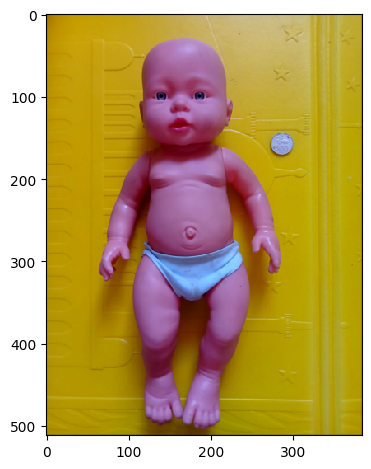

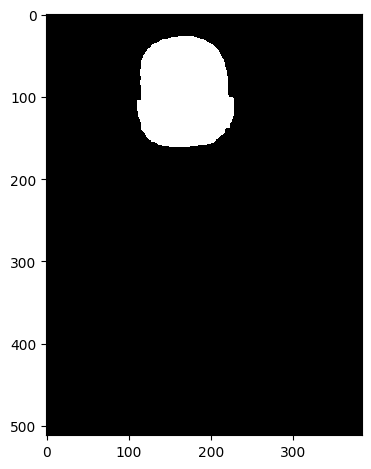

/usr/local/lib/python3.10/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


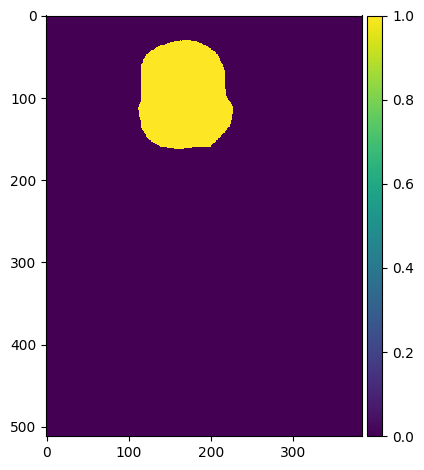

In [48]:
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

# Perform a sanity check on some random validation samples

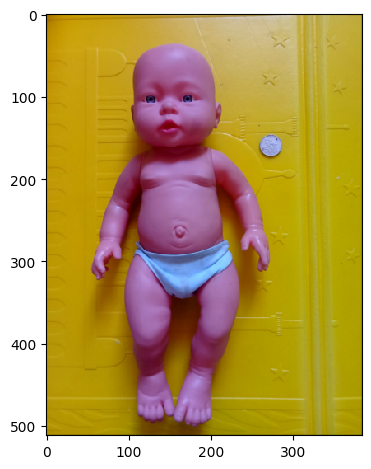

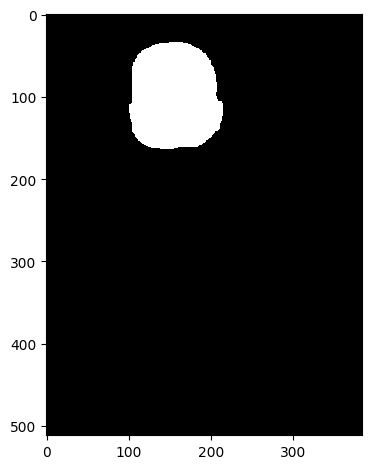

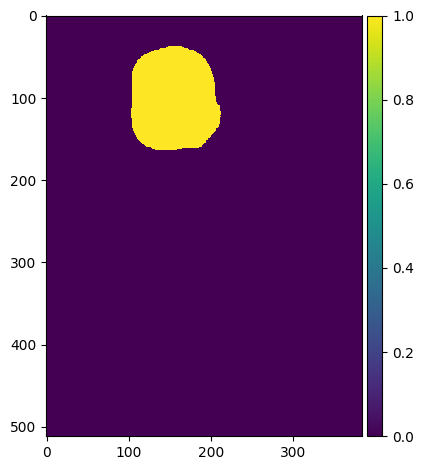

In [49]:
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(y_train[int(y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

# Perform Prediction from Image Test

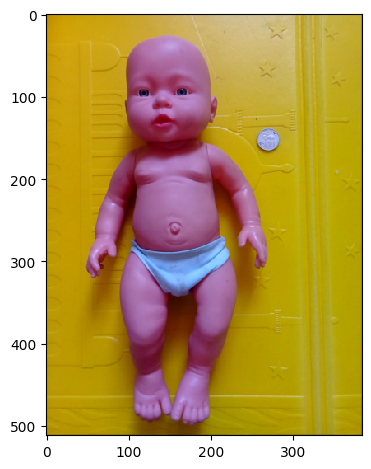

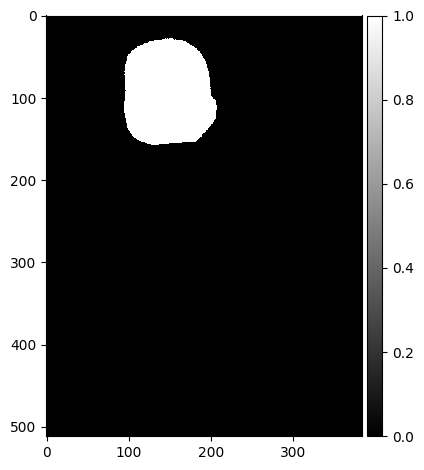

In [50]:
ix = random.randint(0, len(preds_test_t))
imshow(X_test[ix])
plt.show()

imshow(np.squeeze(preds_test_t[ix]), cmap='gray')
plt.show()

# Saving Model

In [51]:
model.save('model_head.keras')


# ==== Main Code Ends Here ===

In [ ]:
loaded_model = tf.keras.models.load_model('D:\\BANGKIT\\Capstone Project\\GITHUB\\model_head.keras', safe_mode=False)

c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 48 variables whereas the saved optimizer has 94 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
preds_test = loaded_model.predict(X_test, verbose=1)

preds_test_t = (preds_test > 0.5).astype(np.uint8)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


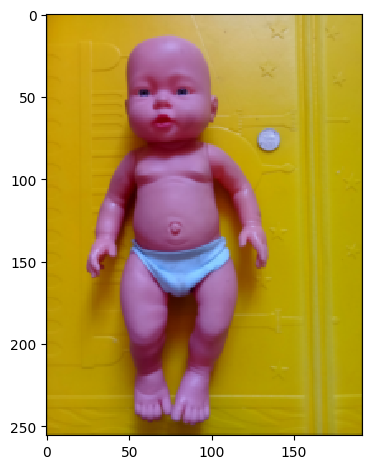

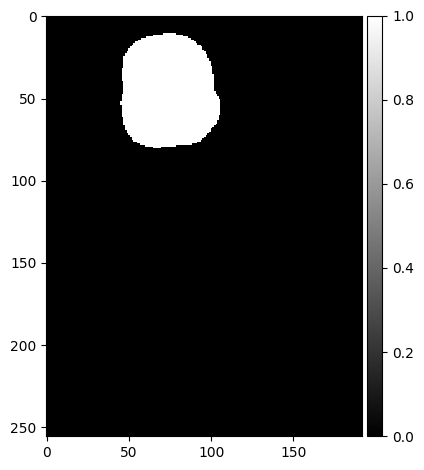

In [ ]:
ix = random.randint(0, len(preds_test_t))
imshow(X_test[ix])
plt.show()

imshow(np.squeeze(preds_test_t[ix]), cmap='gray')
plt.show()